## Formatting Results

In [15]:
# Let's start by importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np

# Modify the function to extract the run parameter
def extract_params(filename):
    match = re.search(r'Run=(\w+)_', filename)
    run = match.group(1) if match else None
    name_without_extension = os.path.splitext(filename)[0]
    return run, name_without_extension

# Dictionaries to store dataframes along with their parameters
labels_data = {}
scores_data = {}
weights_data = {}
distances_data = {}
feature_order_data = {}

# Path to the directory with the files
path = 'results/'

# Loop through all files in the directory
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        # Read the data
        df = pd.read_csv(path + filename)
        
        # Extract parameters from the filename
        run, params = extract_params(filename)
        
        # Depending on the type of data, append it to the appropriate dictionary
        if 'labels' in filename:
            labels_data.setdefault(run, []).append((df, params))
        elif 'scores' in filename:
            scores_data.setdefault(run, []).append((df, params))
        elif 'weights' in filename:
            weights_data.setdefault(run, []).append((df, params))
        elif 'distance_matrix' in filename:
            distances_data.setdefault(run, []).append((df, params))
        elif "feature_orders" in filename:
            feature_order_data.setdefault(run, []).append((df, params))

# Modify the combine_files function to accept a dictionary
def combine_files(file_data_dict, output_file_pattern):
    combined_data = {}

    for run, file_data in file_data_dict.items():
        # Initialize an empty dataframe to store the combined data
        combined_df = pd.DataFrame()

        # Loop through all dataframes and their parameters
        for df, params in file_data:
            # Rename the column with the data to reflect the parameters
            column_name = params
            df = df.rename(columns={df.columns[0]: column_name})
            # If the combined dataframe is empty, replace it with the current dataframe
            if combined_df.empty:
                combined_df = df
            else:
                # Otherwise, merge the current dataframe with the combined dataframe
                combined_df = pd.concat([combined_df, df], axis=1)
        
        # Write the combined dataframe to a CSV file
        output_file = output_file_pattern.format(run)
        combined_df.to_csv(output_file, index=False)
        combined_data[run] = combined_df

    return combined_data

# Combine the data, outputting a separate file for each run
combined_scores = combine_files(scores_data, 'combined_results/combined_scores_{}.csv')
combined_weights = combine_files(weights_data, 'combined_results/combined_weights_{}.csv')
combined_labels = combine_files(labels_data, 'combined_results/combined_labels_{}.csv')
combined_orders = combine_files(feature_order_data, 'combined_results/feature_orders_{}.csv')

In [16]:
# Modify the combine_files function to accept a dictionary
def combine_files(file_data_dict, output_file_pattern):
    combined_data = {}

    for run, file_data in file_data_dict.items():
        # Initialize an empty dataframe to store the combined data
        combined_df = pd.DataFrame()

        # Loop through all dataframes and their parameters
        for df, params in file_data:
            # Rename the column with the data to reflect the parameters
            column_name = params
            df = df.rename(columns={df.columns[0]: column_name})
            # If the combined dataframe is empty, replace it with the current dataframe
            if combined_df.empty:
                combined_df = df
            else:
                # Otherwise, merge the current dataframe with the combined dataframe
                combined_df = pd.concat([combined_df, df], axis=1)
        
        # Write the combined dataframe to a CSV file
        output_file = output_file_pattern.format(run)
        combined_df.to_csv(output_file, index=False)
        combined_data[run] = combined_df

    return combined_data

# Combine the data, outputting a separate file for each run
combined_scores = combine_files(scores_data, 'combined_results/combined_scores_{}.csv')
combined_weights = combine_files(weights_data, 'combined_results/combined_weights_{}.csv')
combined_labels = combine_files(labels_data, 'combined_results/combined_labels_{}.csv')
combined_orders = combine_files(feature_order_data, 'combined_results/feature_orders_{}.csv')

In [17]:
maf_file = "gene_level_data/merged.csv"
maf_df = pd.read_csv(maf_file, index_col=0)
categorical = ["pr_status_by_ihc","her2_status_by_ihc","er_status_by_ihc"]
numerical = maf_df.select_dtypes(include=np.number).columns.tolist()
feature_names = {"categorical":categorical,
                 "numerical":numerical,
                 None:numerical + categorical}

In [18]:
maf_df.reset_index(inplace=True,drop=True)
# Iterate over the dictionary values
for key, value in combined_labels.items():
    # Access the dataframe
    df = value
    df.reset_index(inplace=True,drop=True)
    
    # Add the new column
    df["ajcc_tumor_pathologic_pt"] = maf_df["ajcc_tumor_pathologic_pt"]   # Replace None with the desired values
    df1 = df.loc[df["ajcc_tumor_pathologic_pt"] != "TX", :].copy()
    df1['ajcc_tumor_pathologic_pt_cleaned'] = df1['ajcc_tumor_pathologic_pt'].apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))
    combined_labels[key] = df1

In [19]:
for key in combined_labels.keys():
    combined_labels[key].to_csv(f"combined_results/combined_labels_{key}.csv")

## Are the Clusters aligned with the Tumor Types?

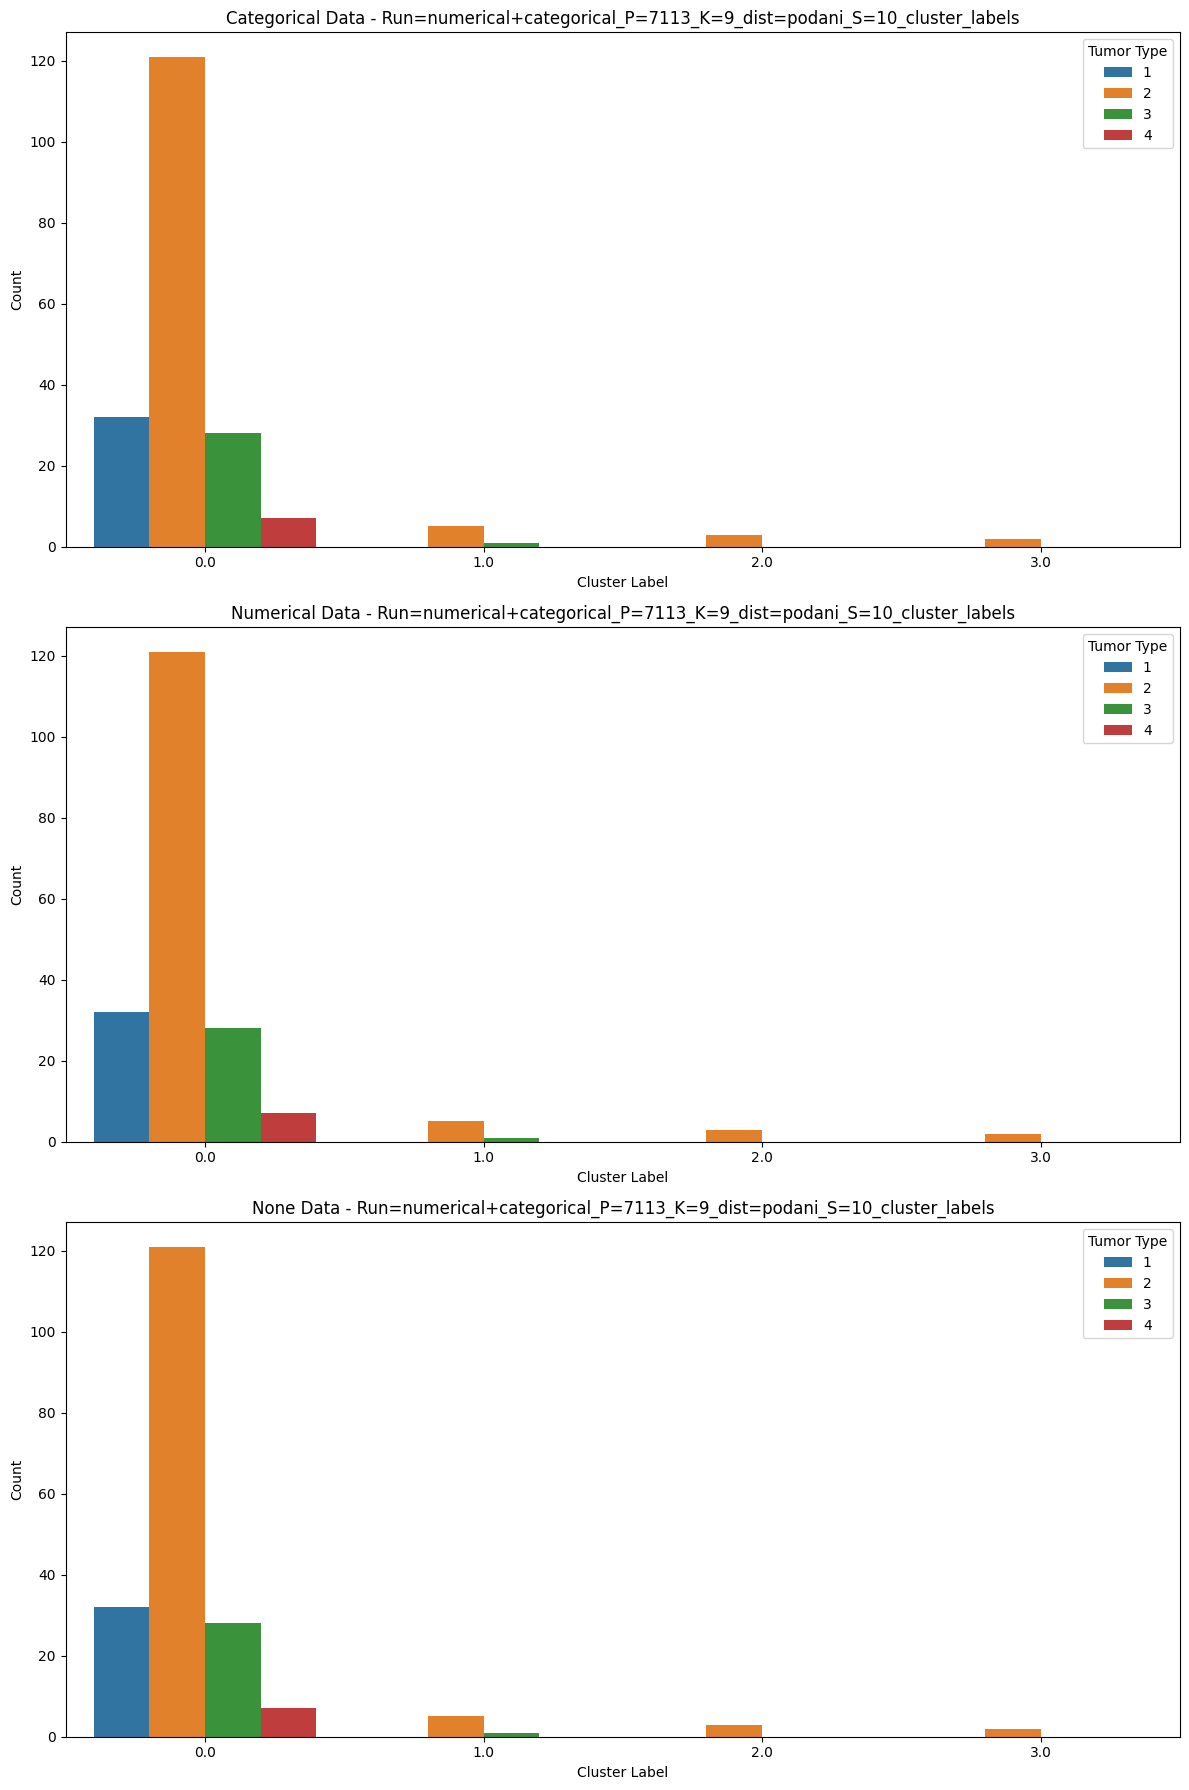

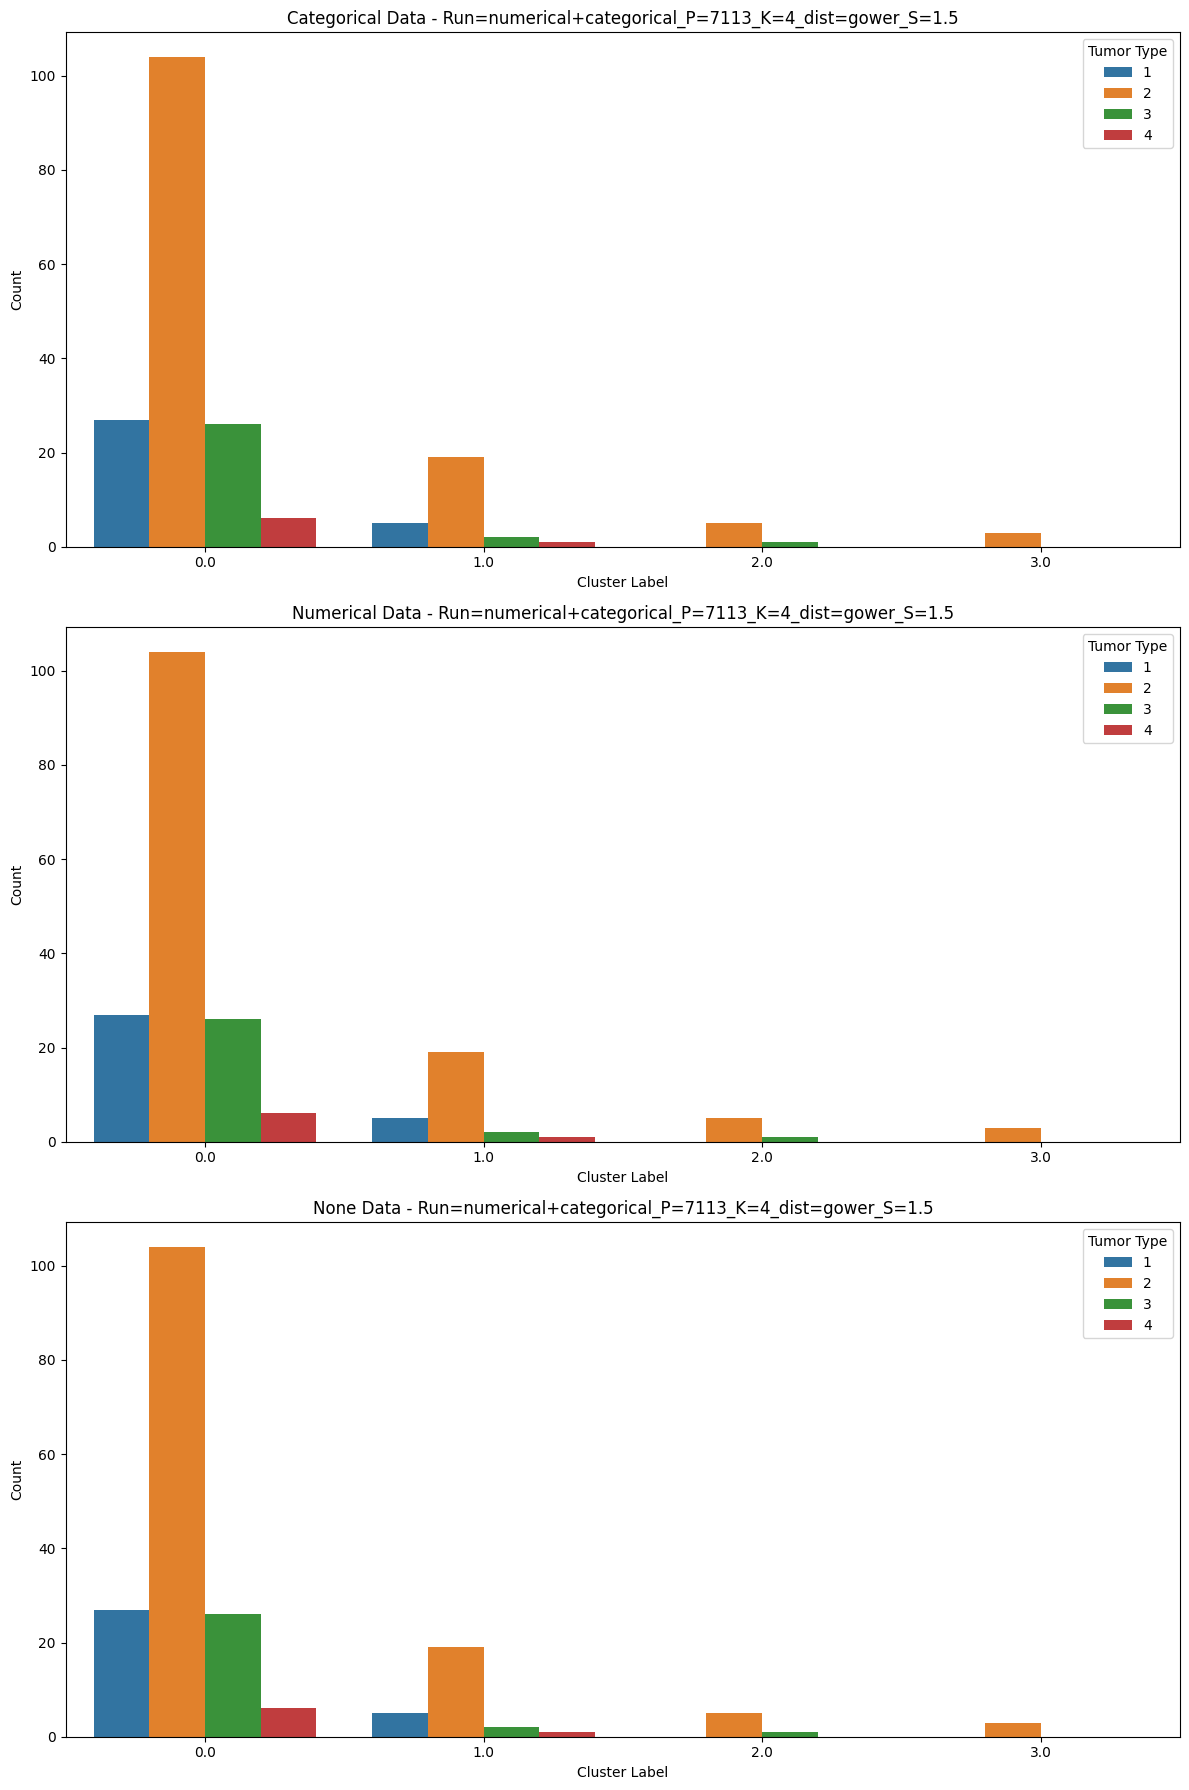

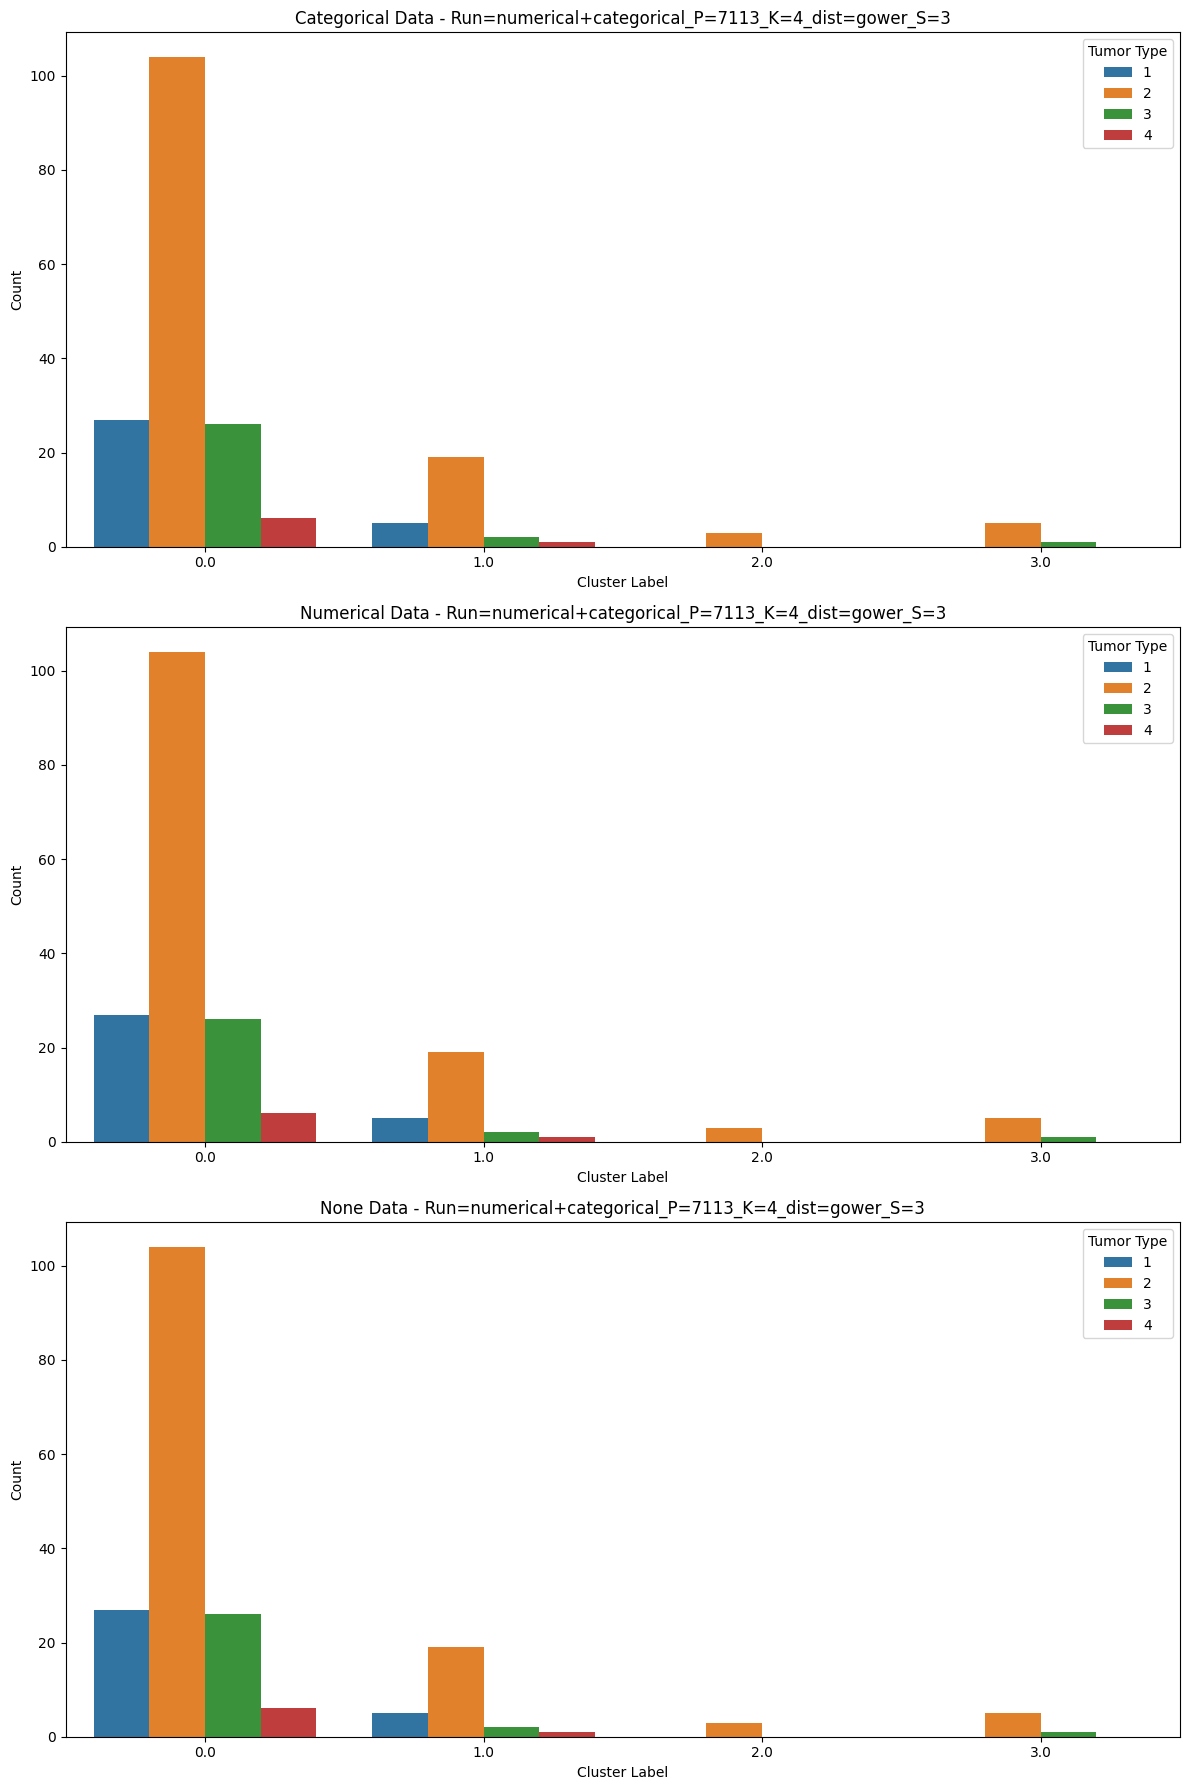

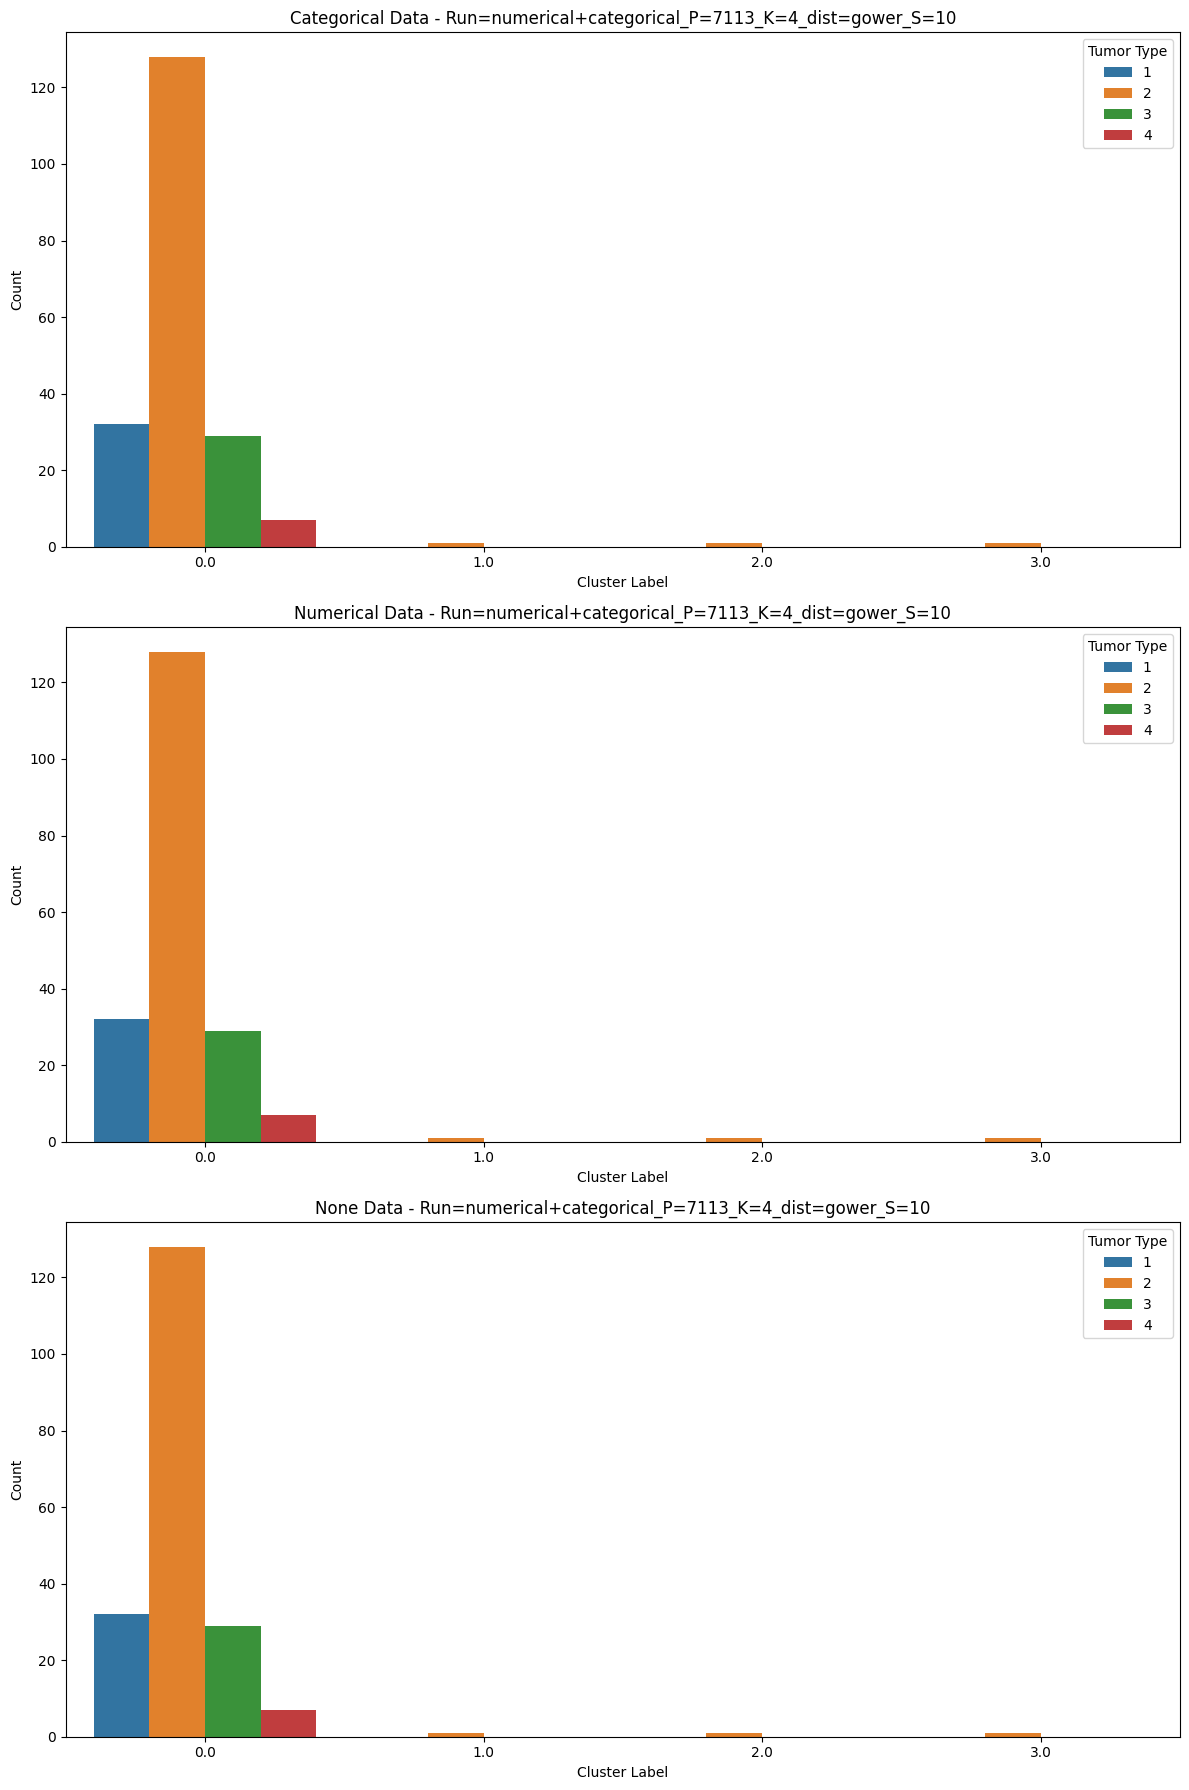

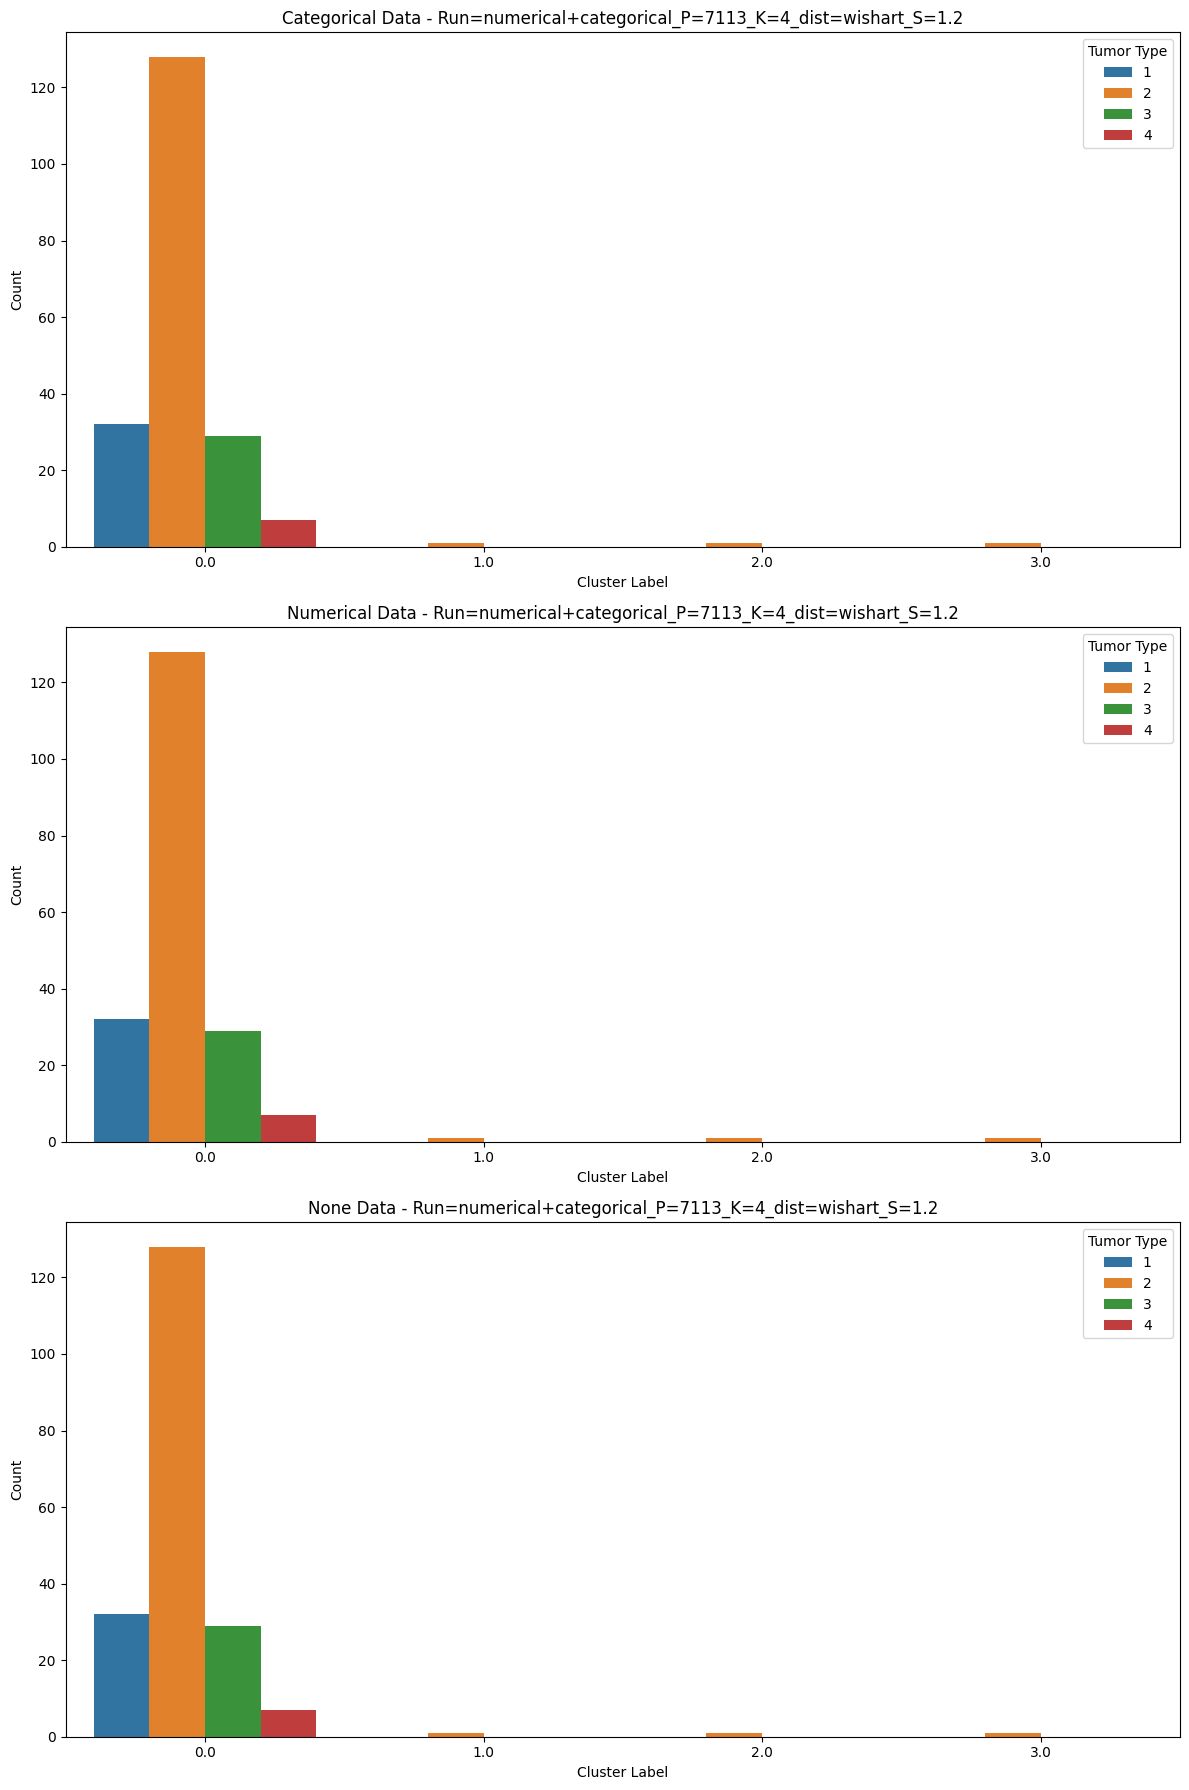

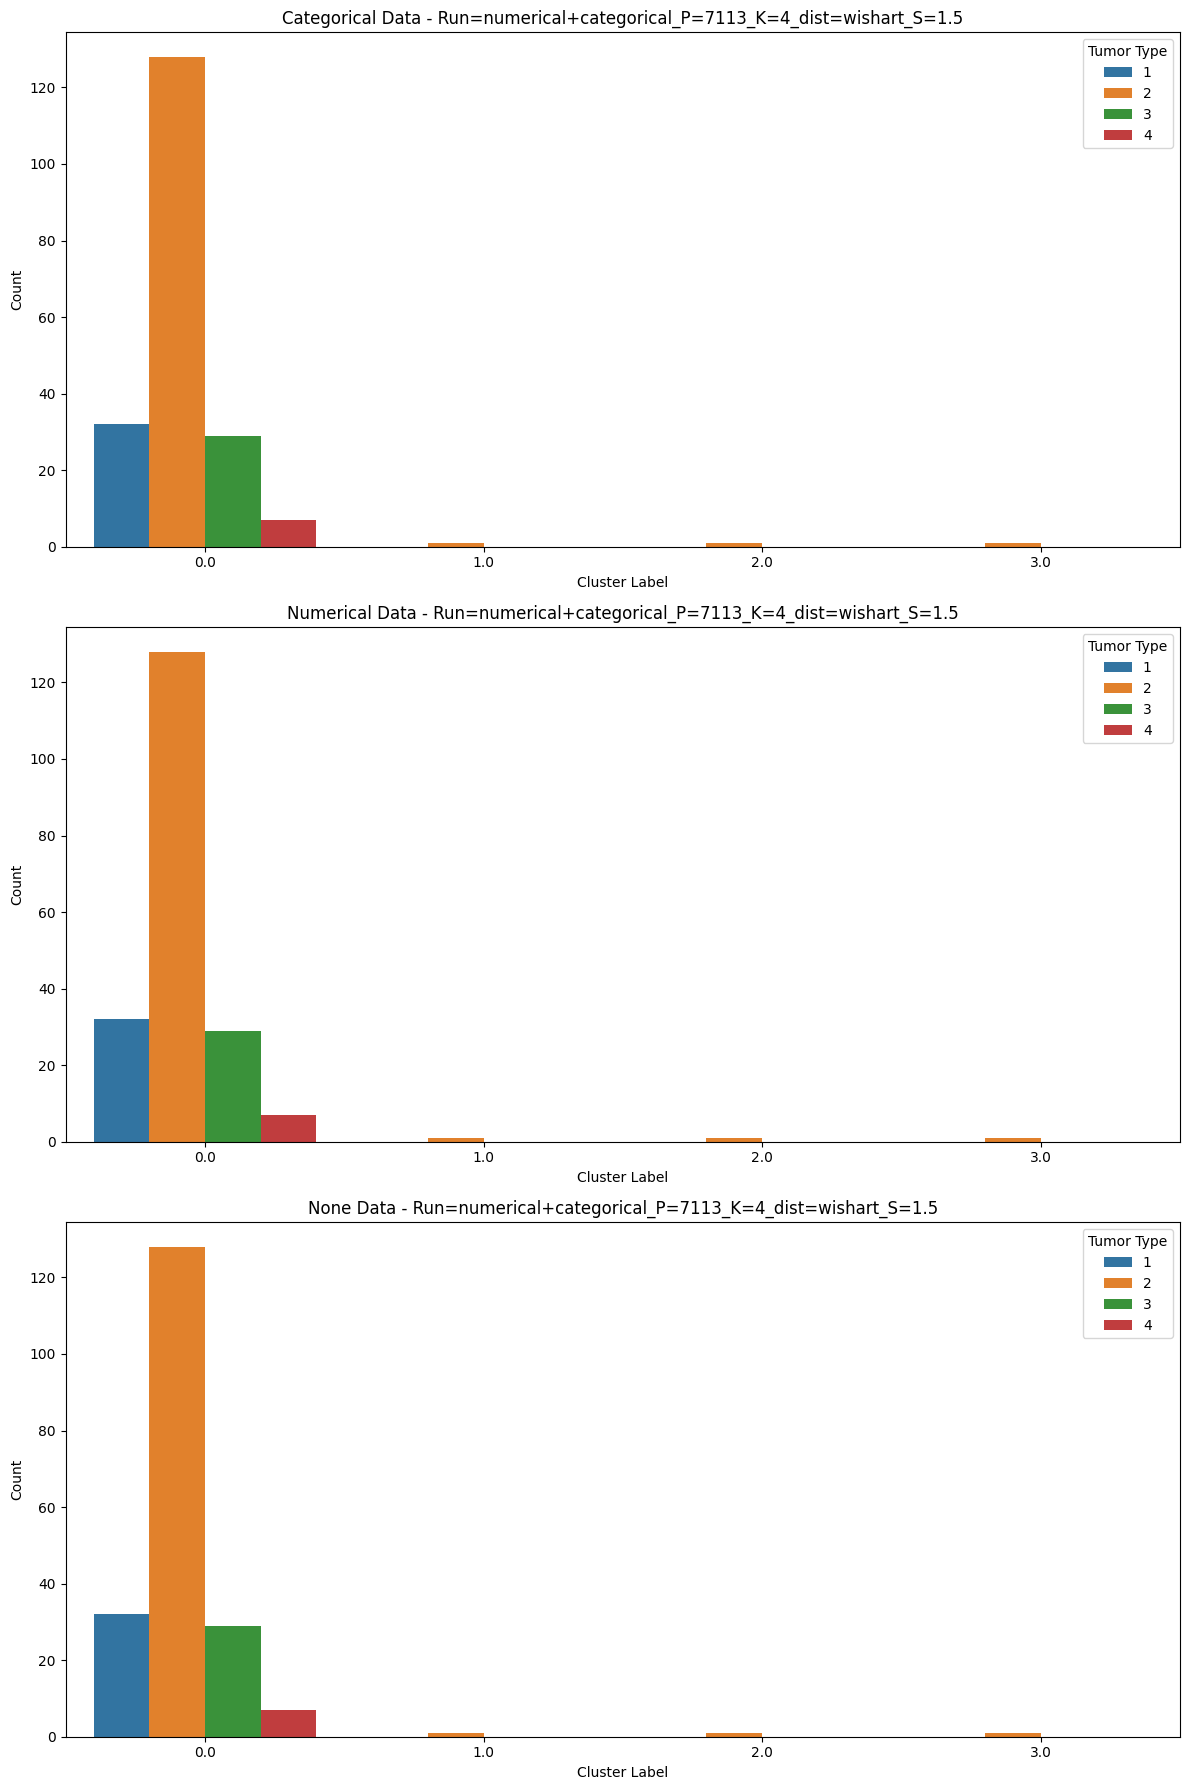

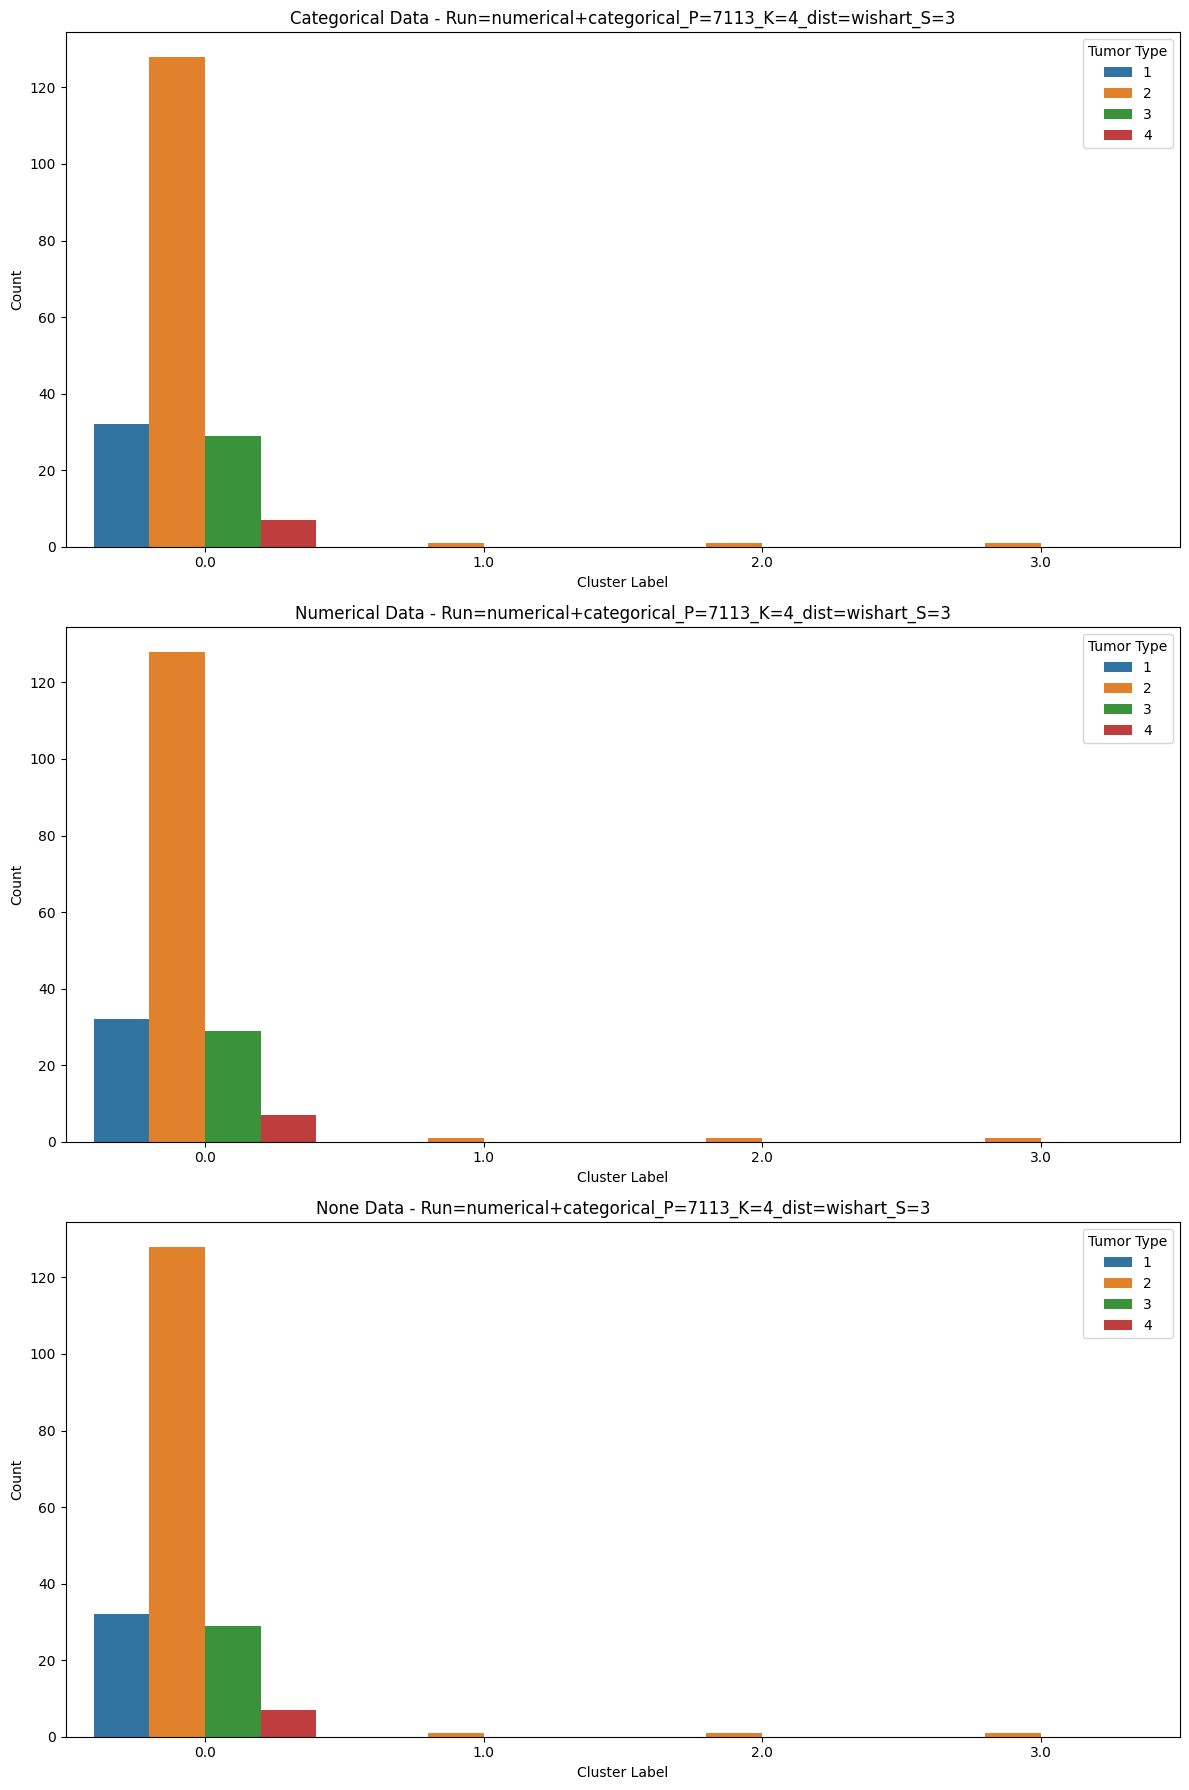

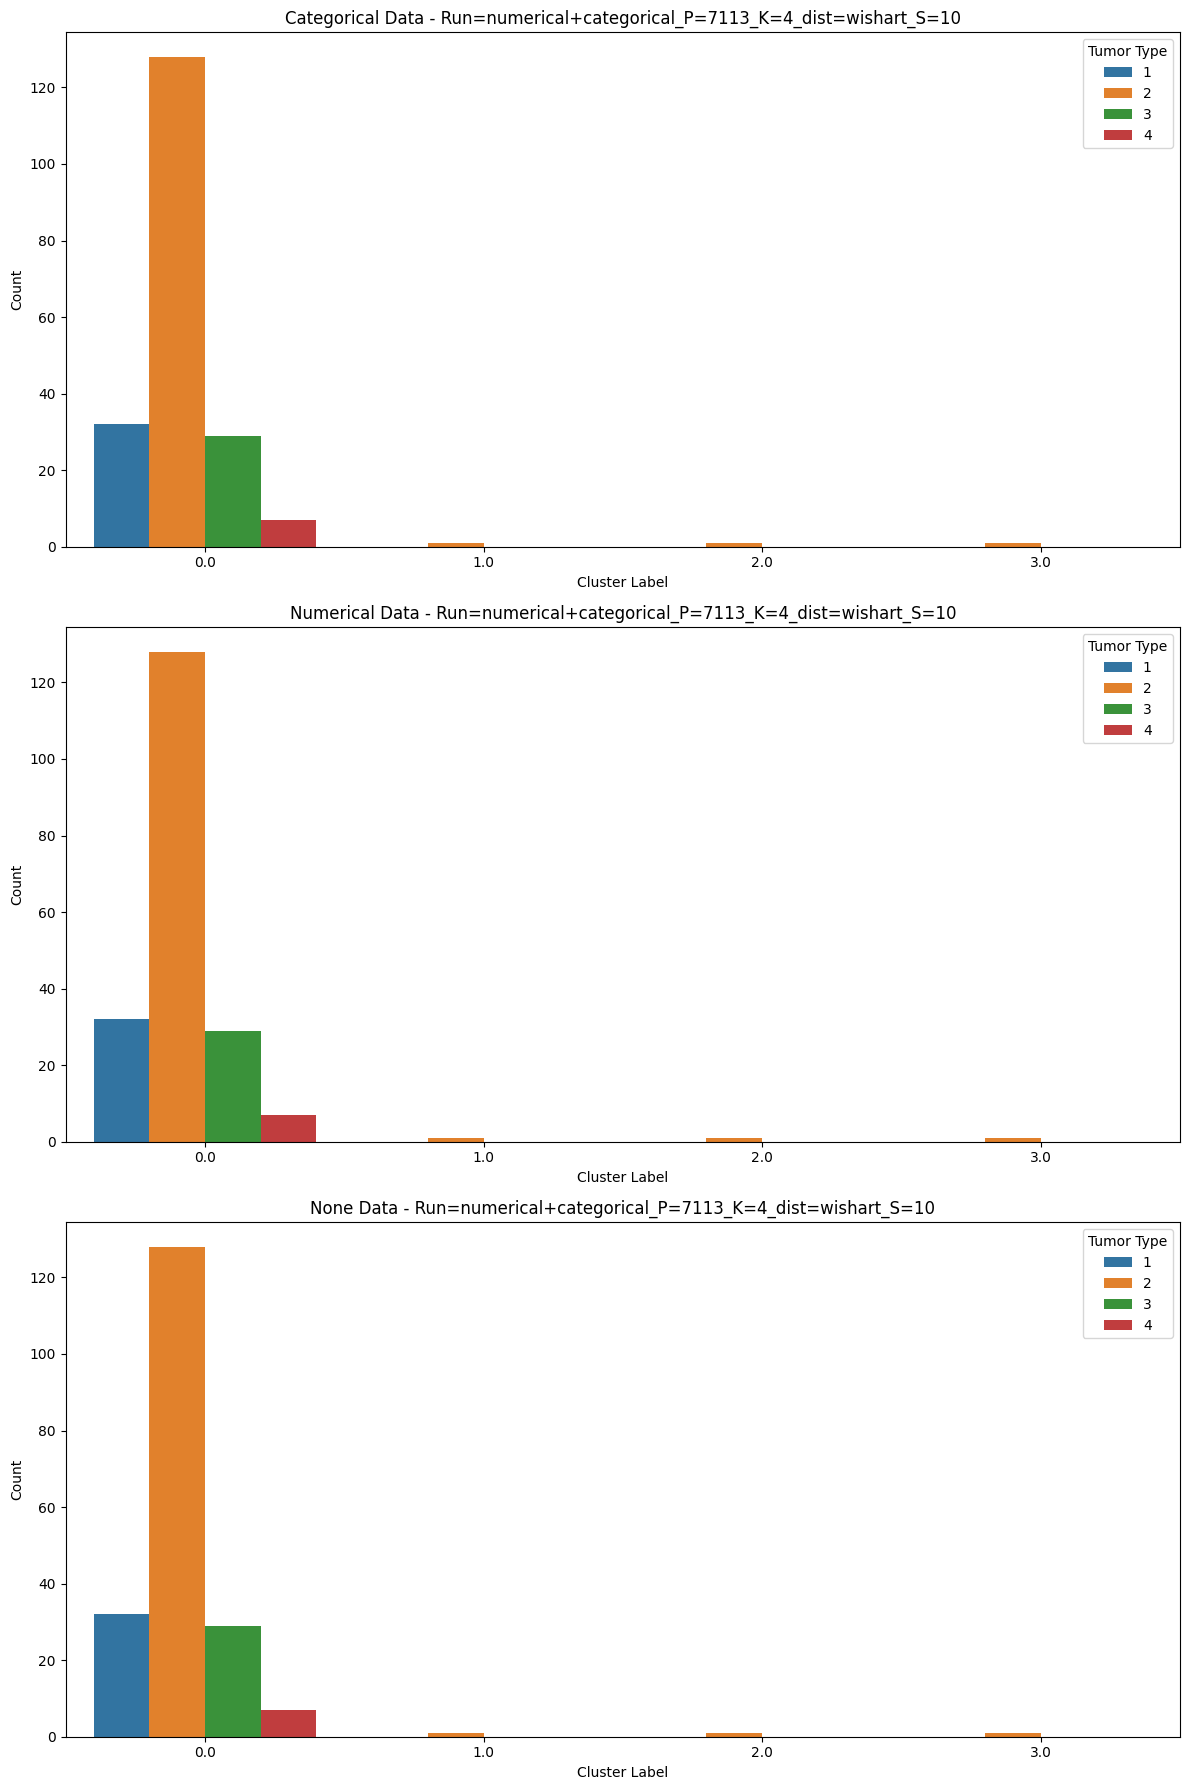

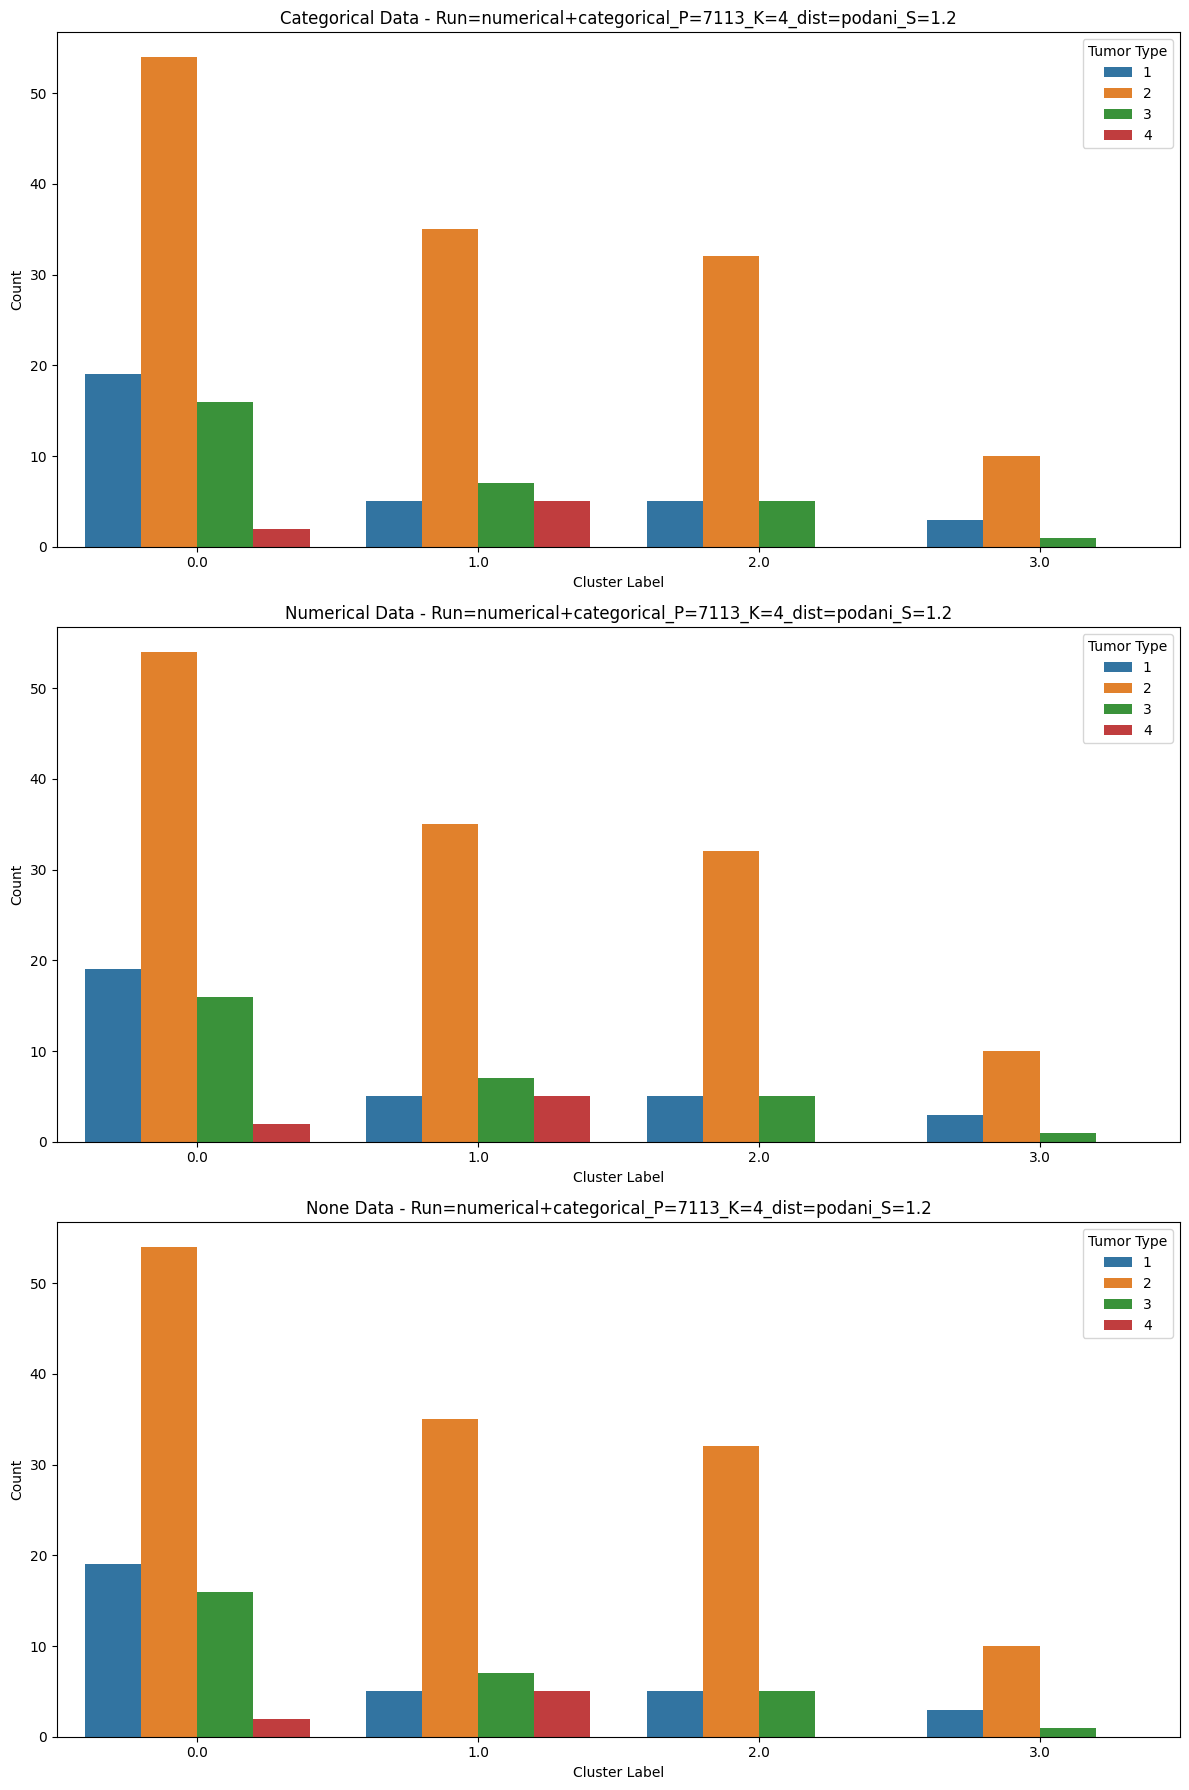

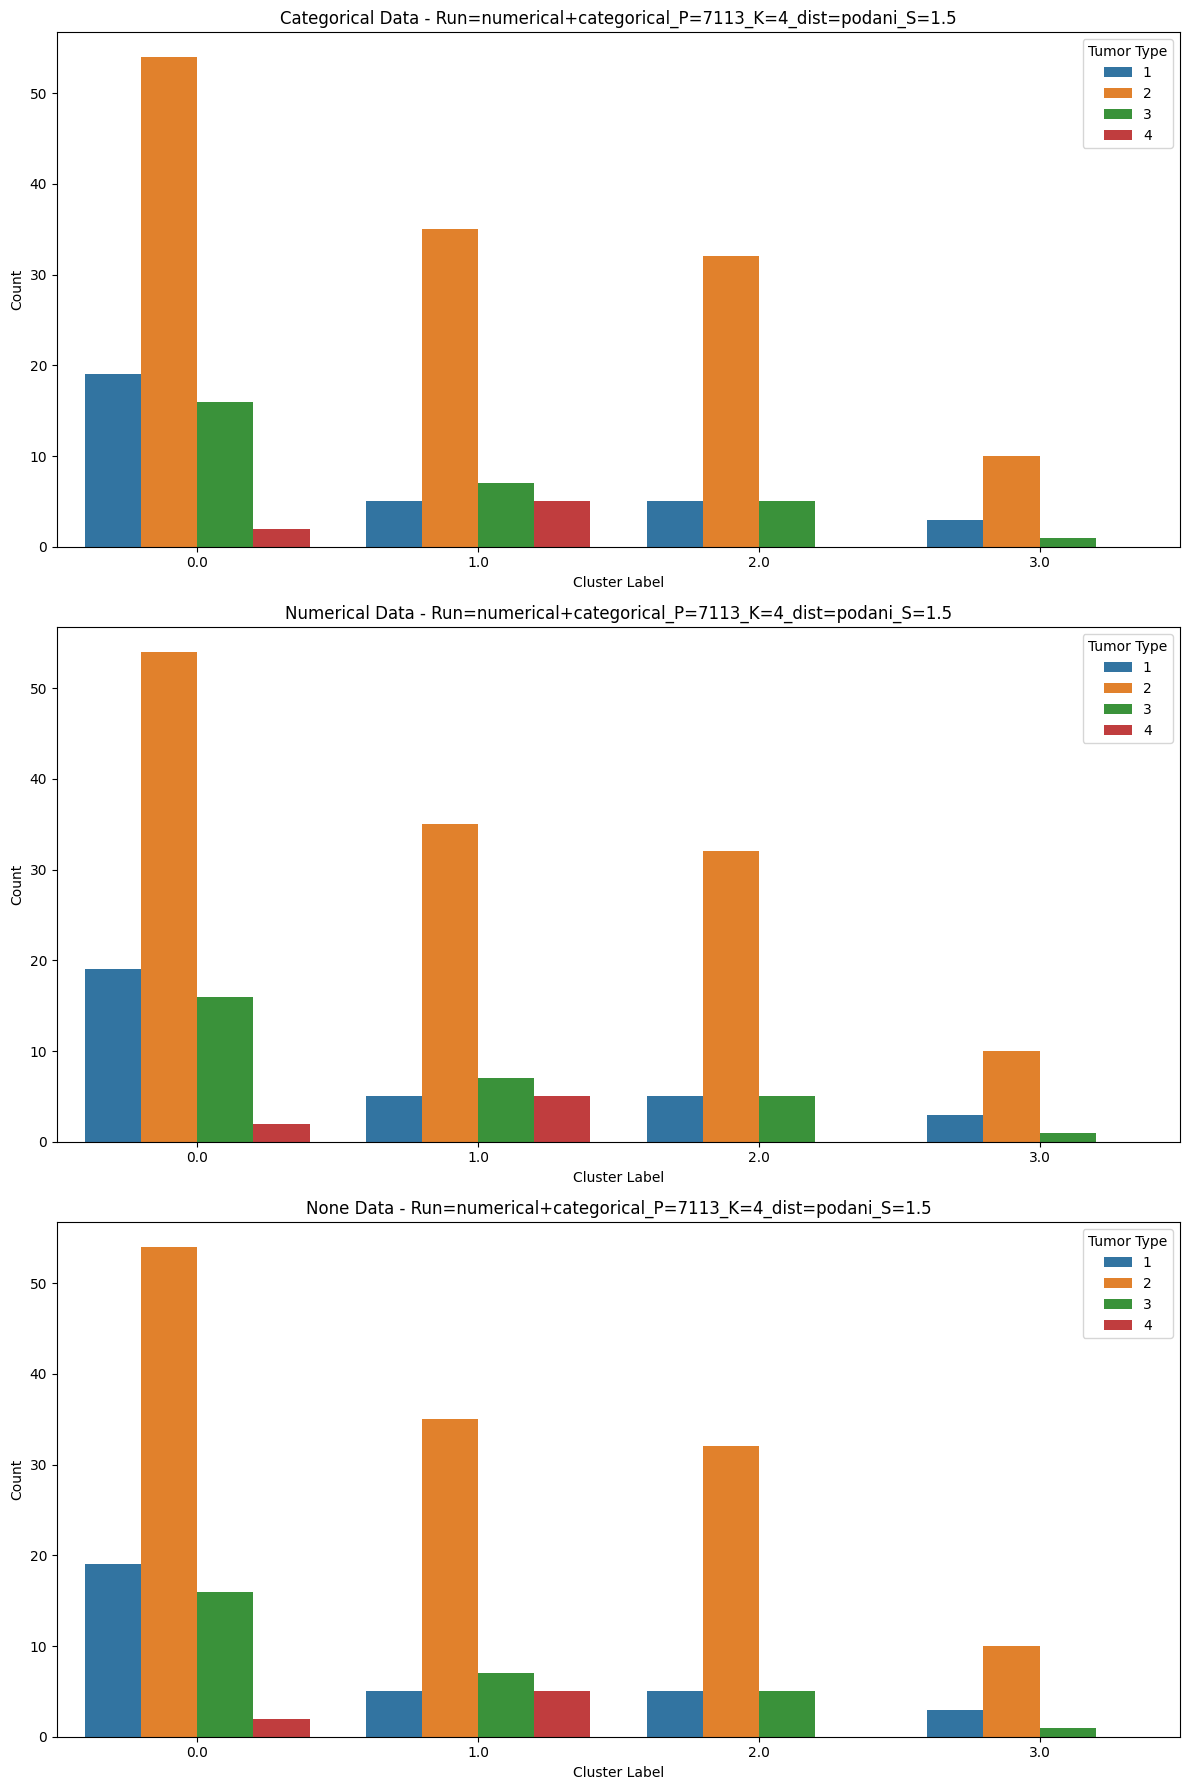

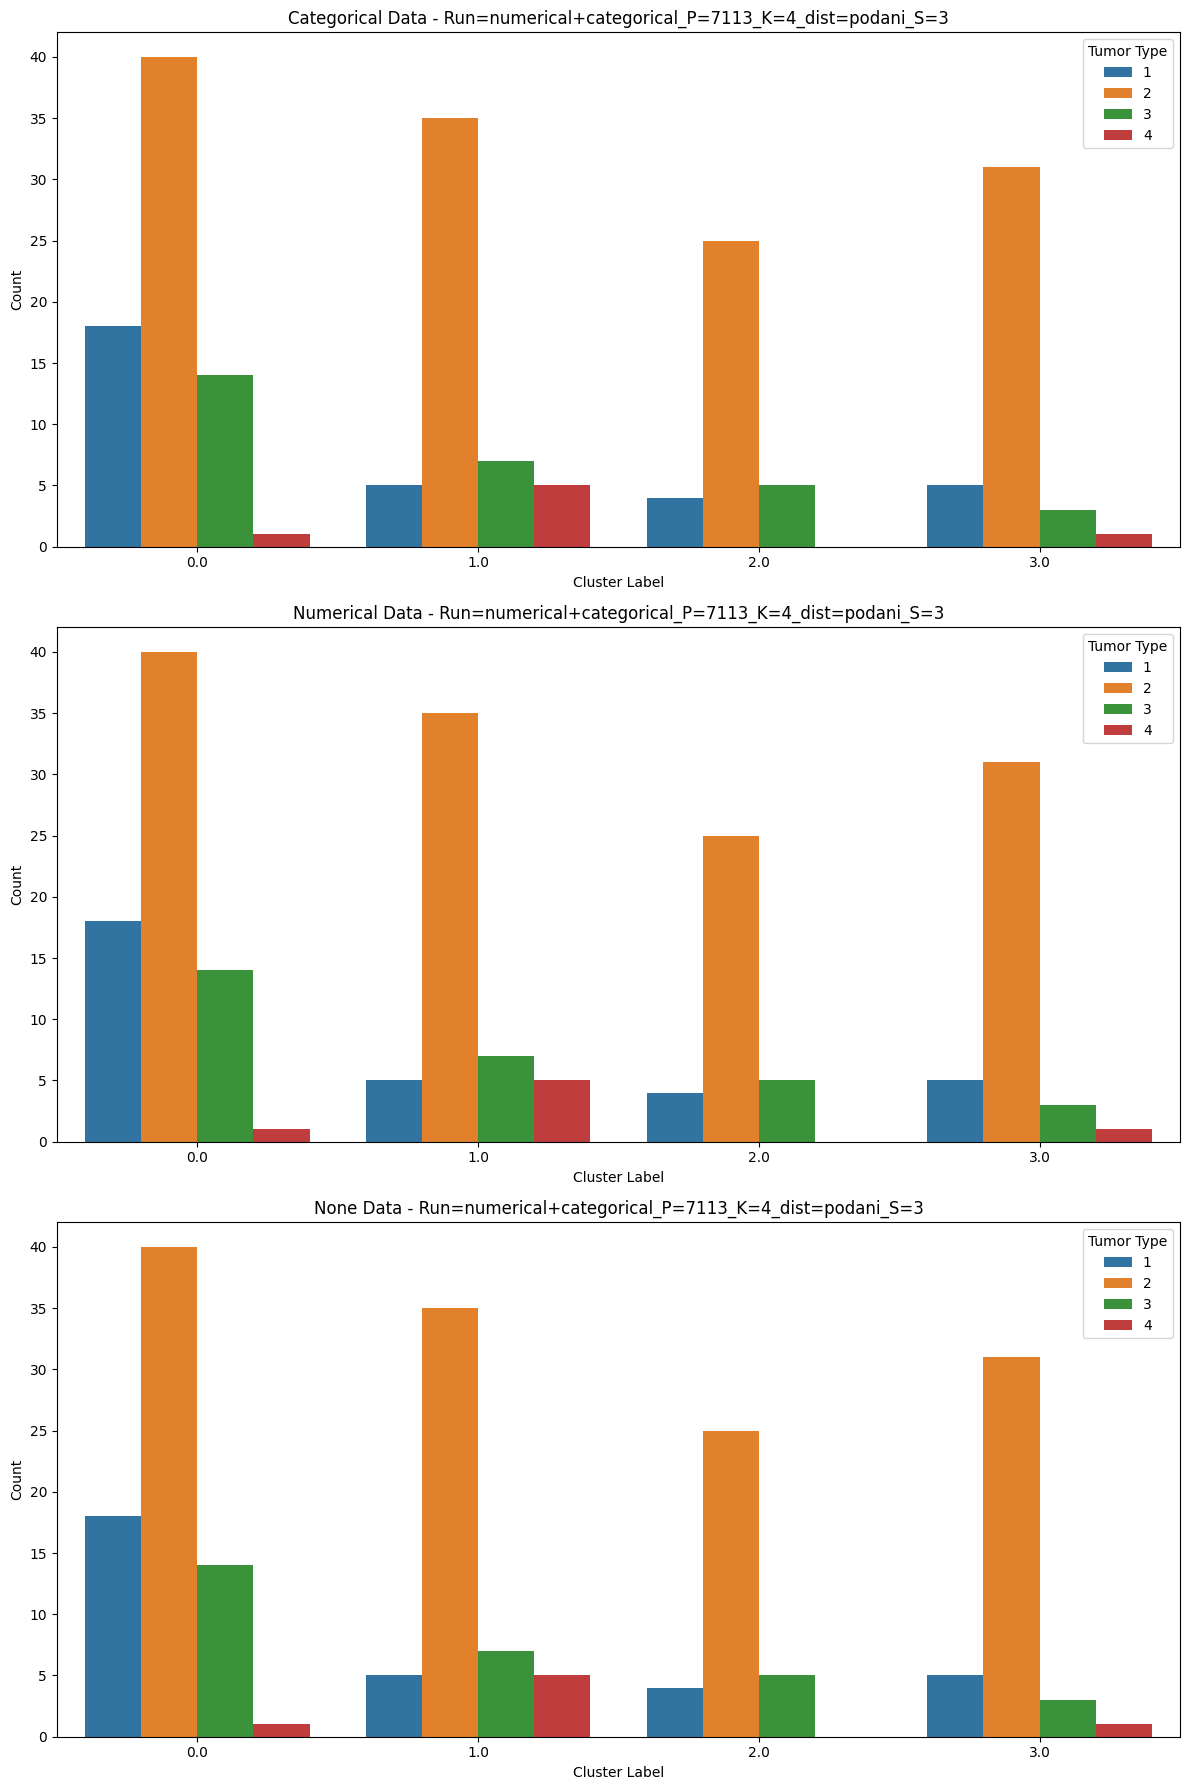

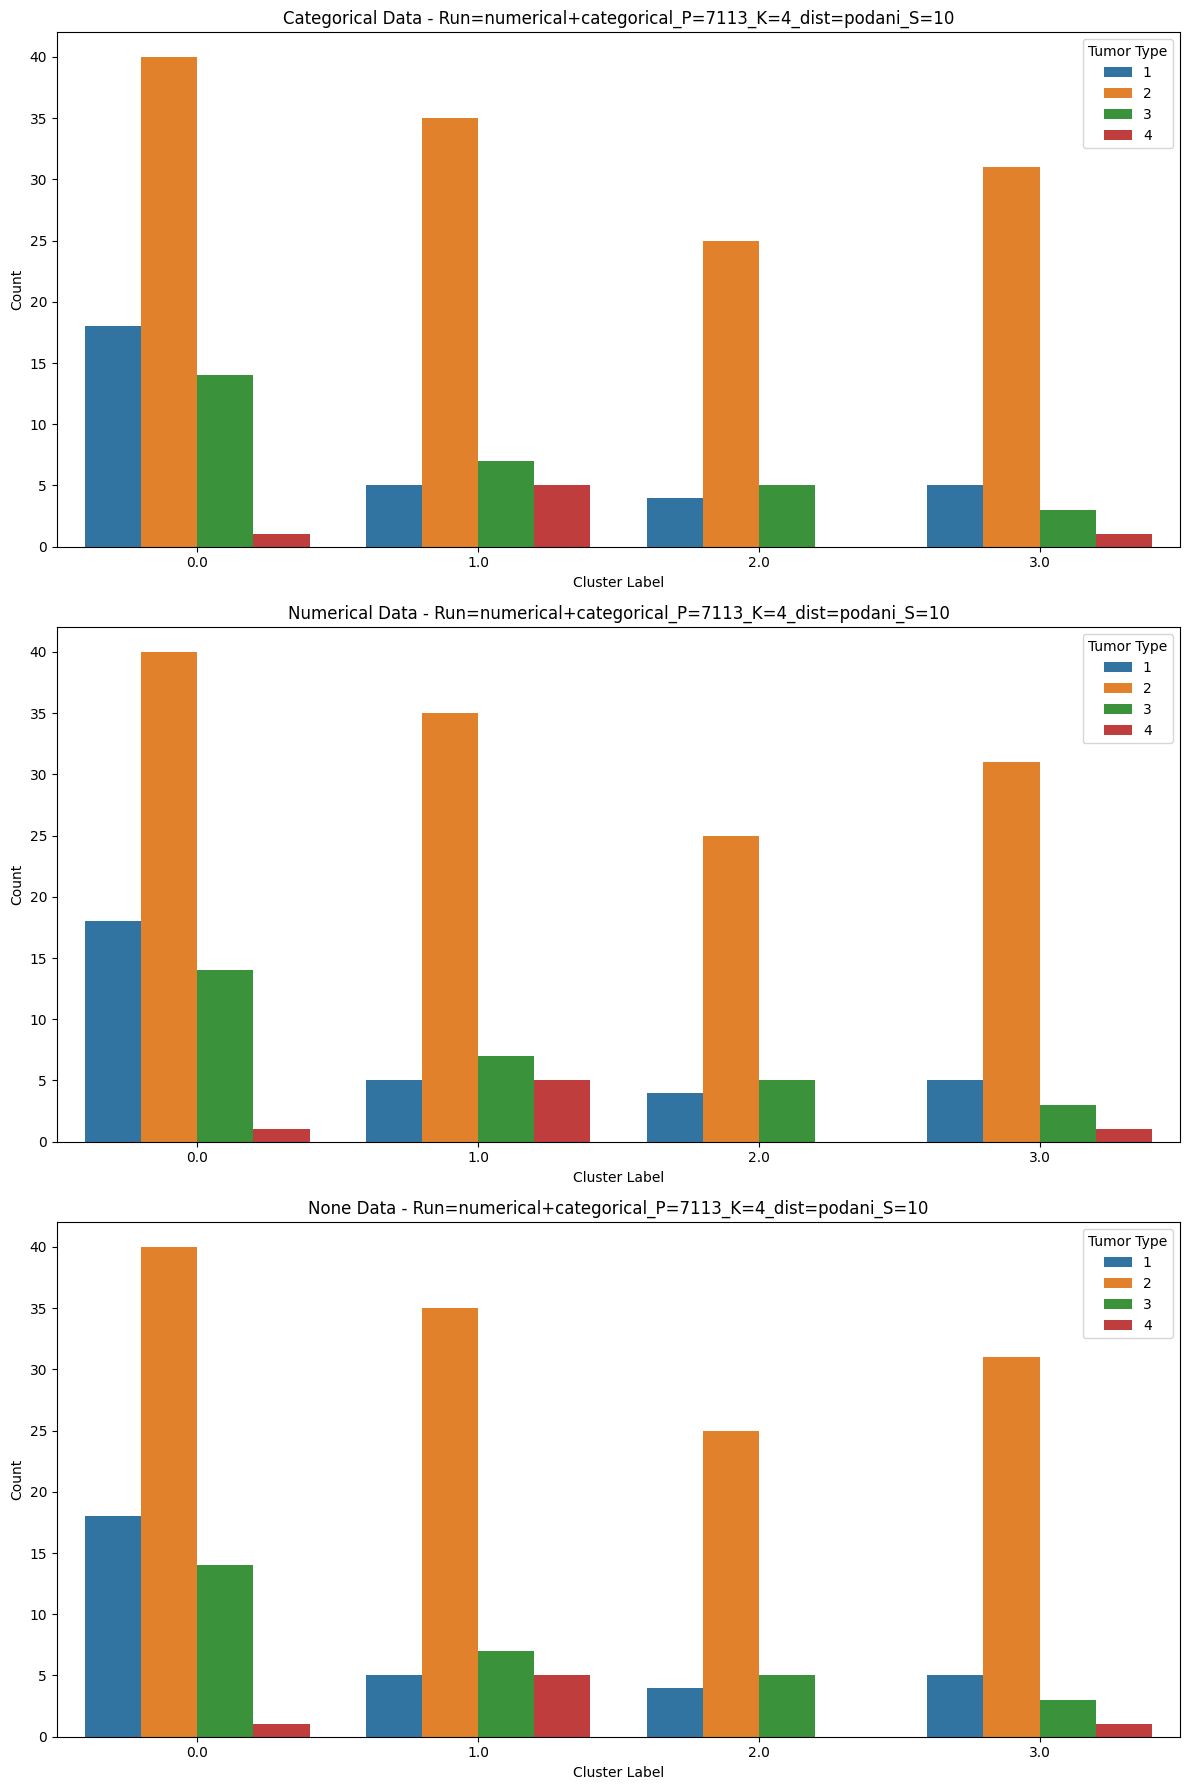

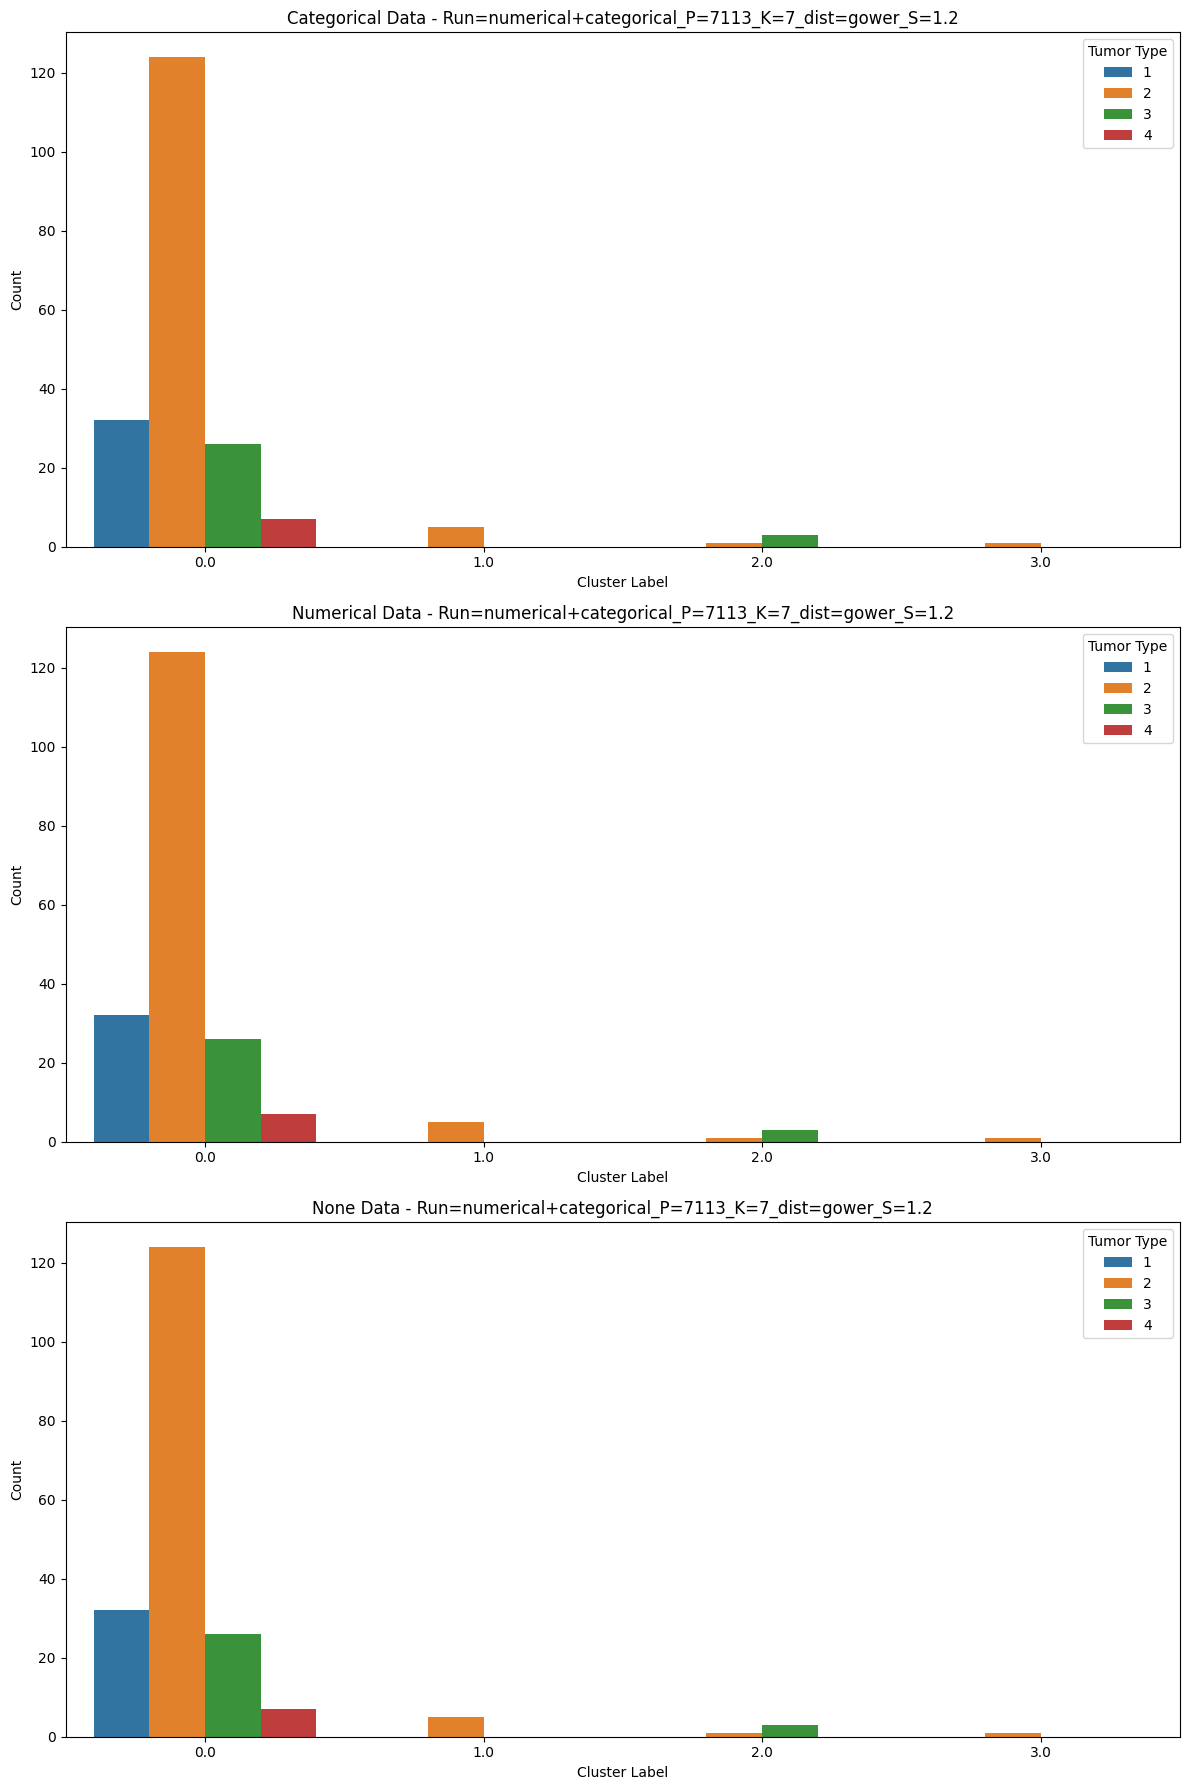

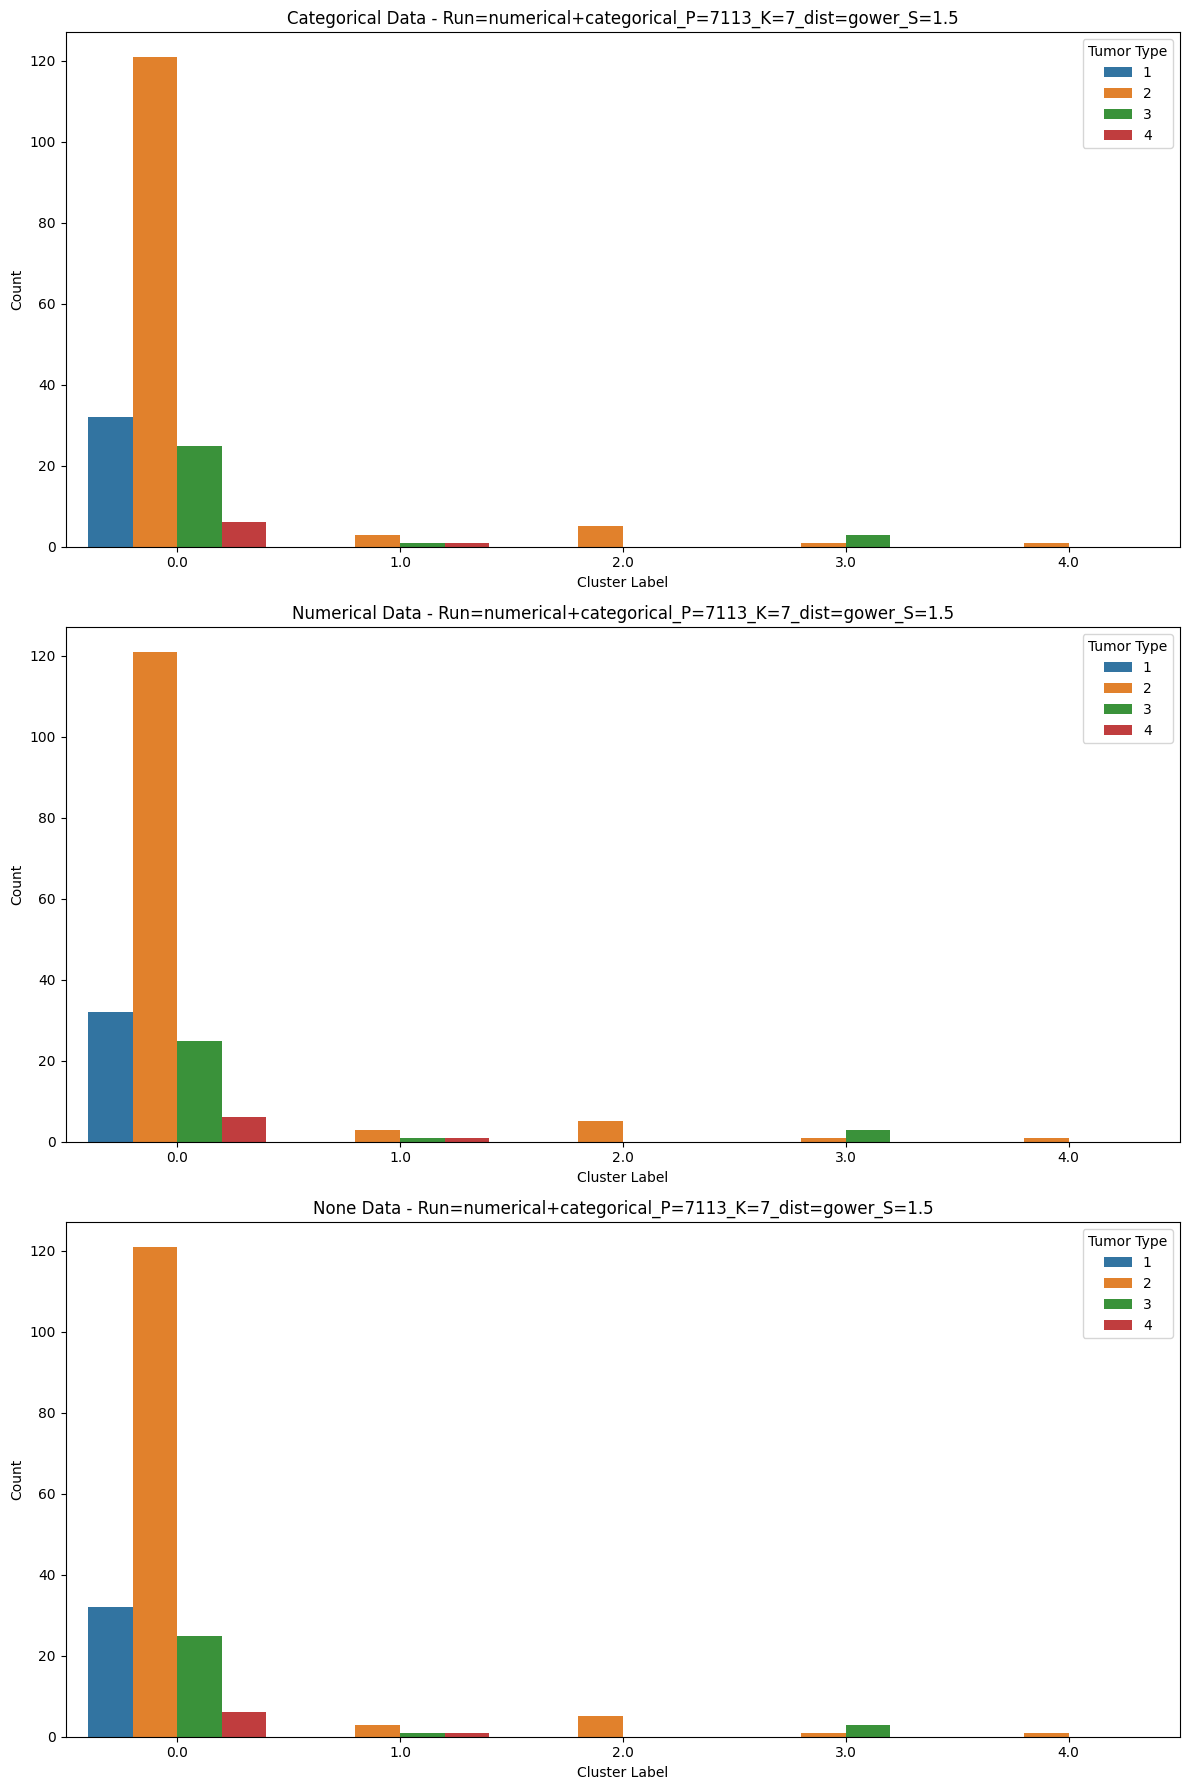

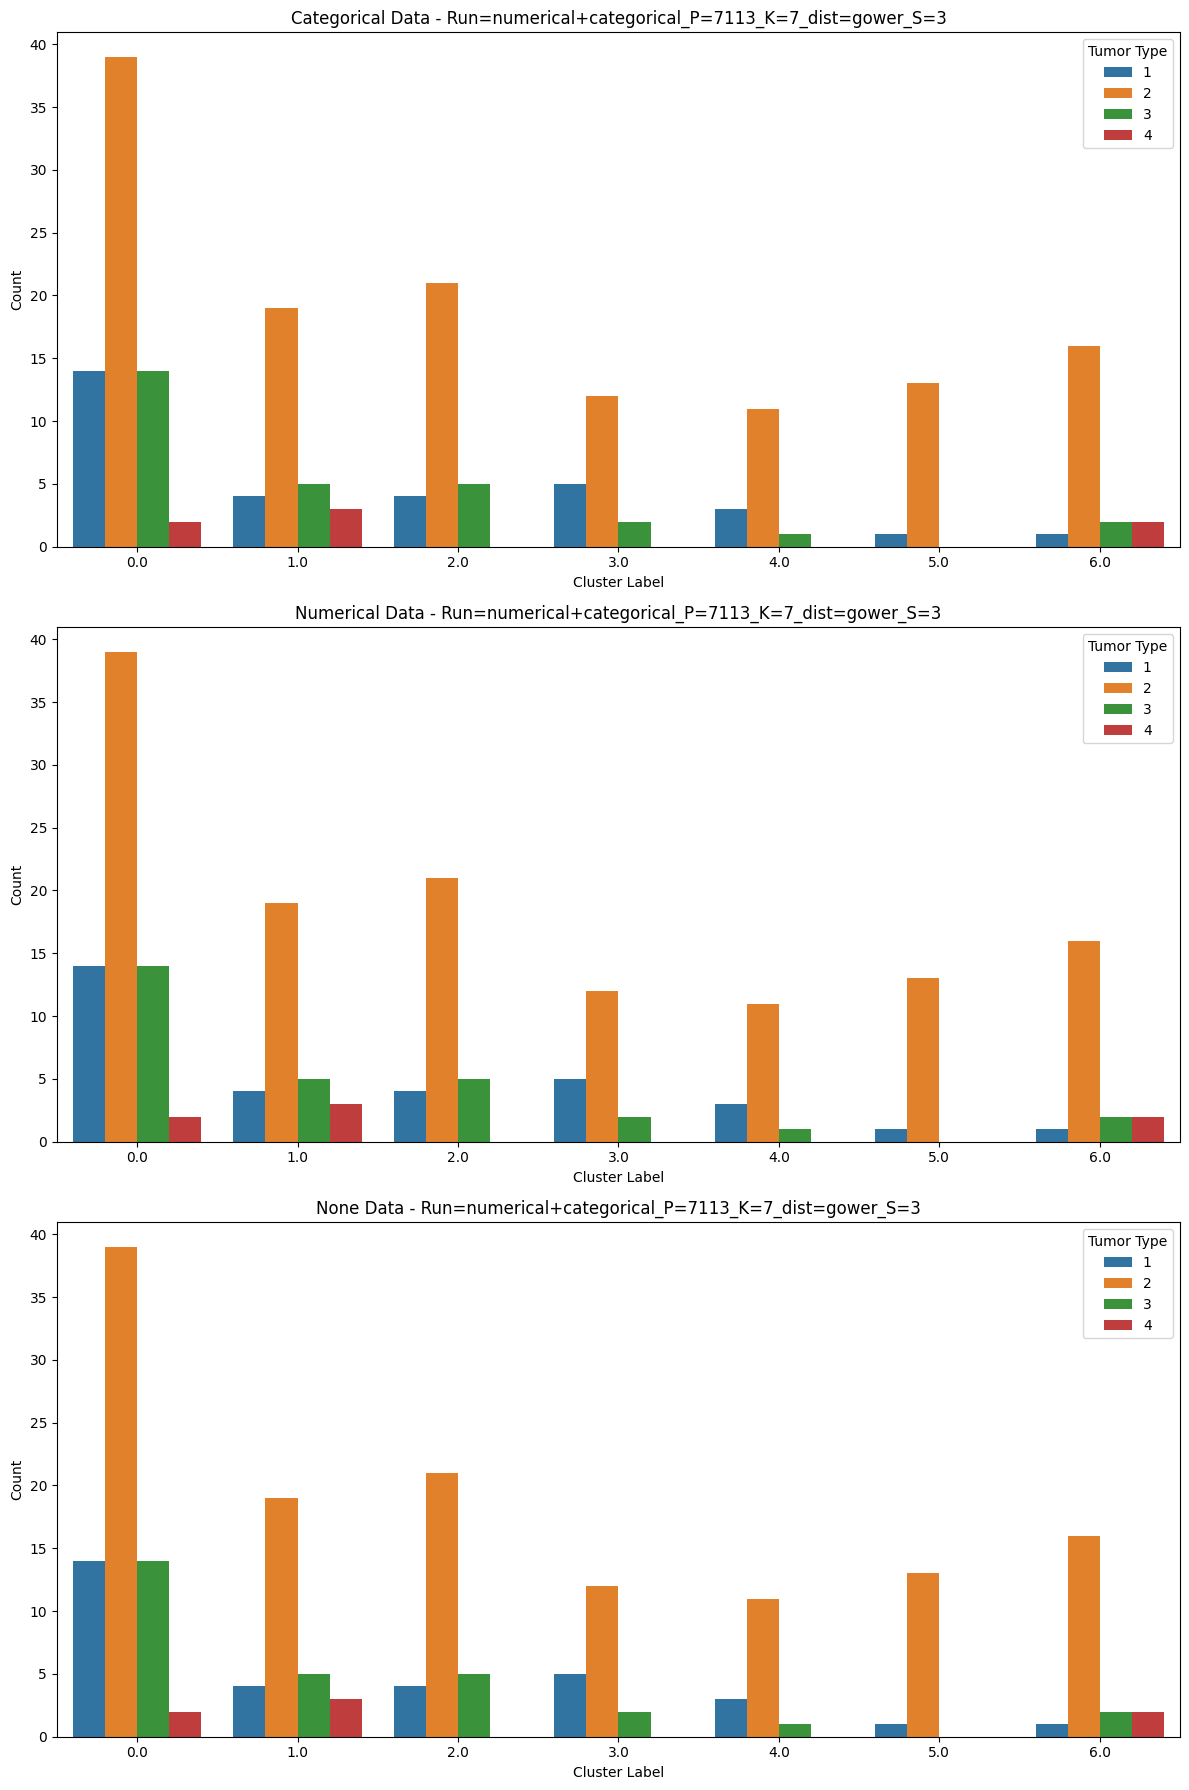

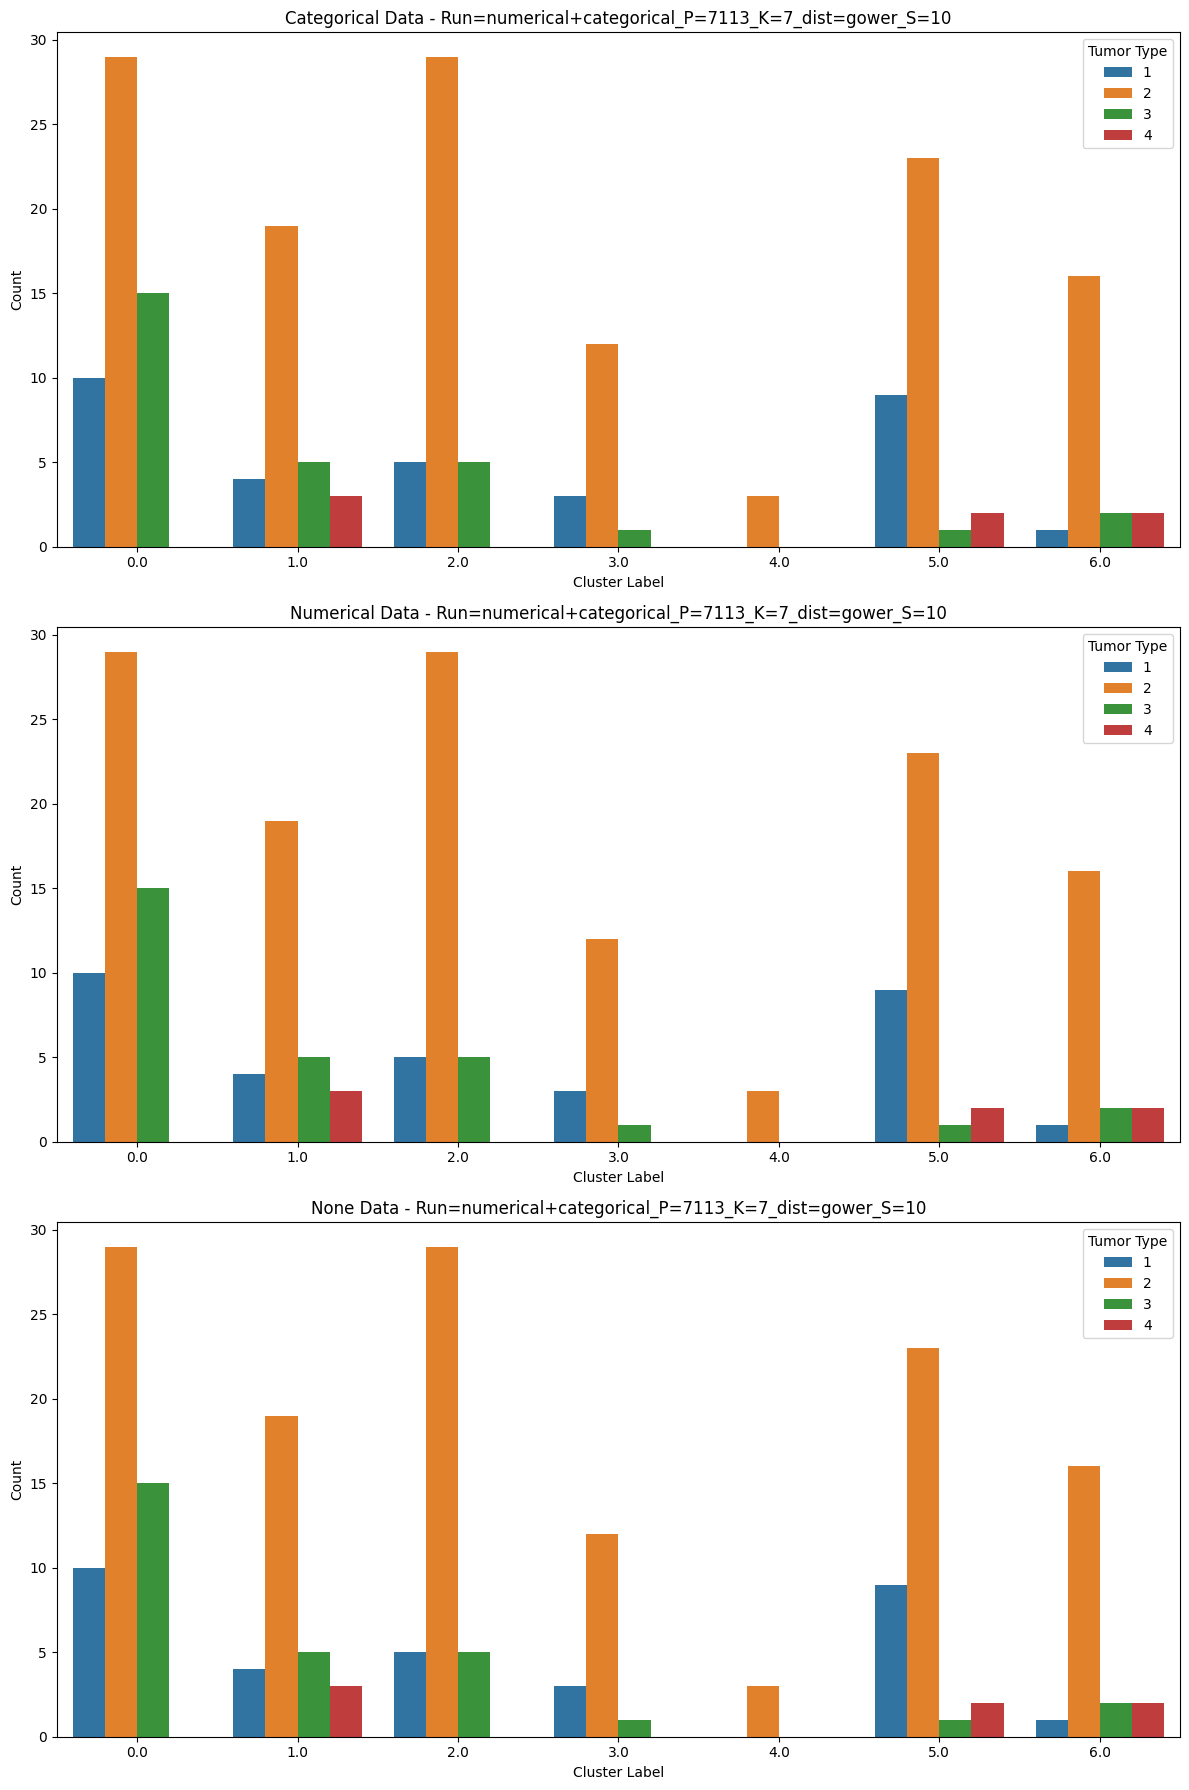

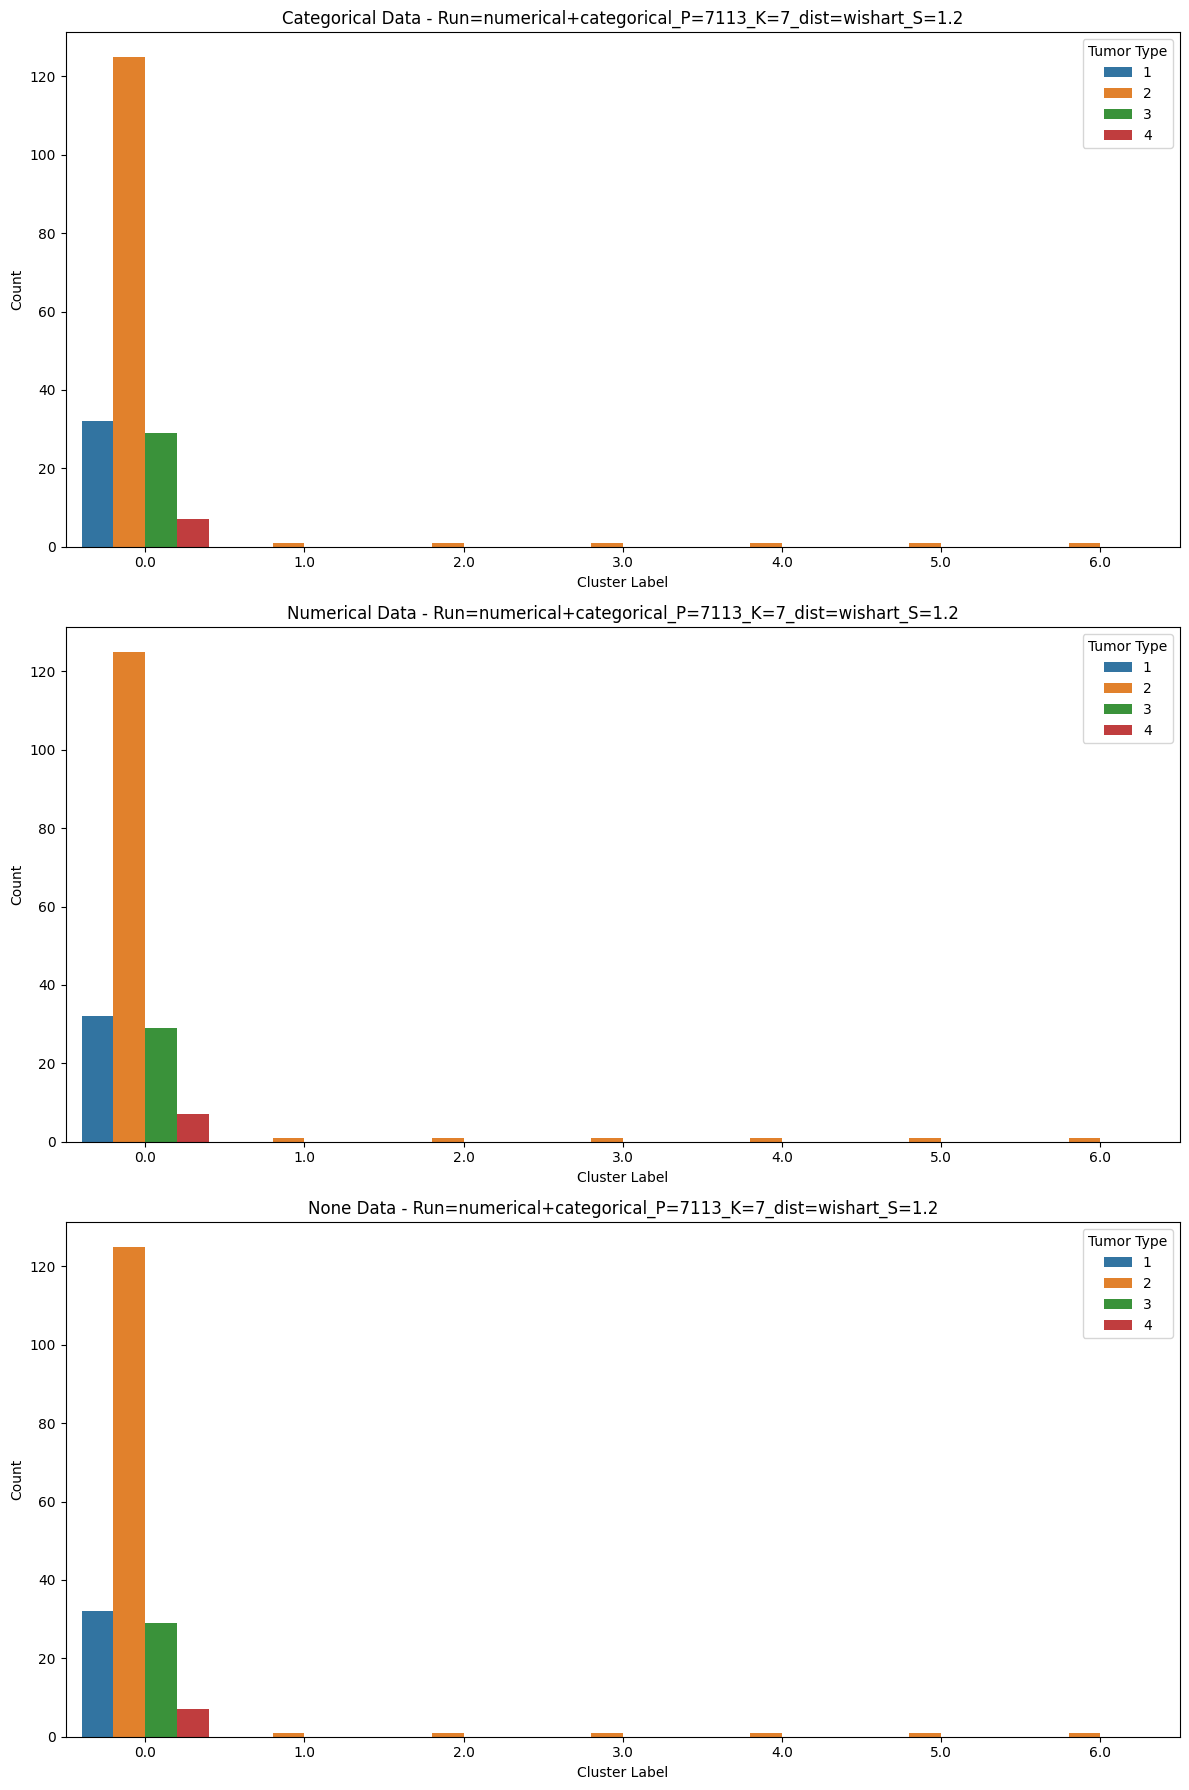

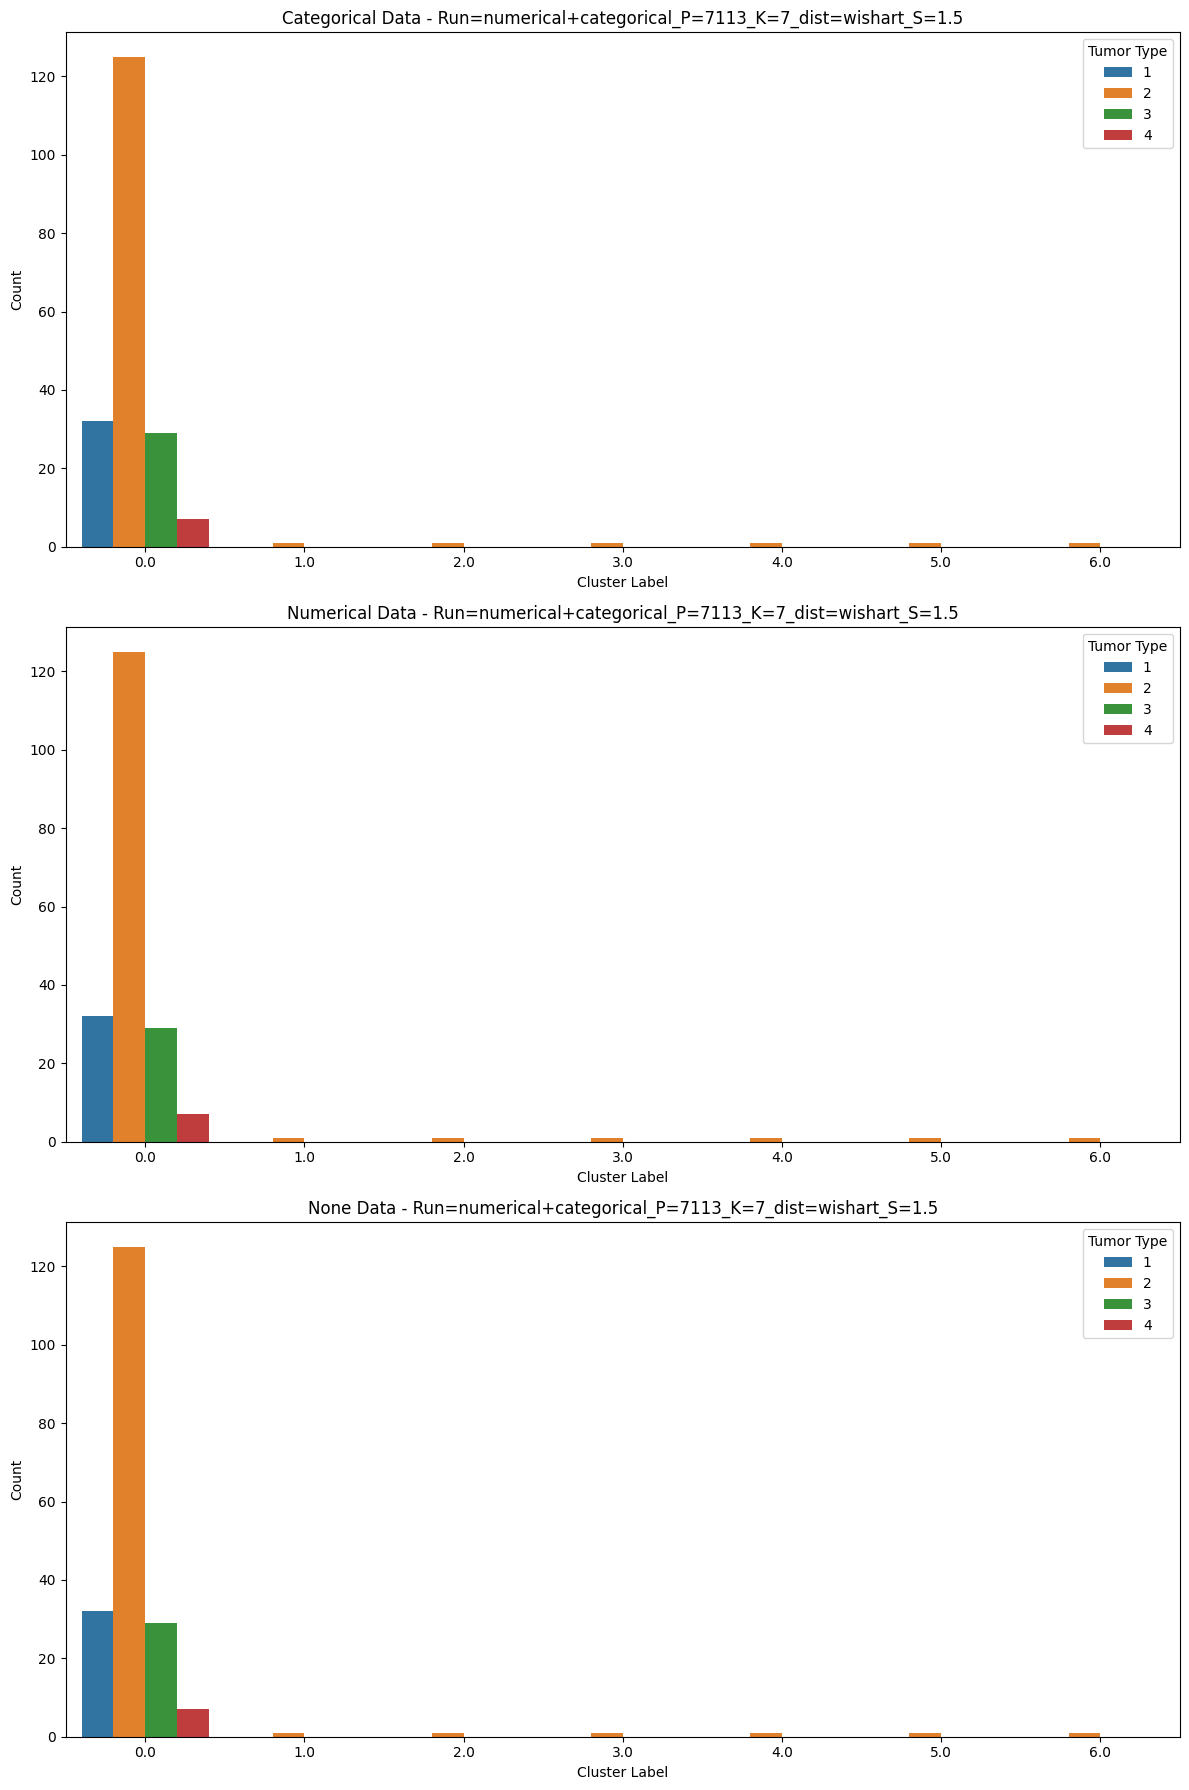

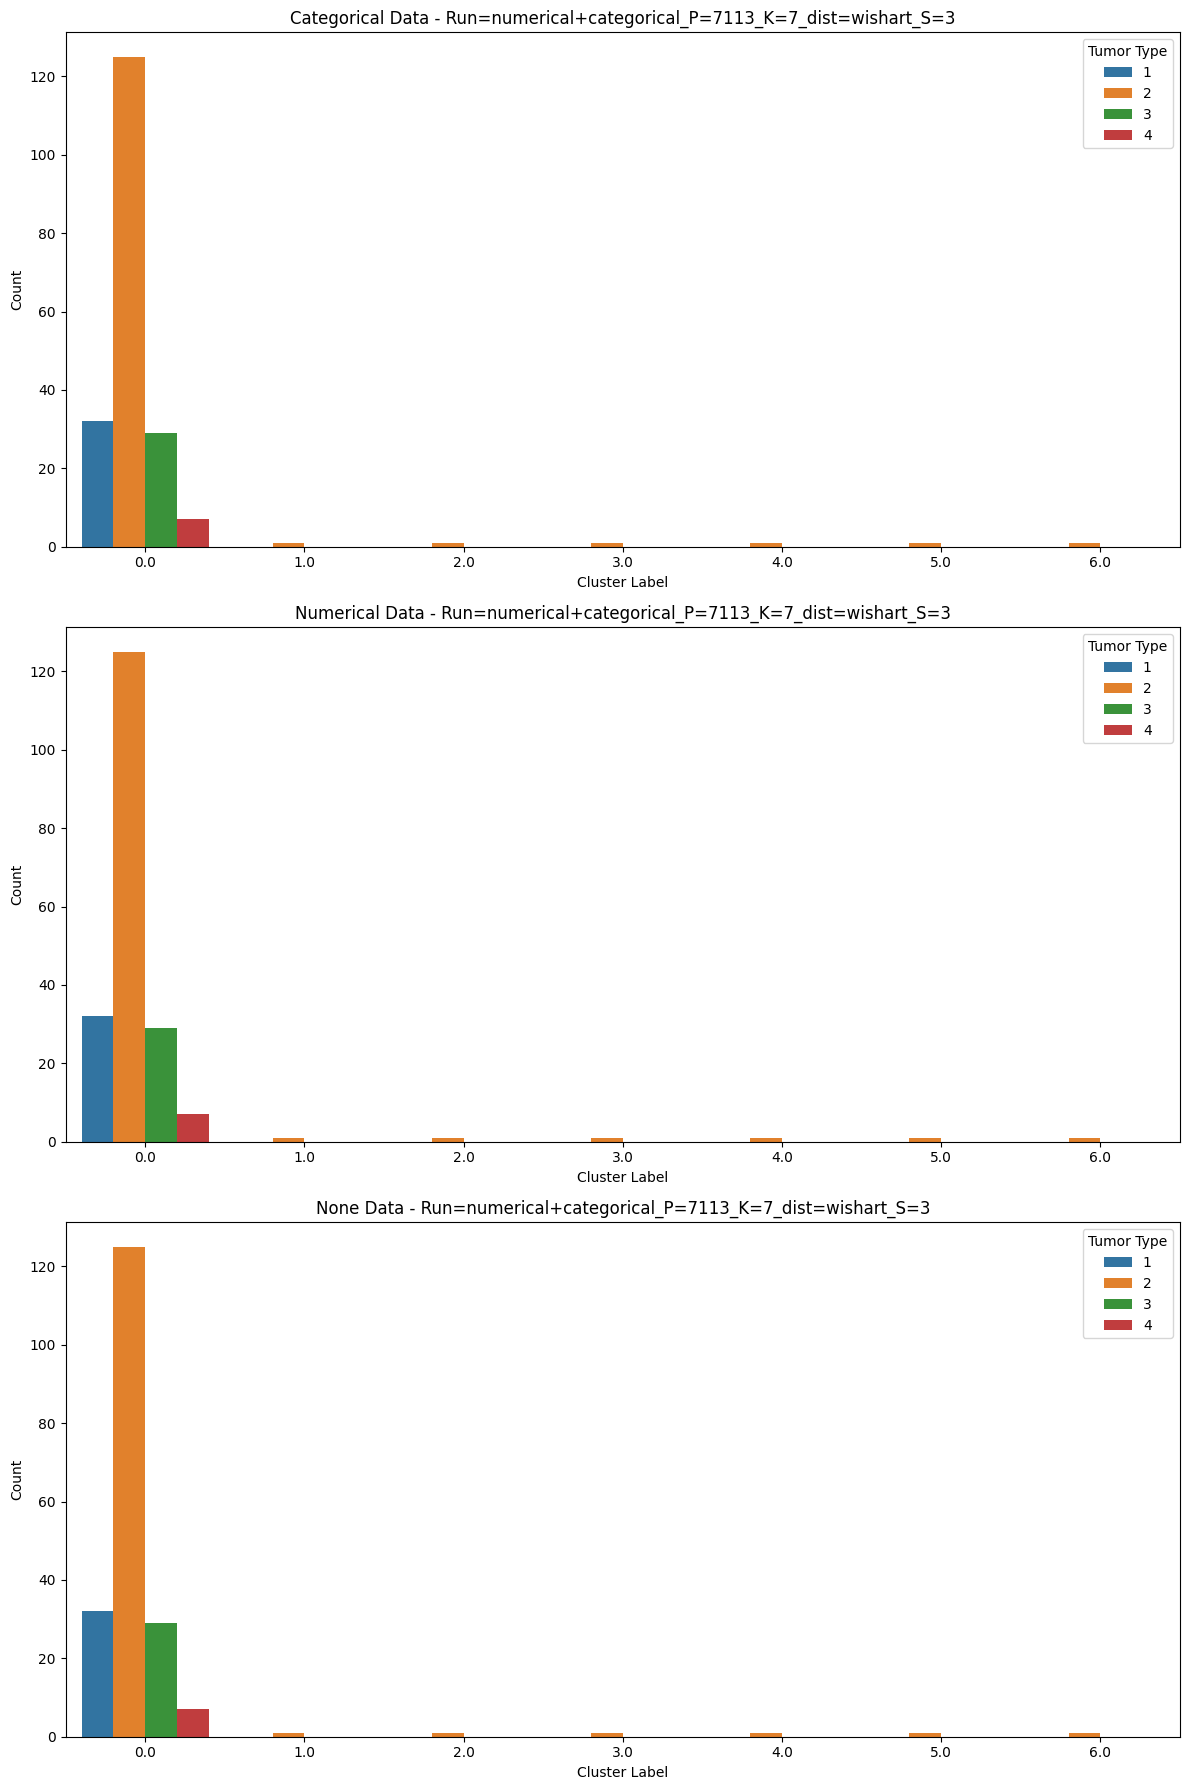

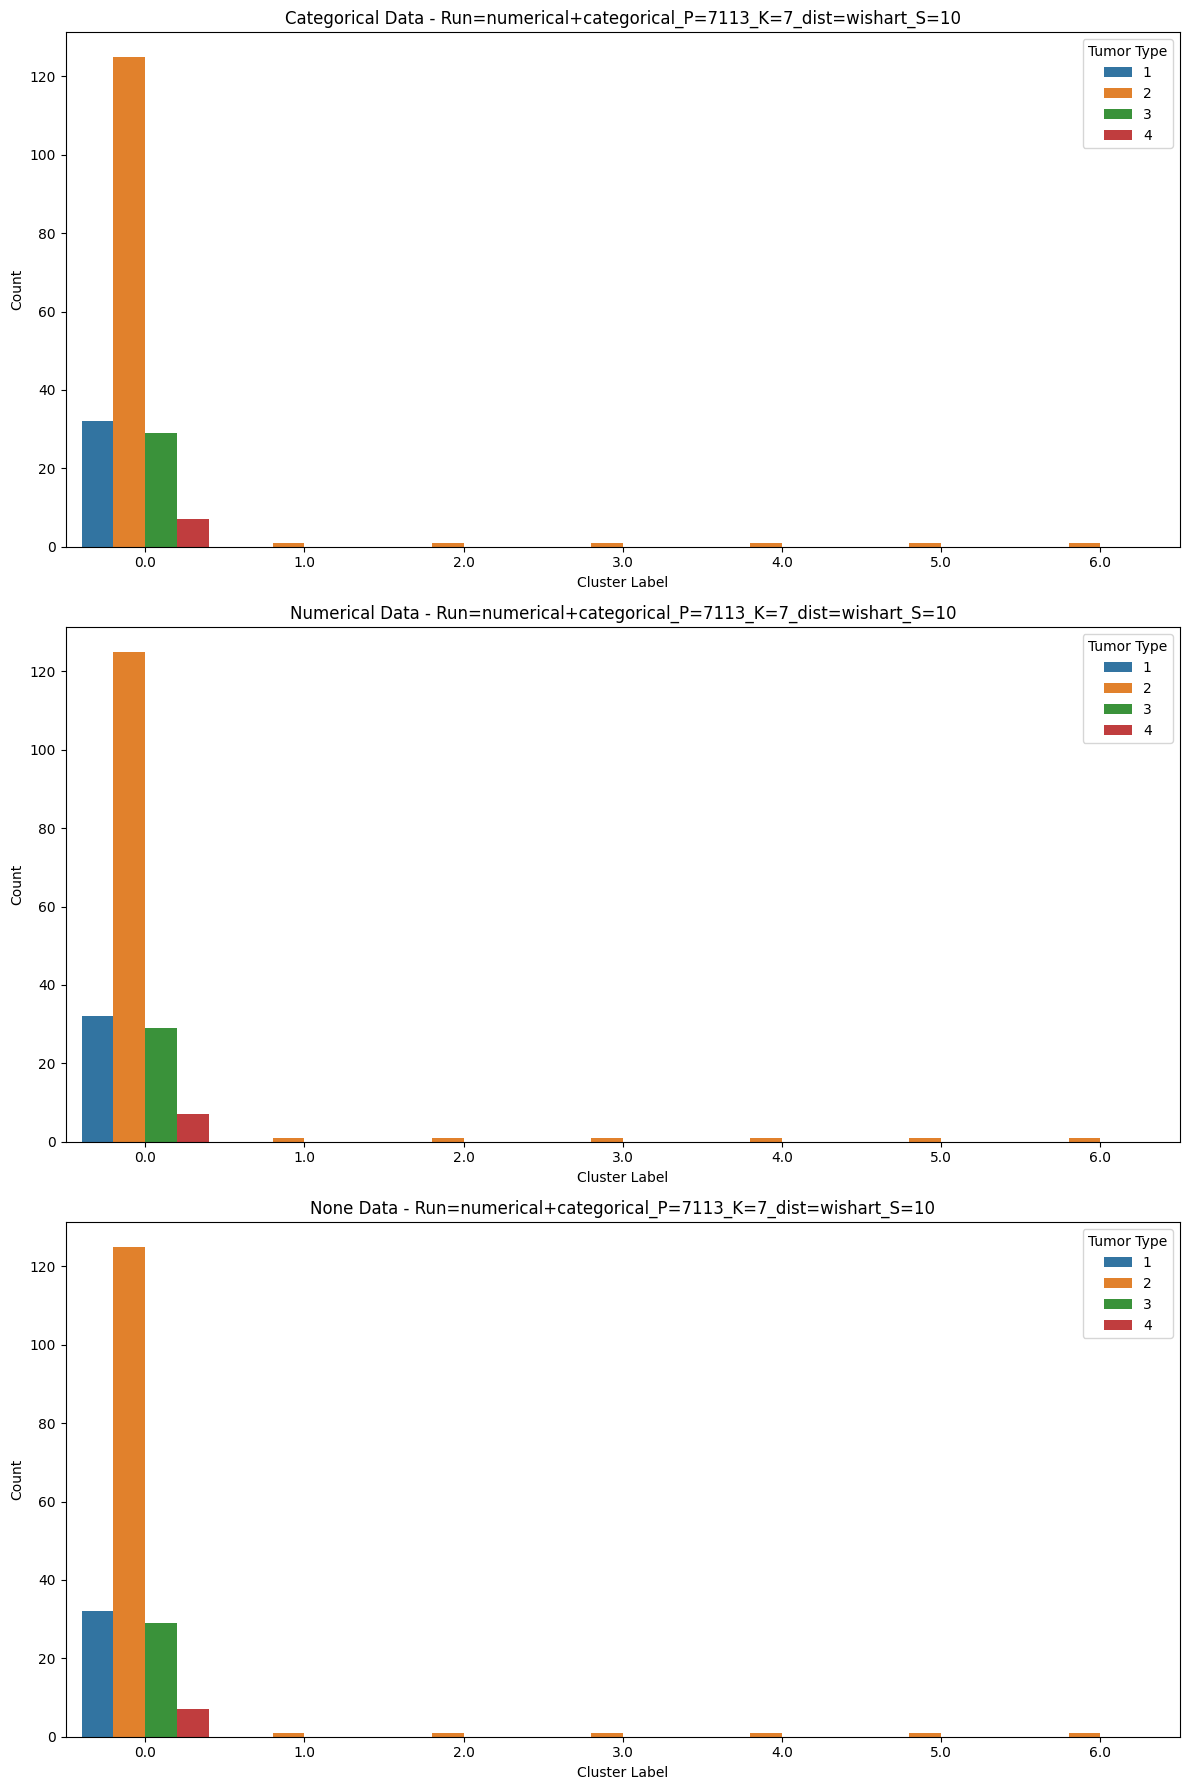

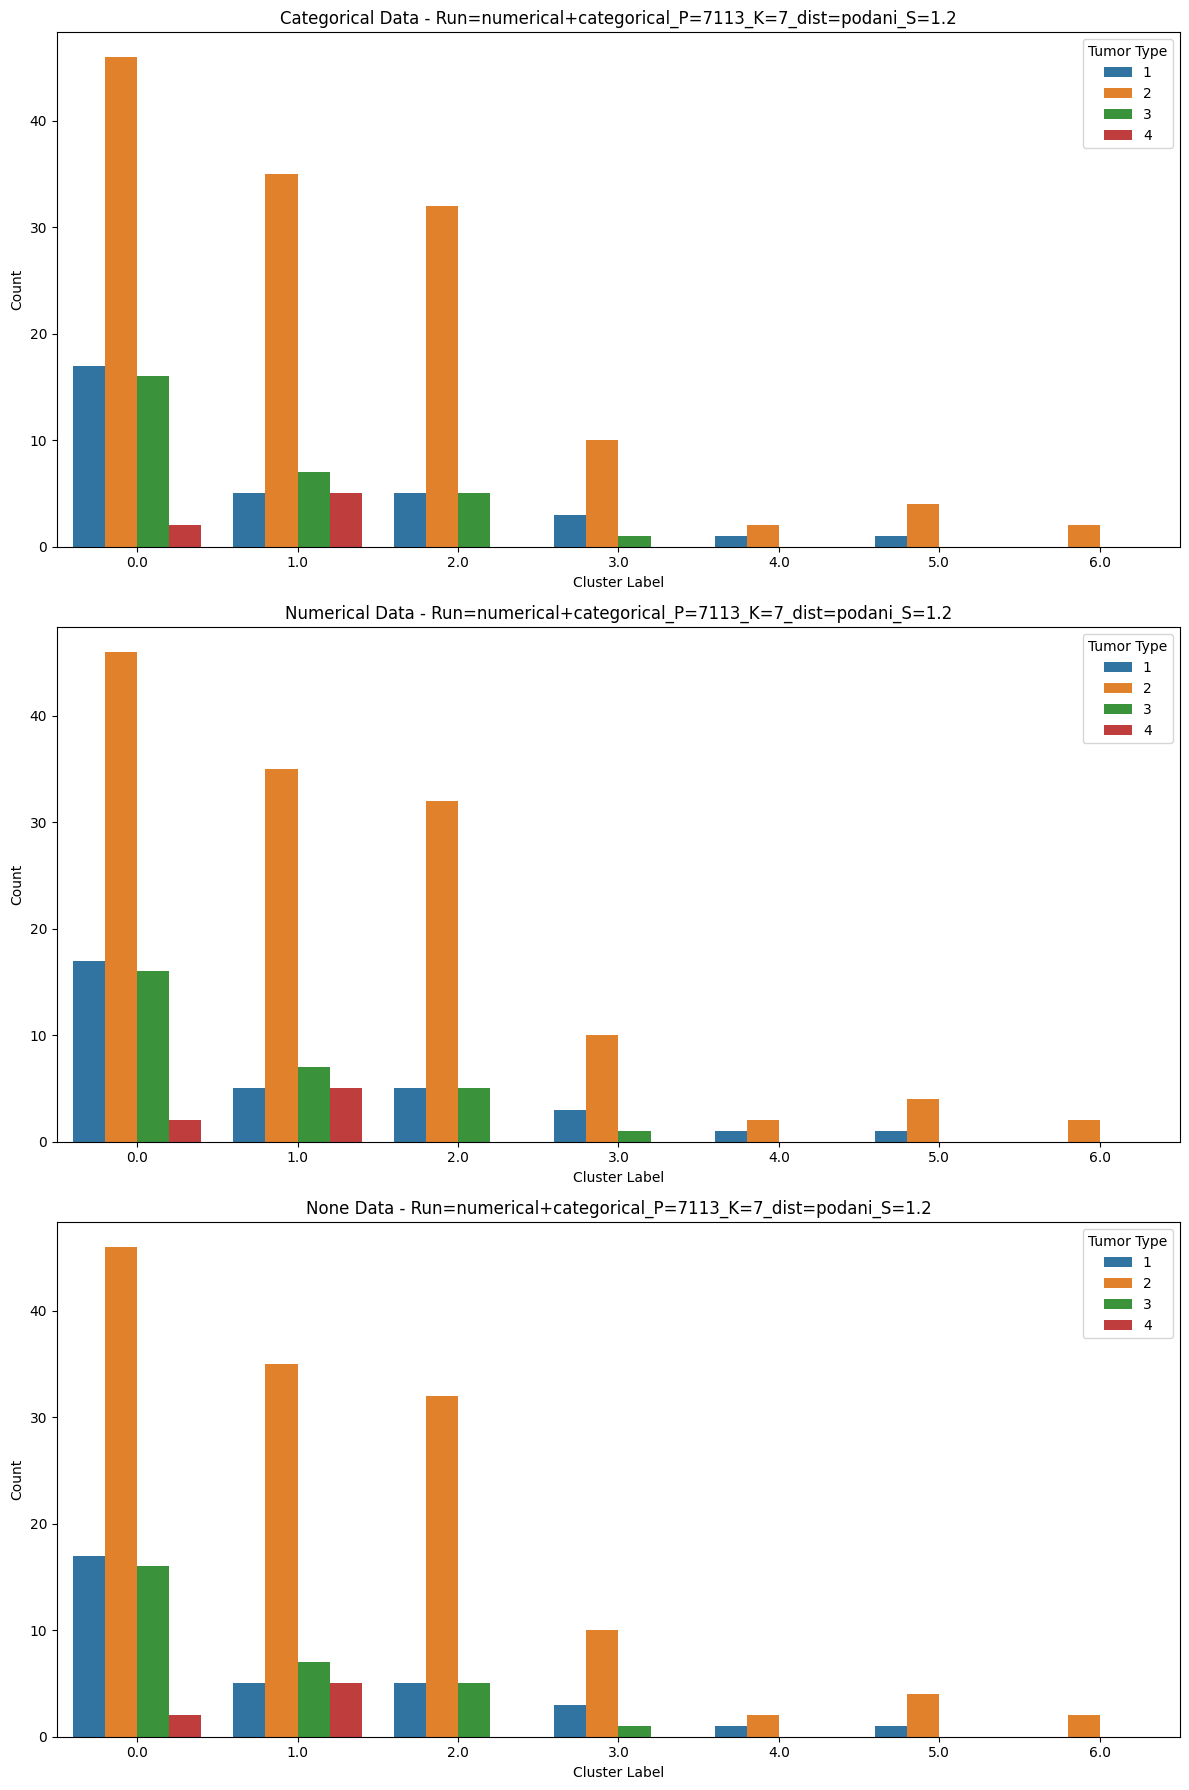

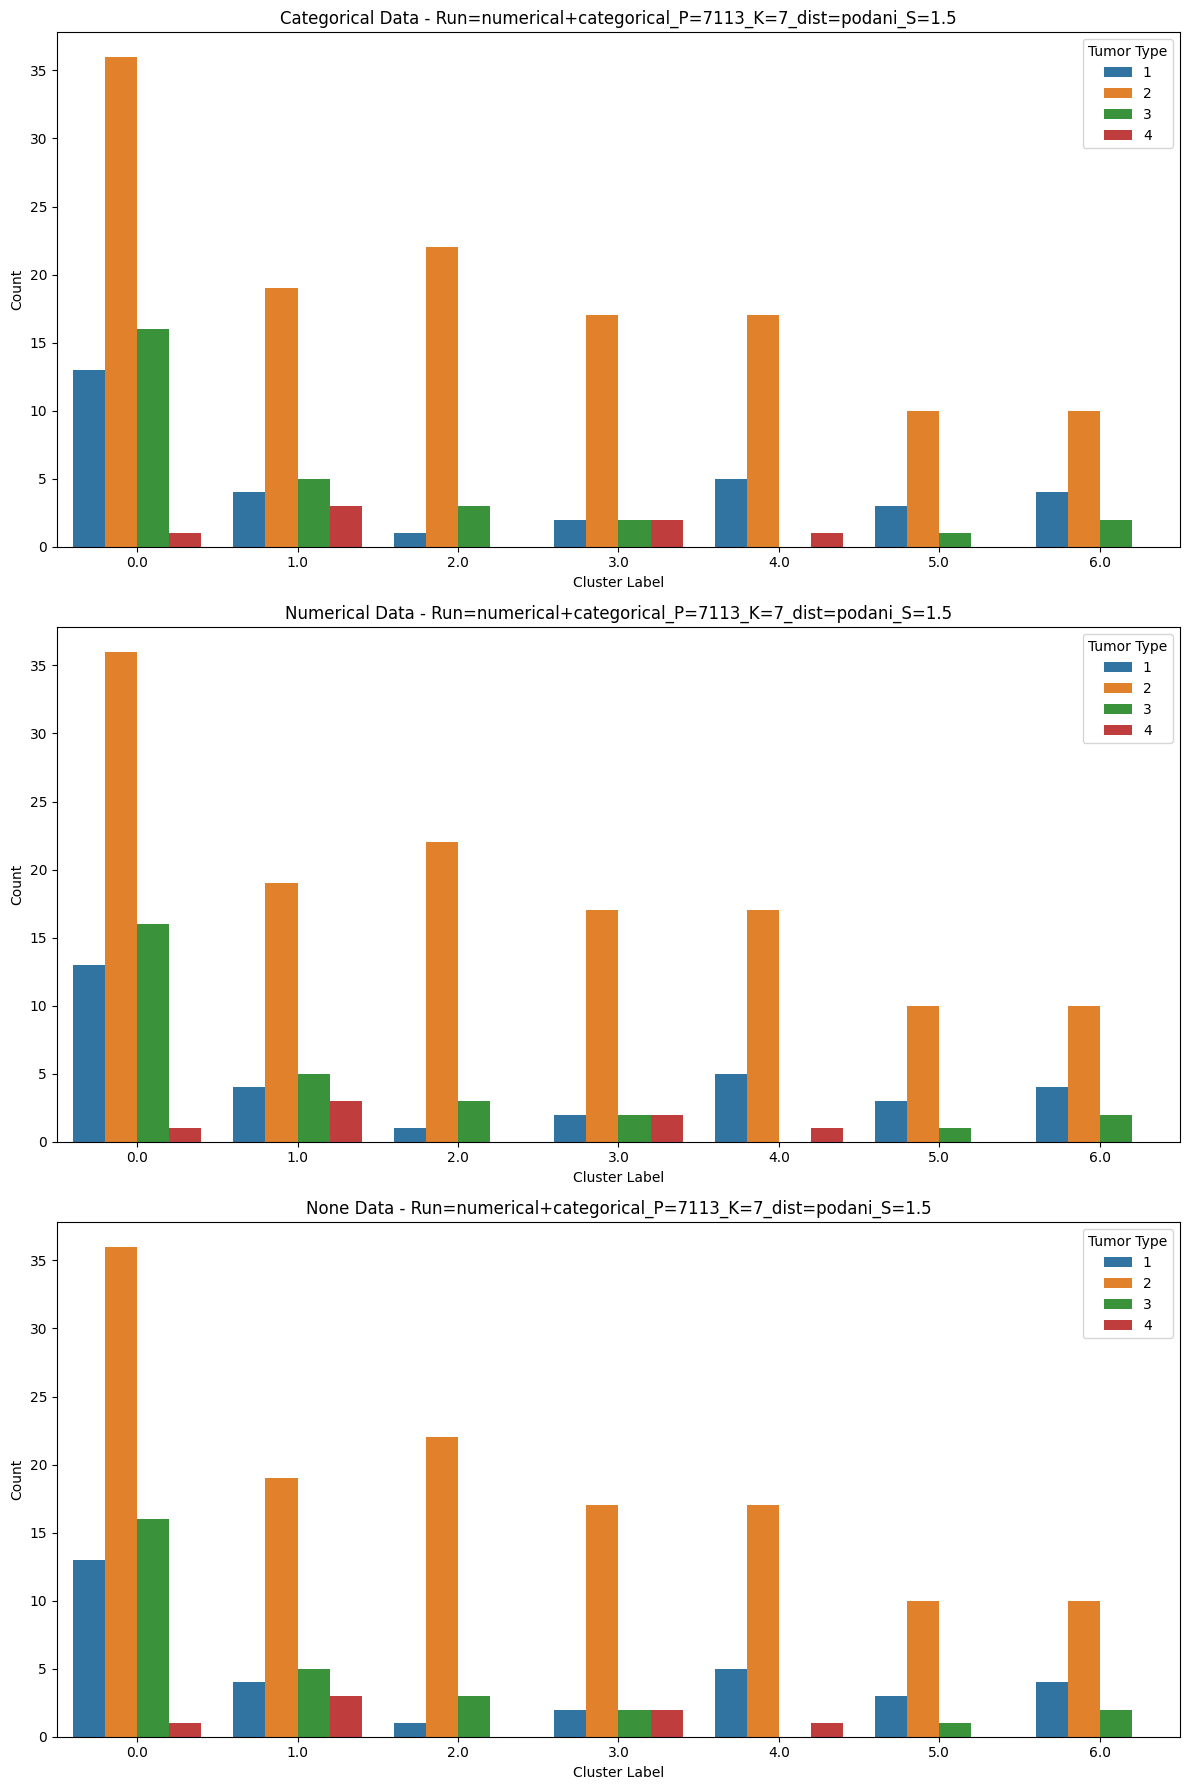

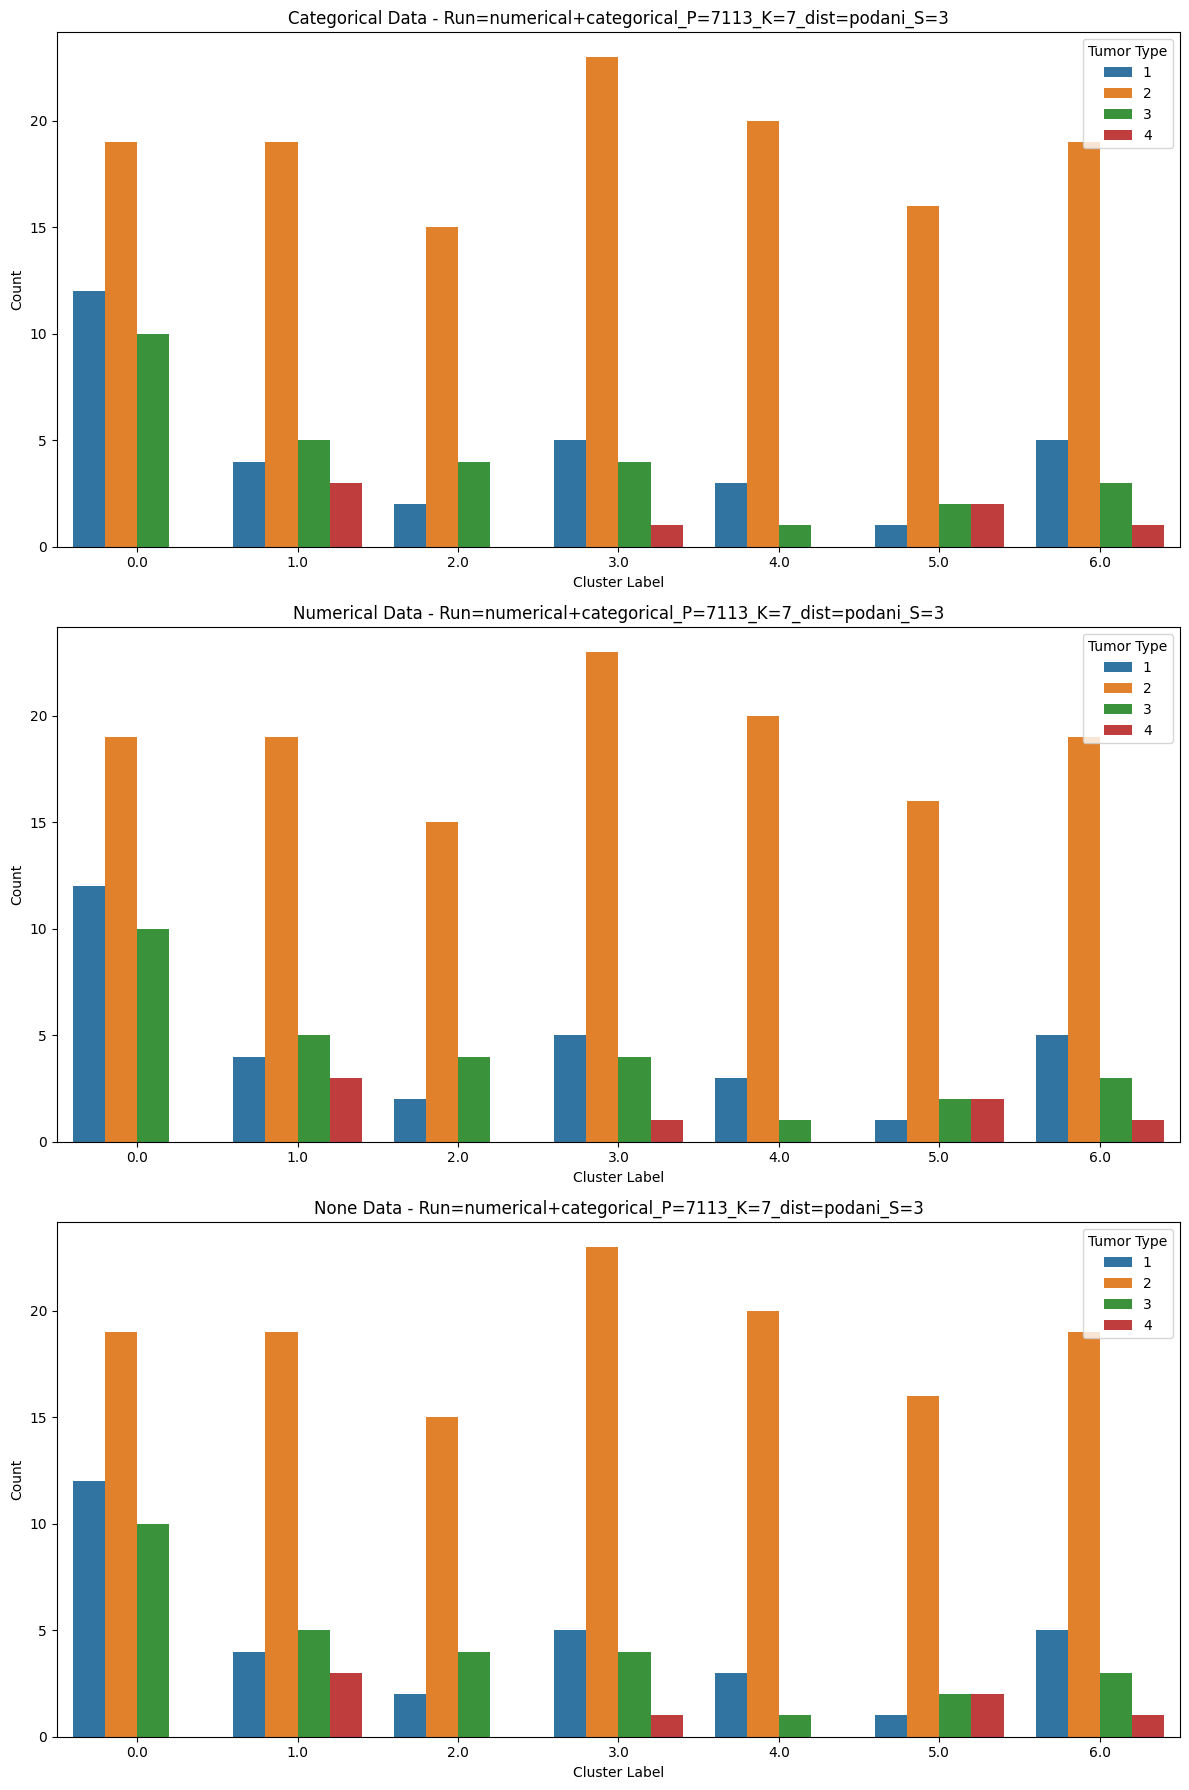

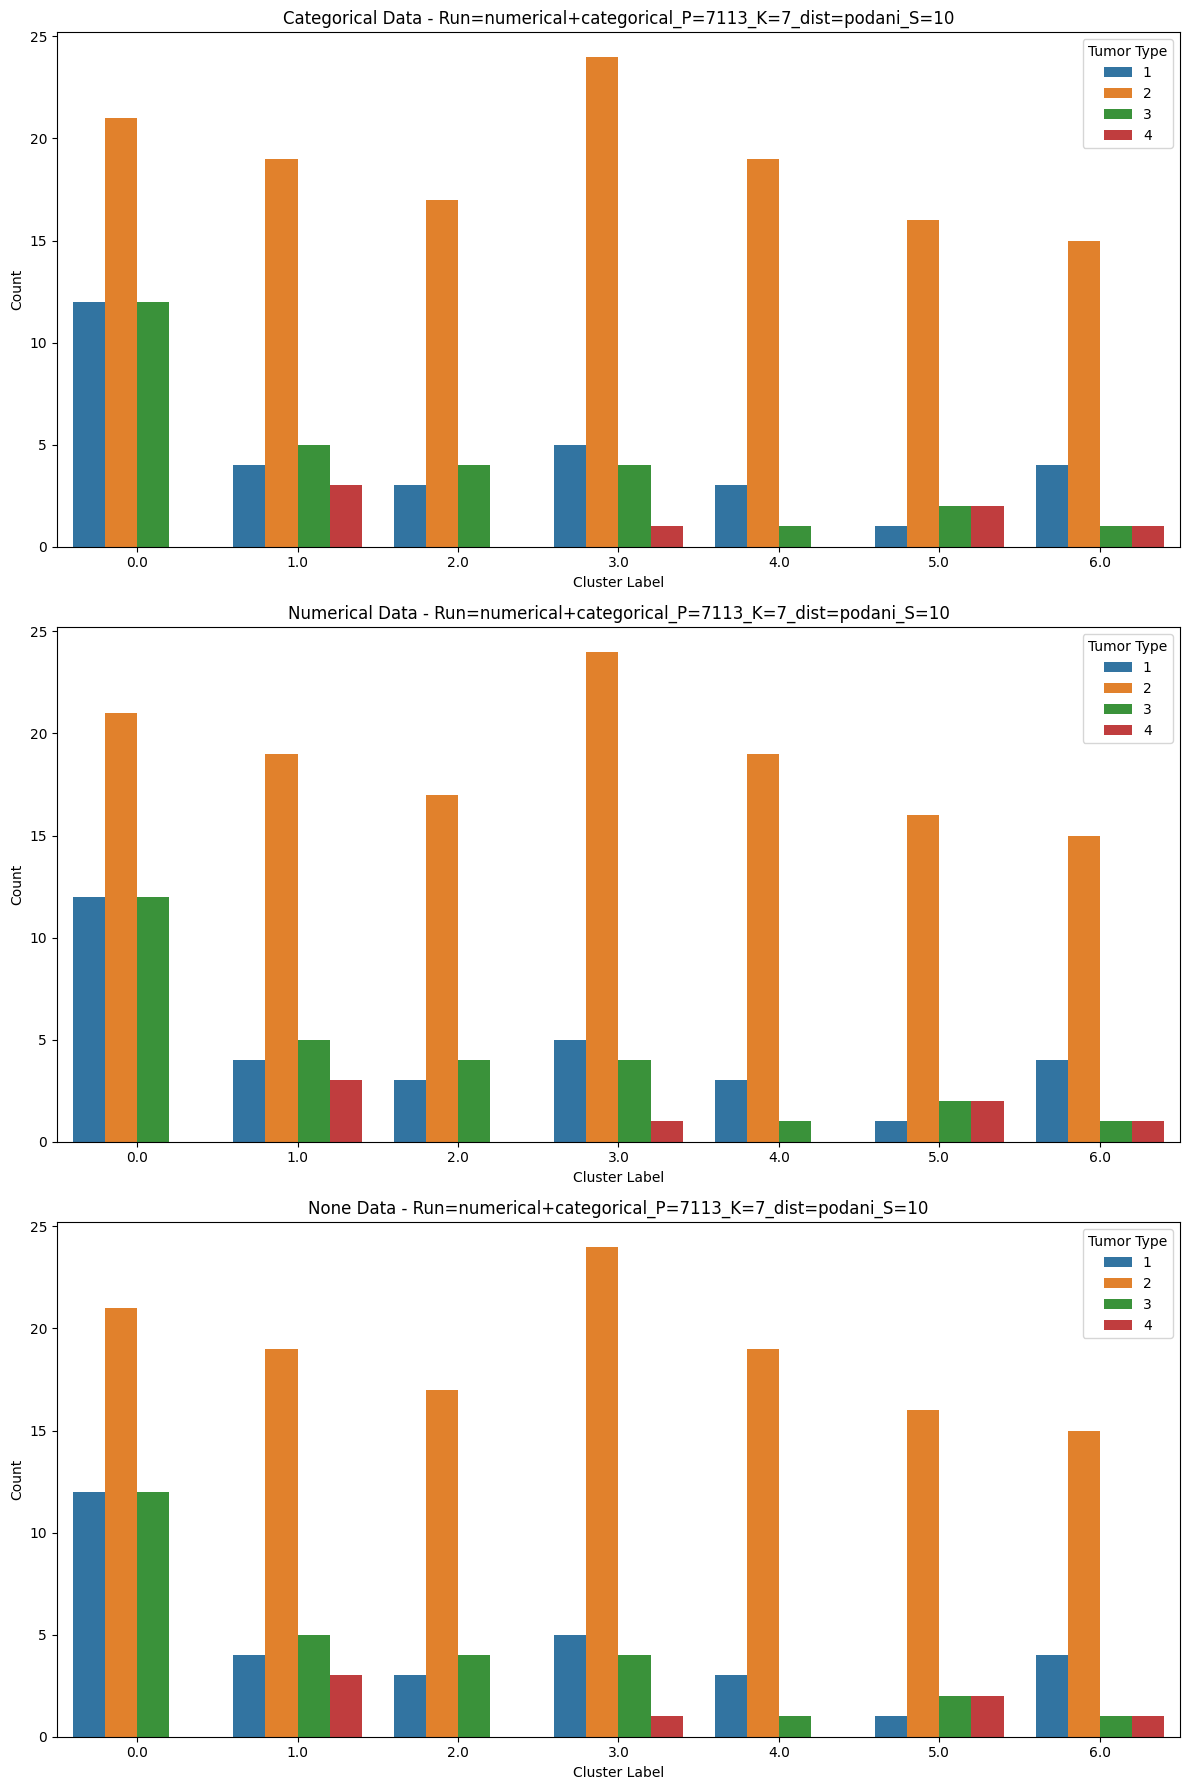

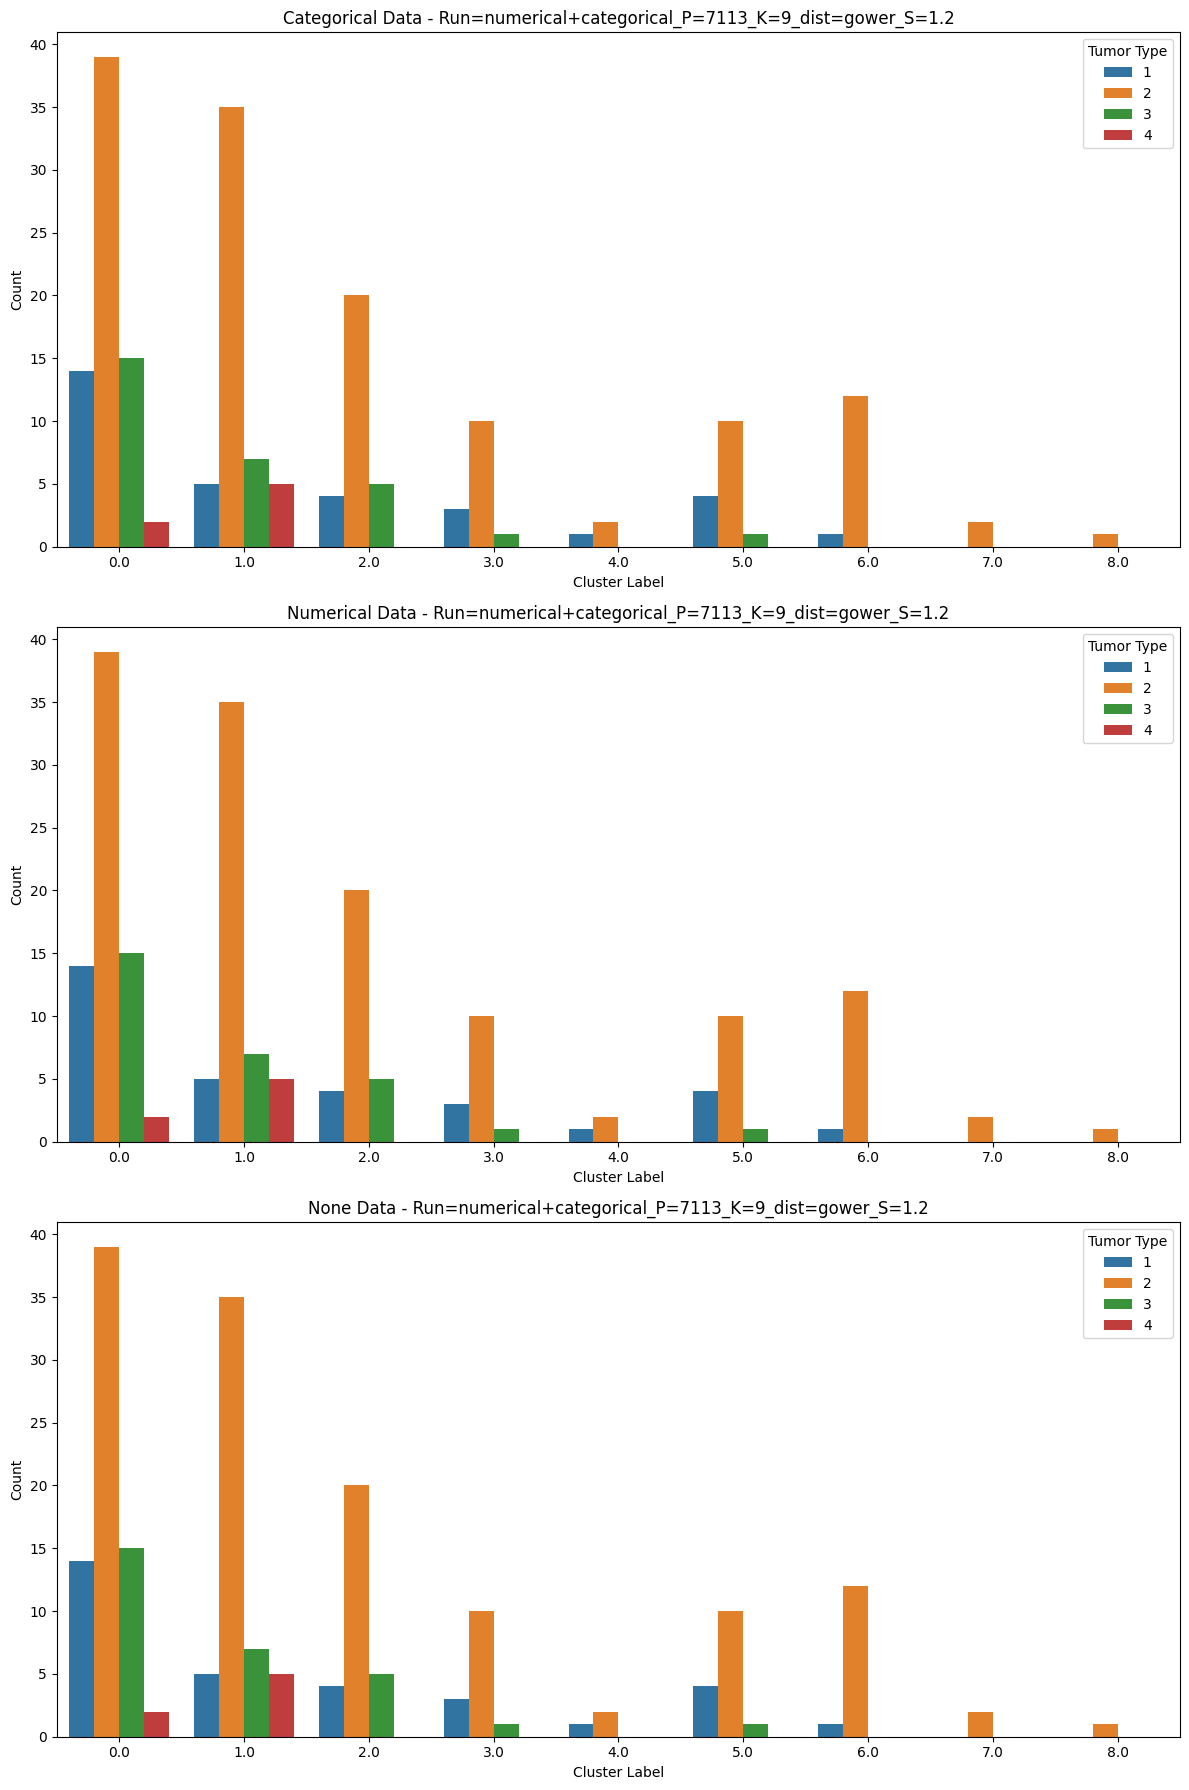

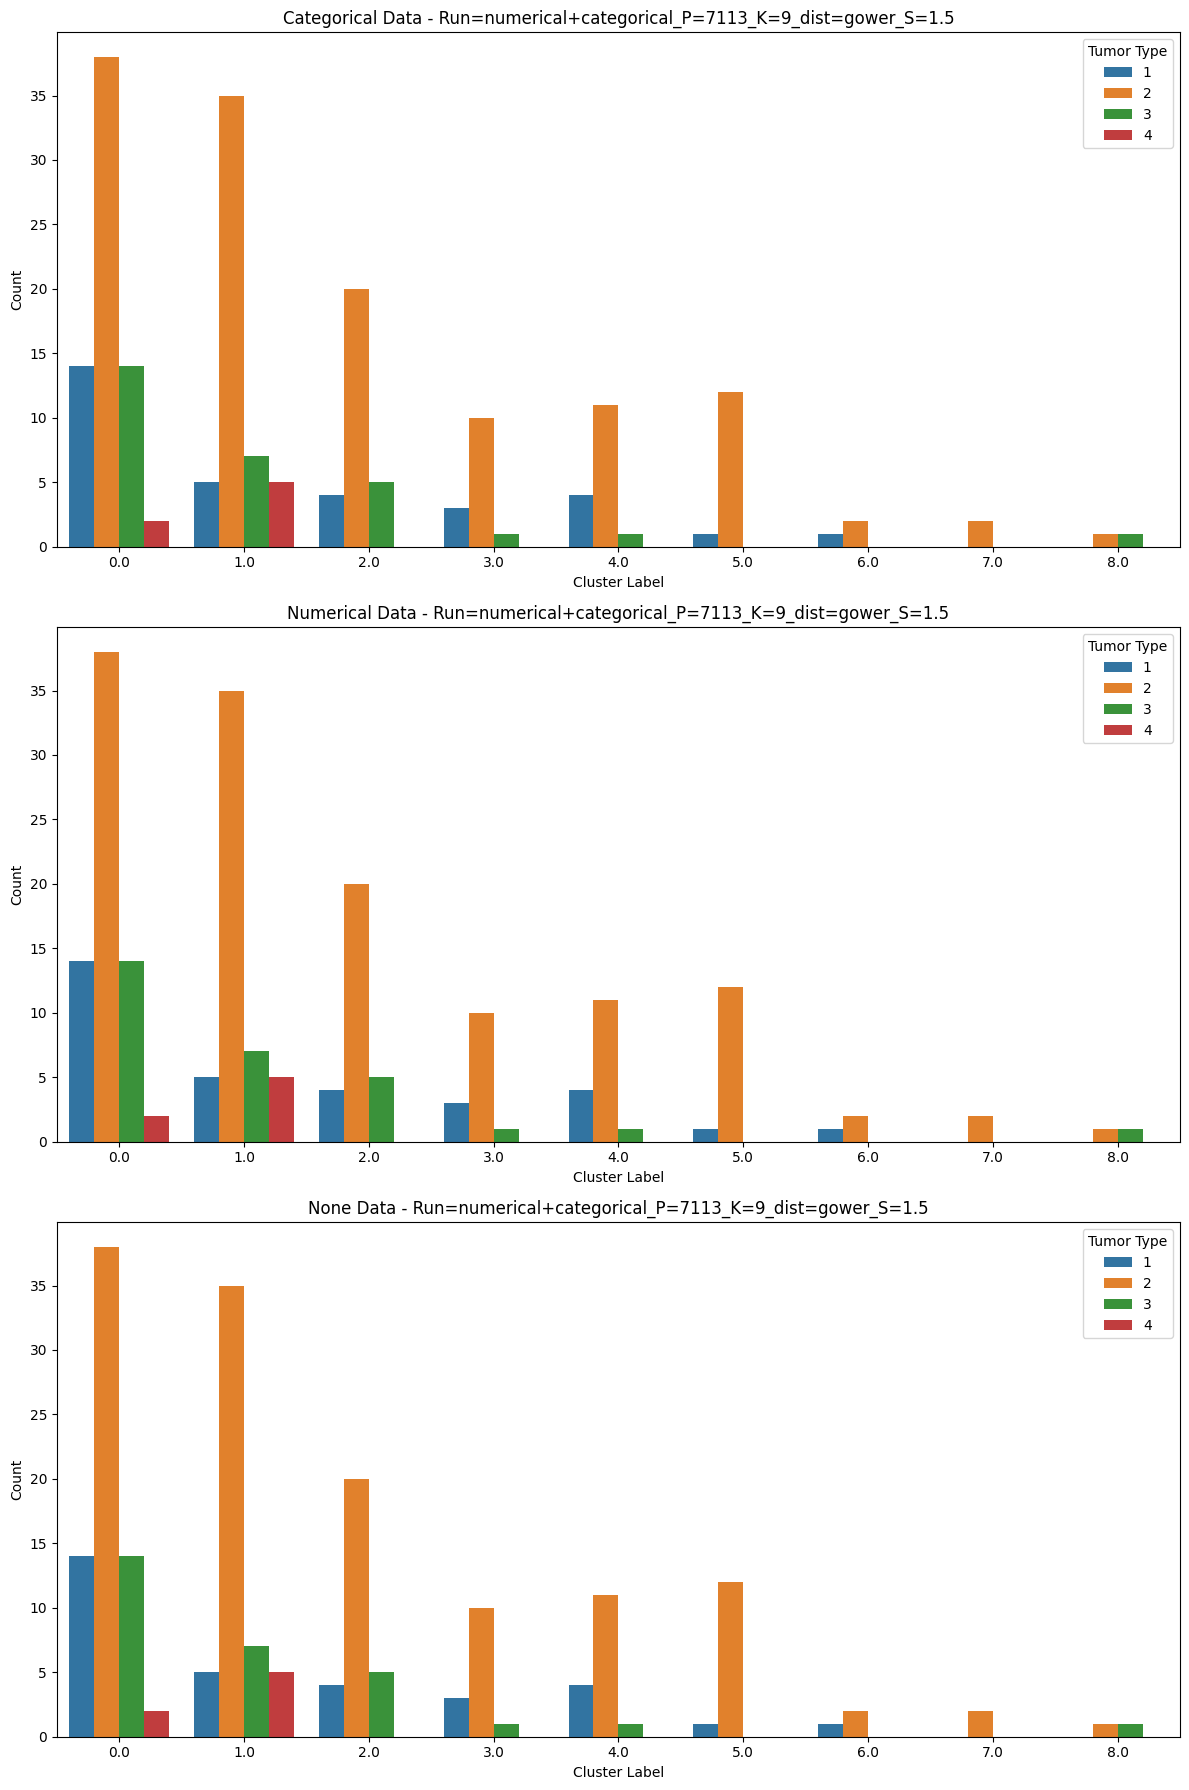

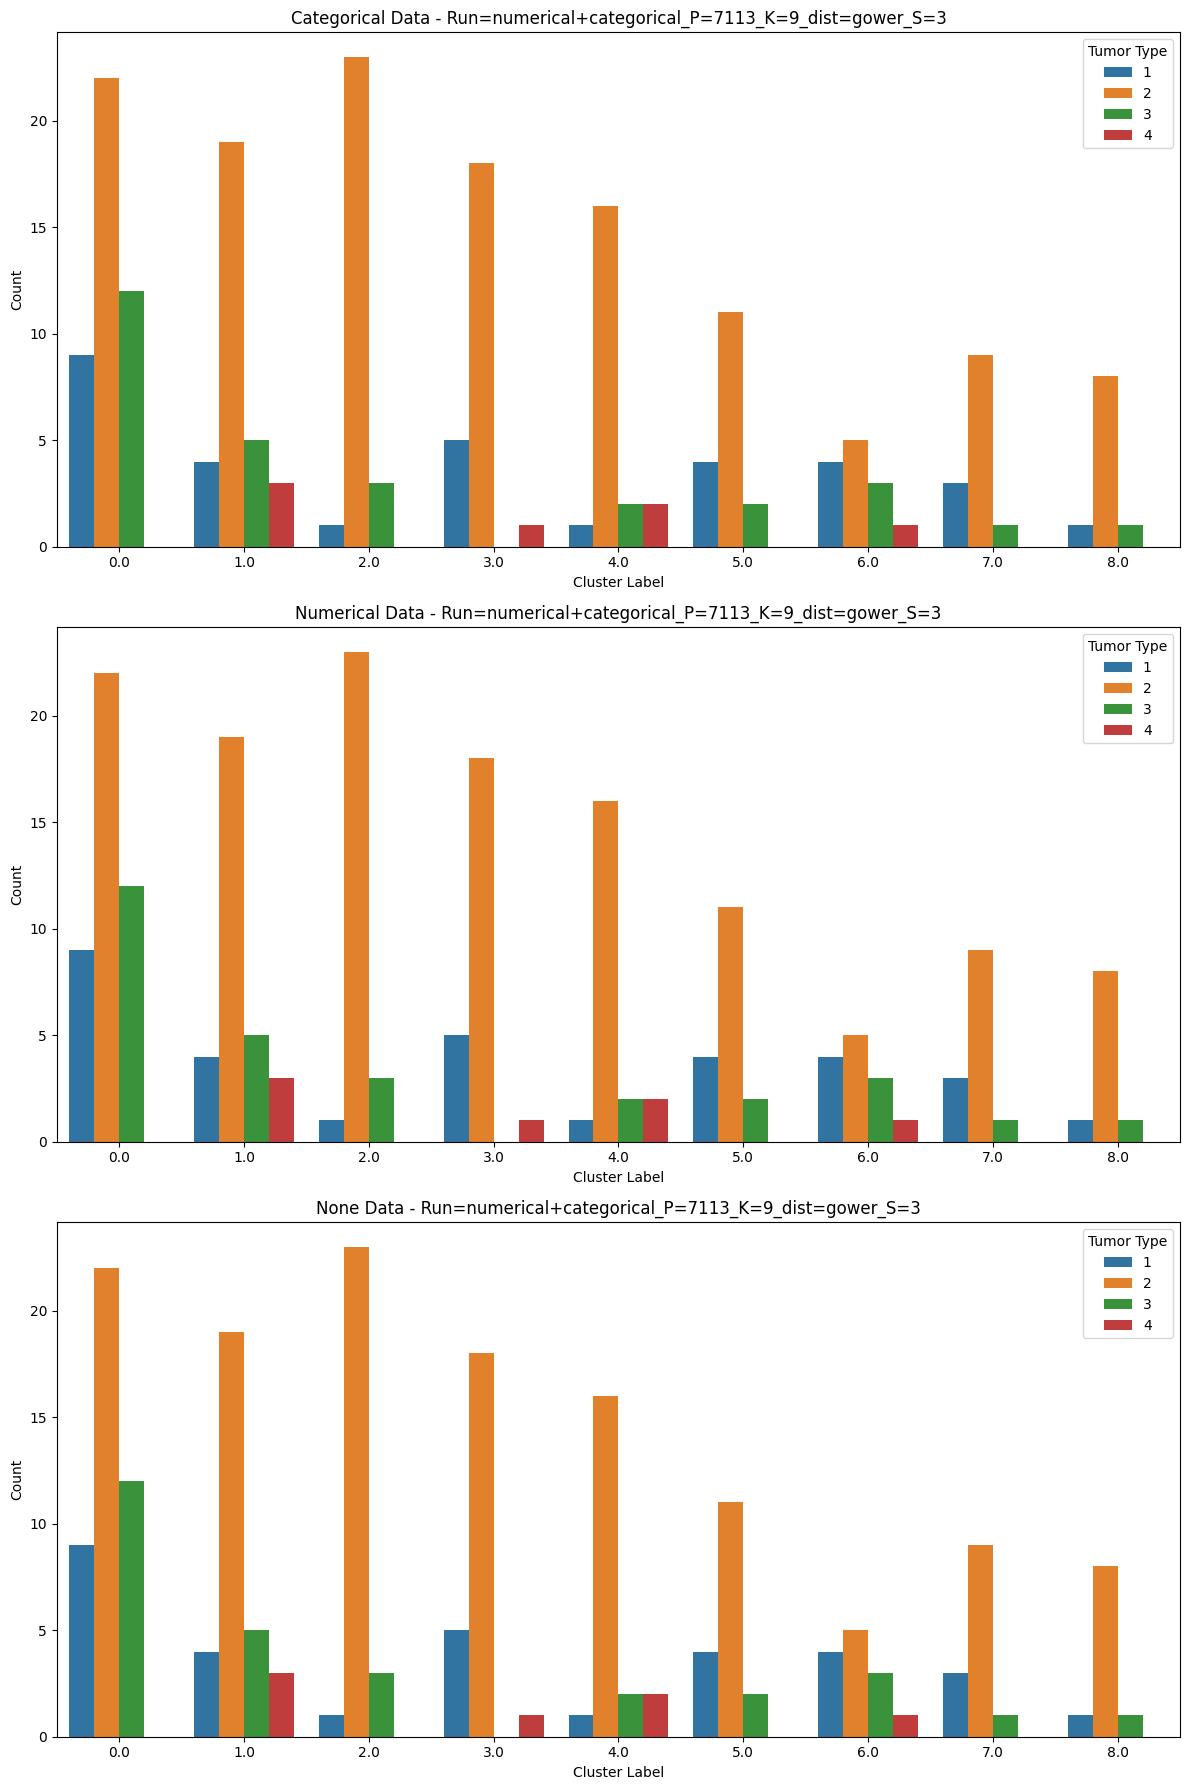

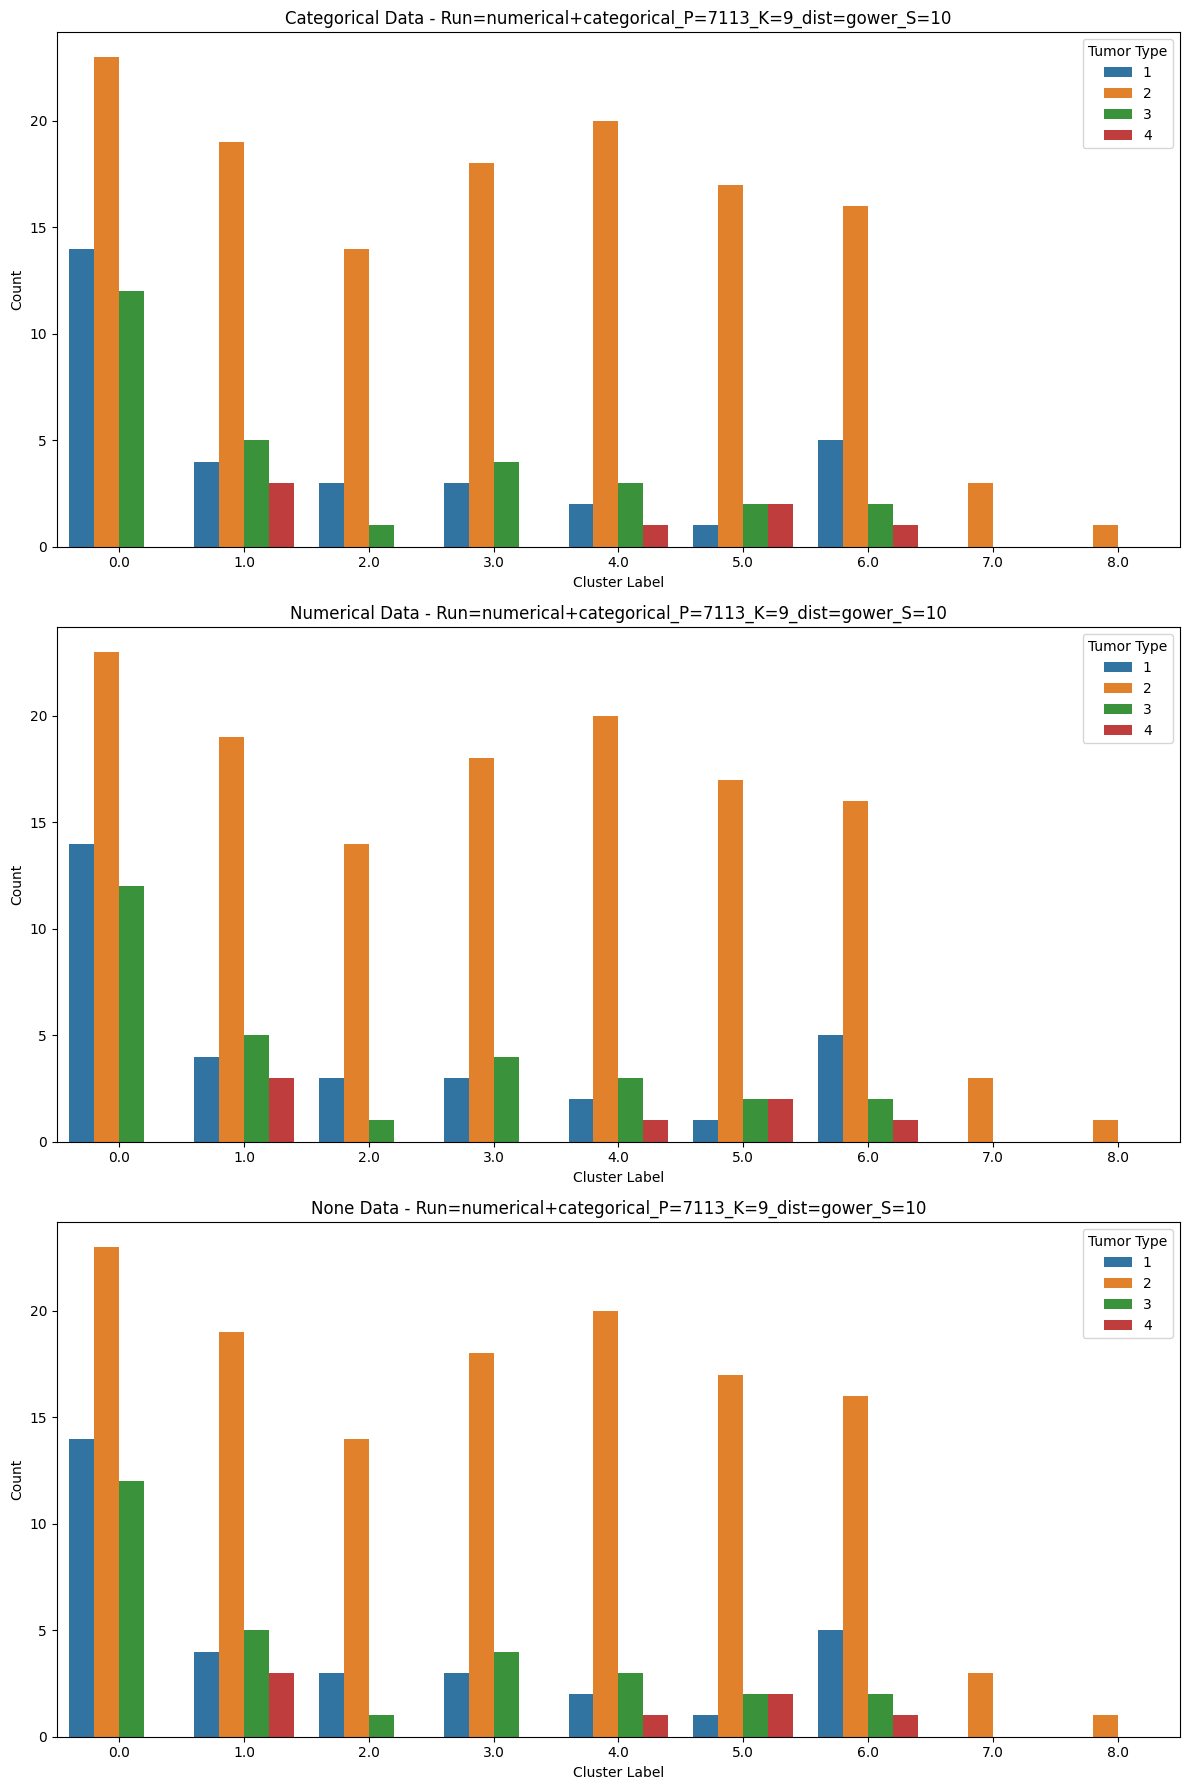

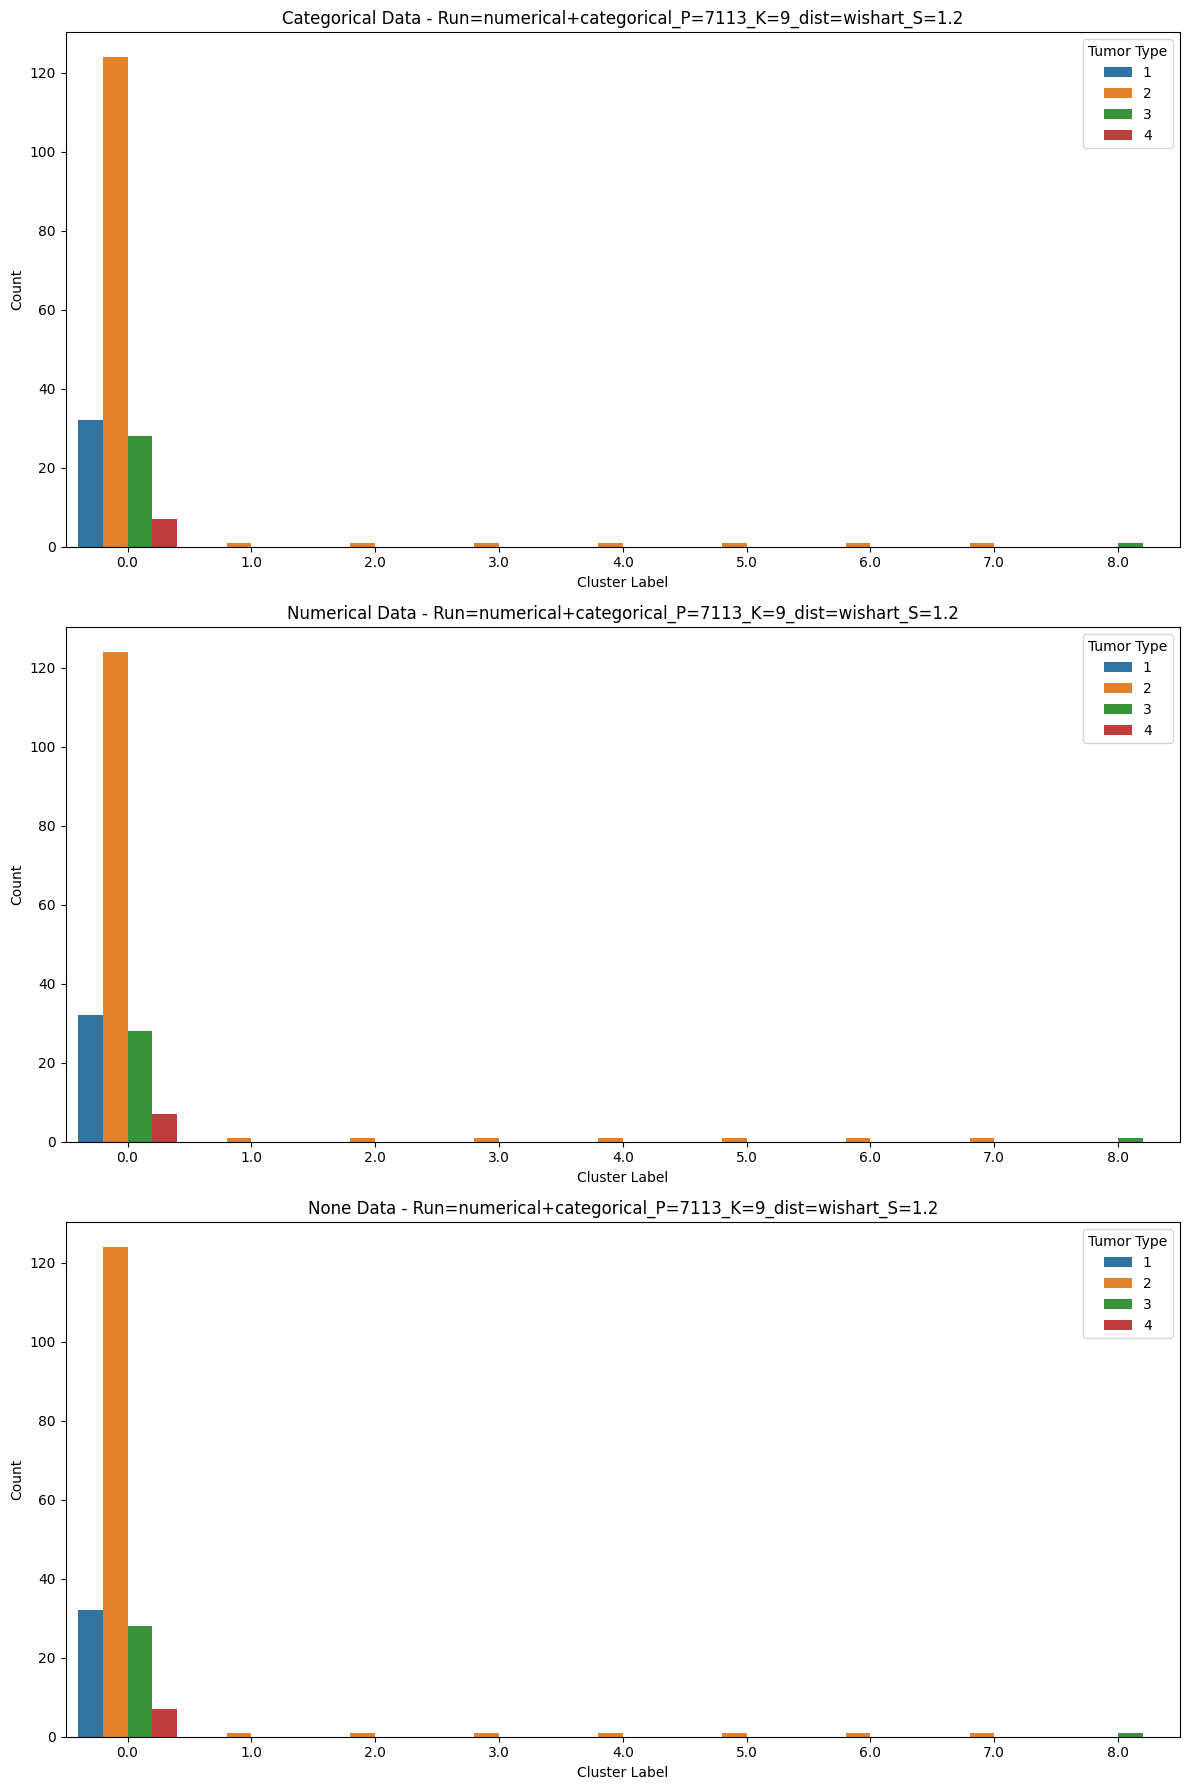

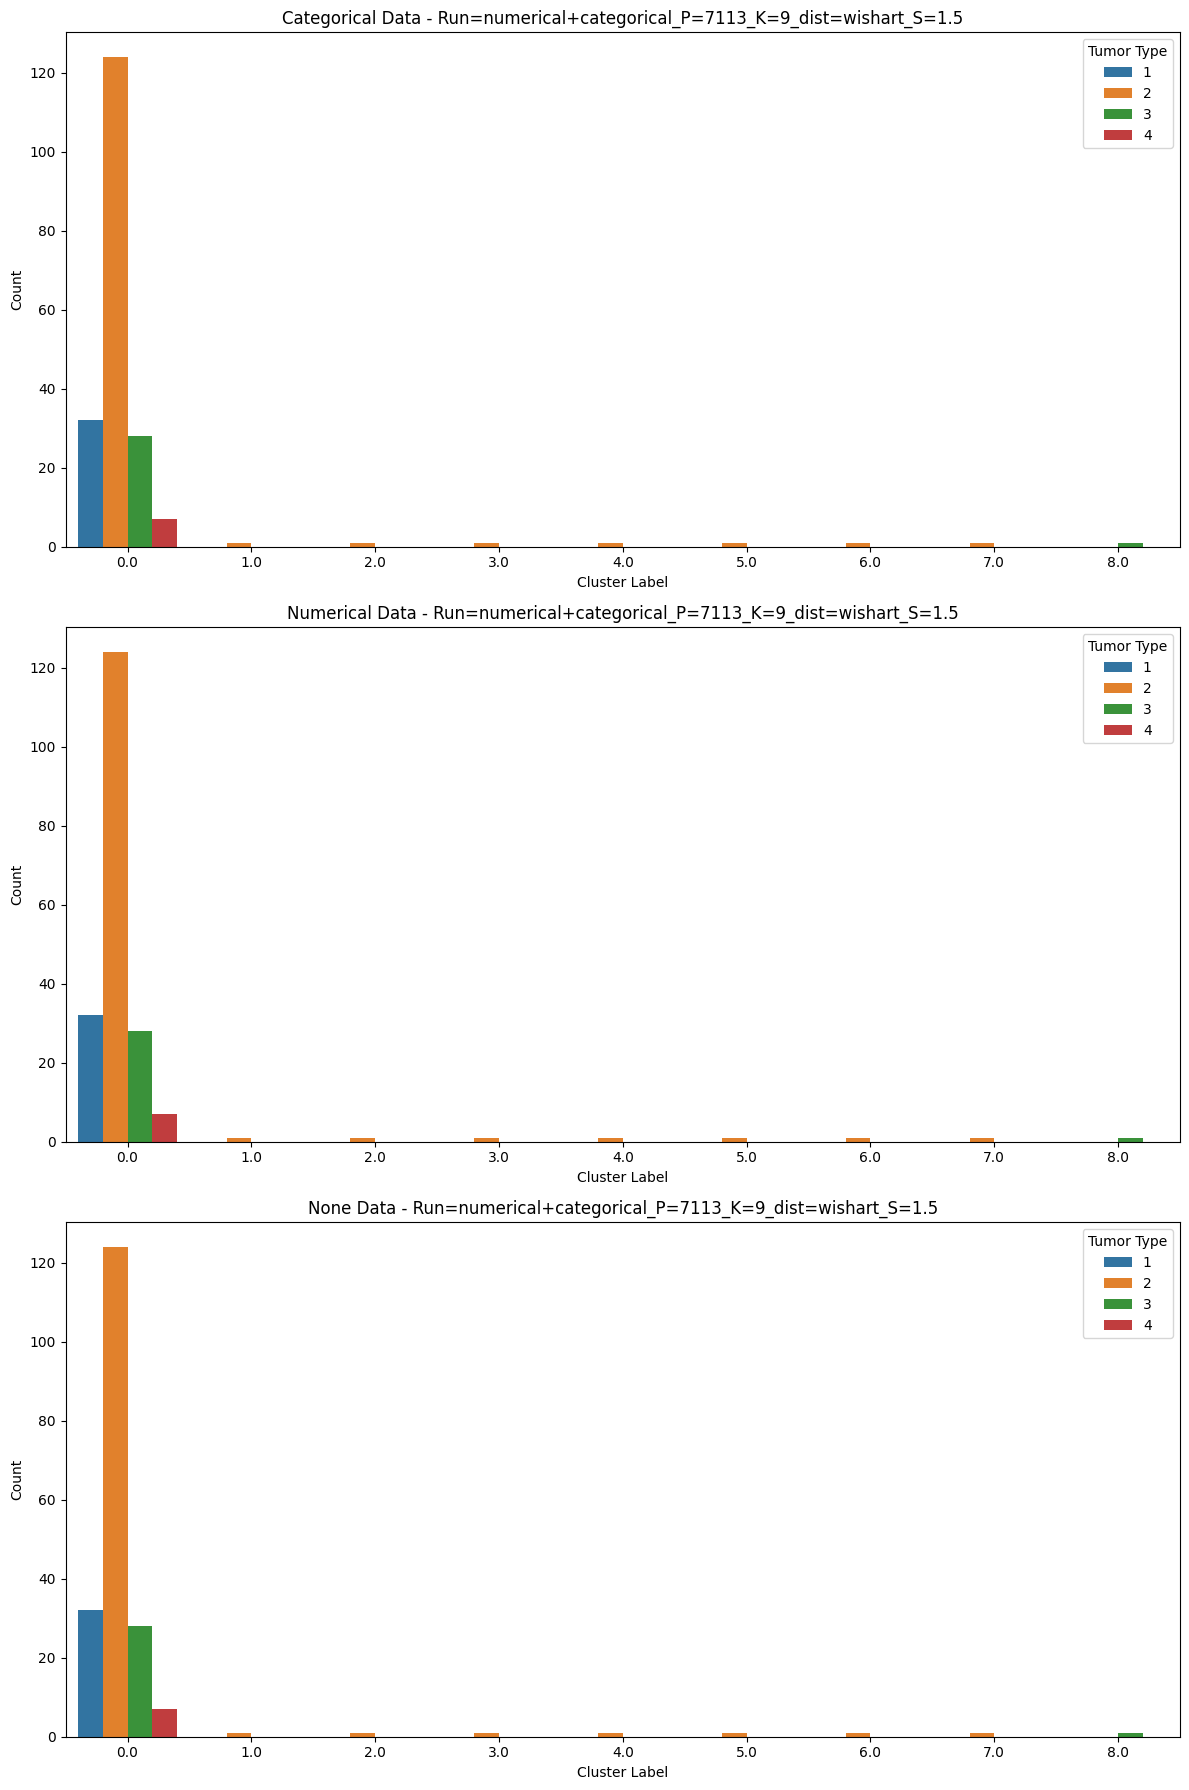

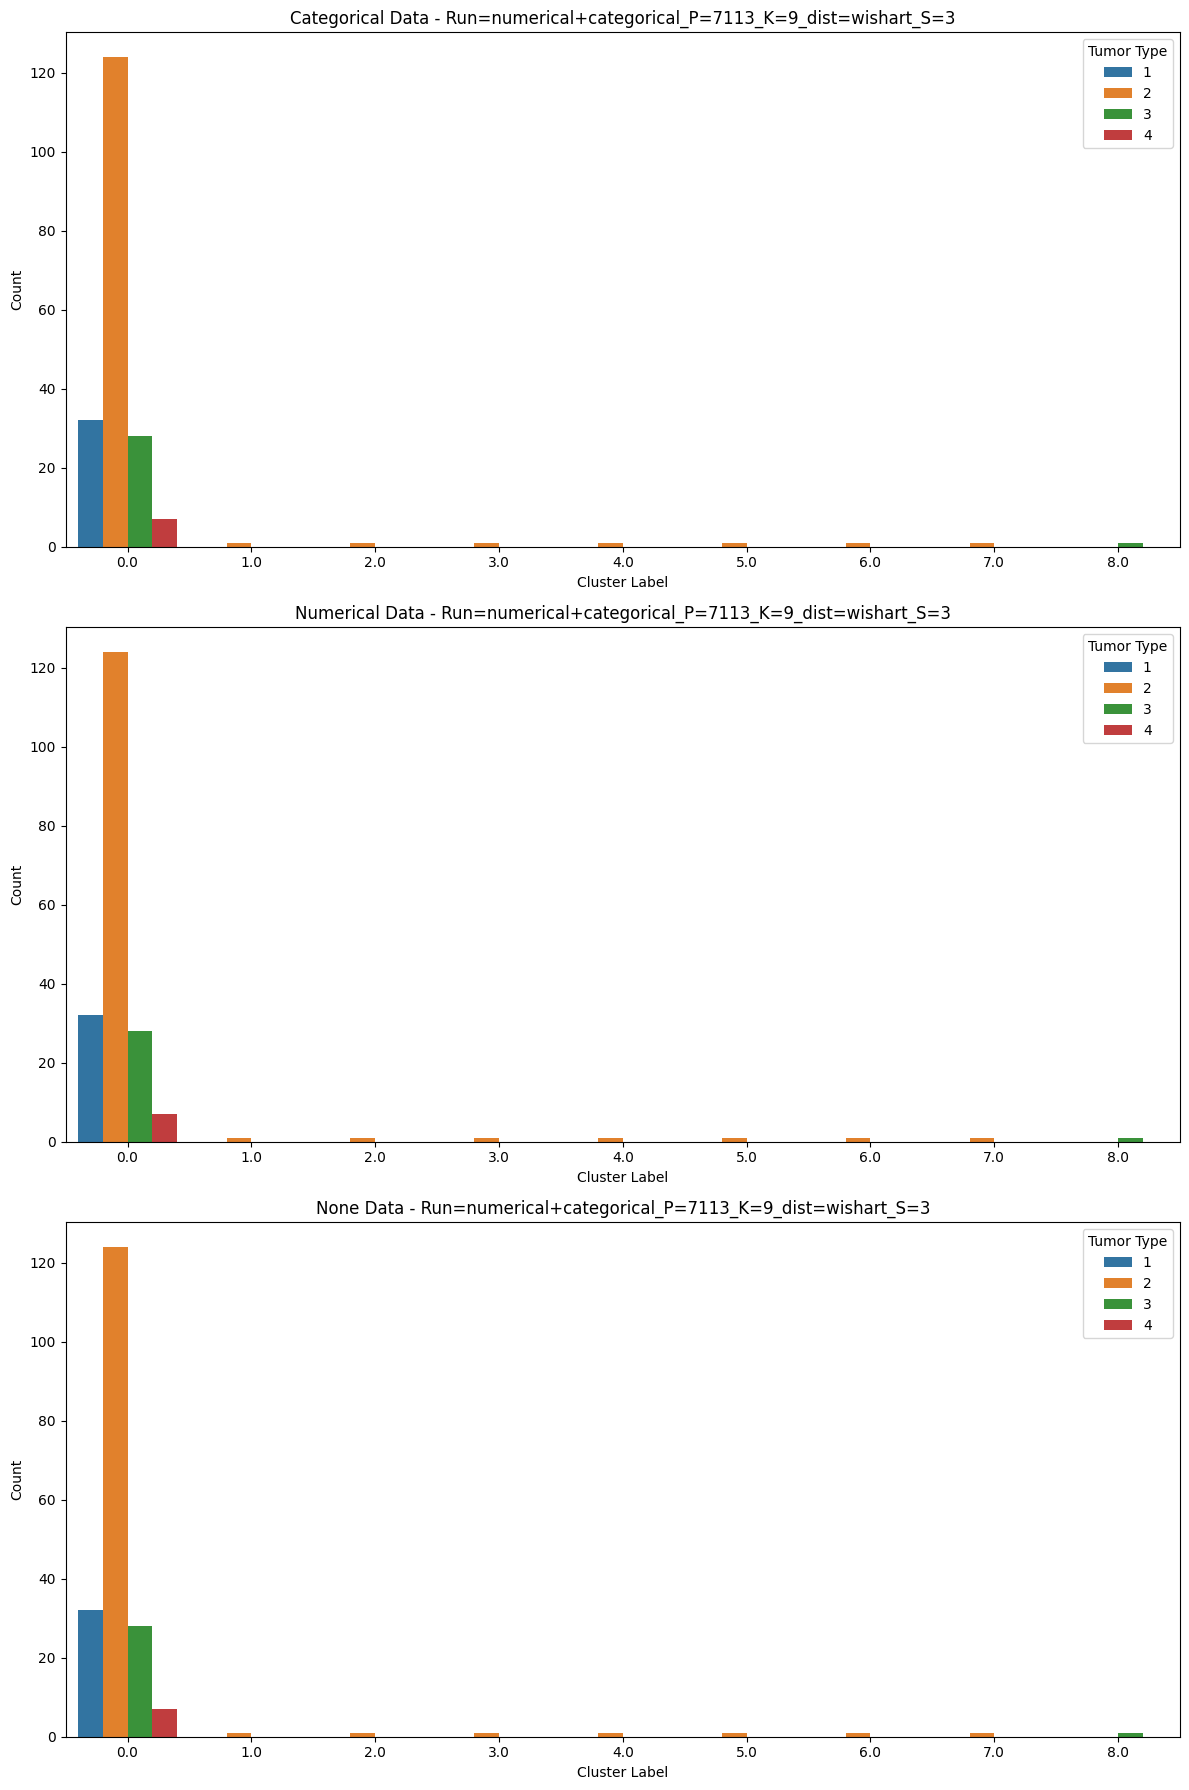

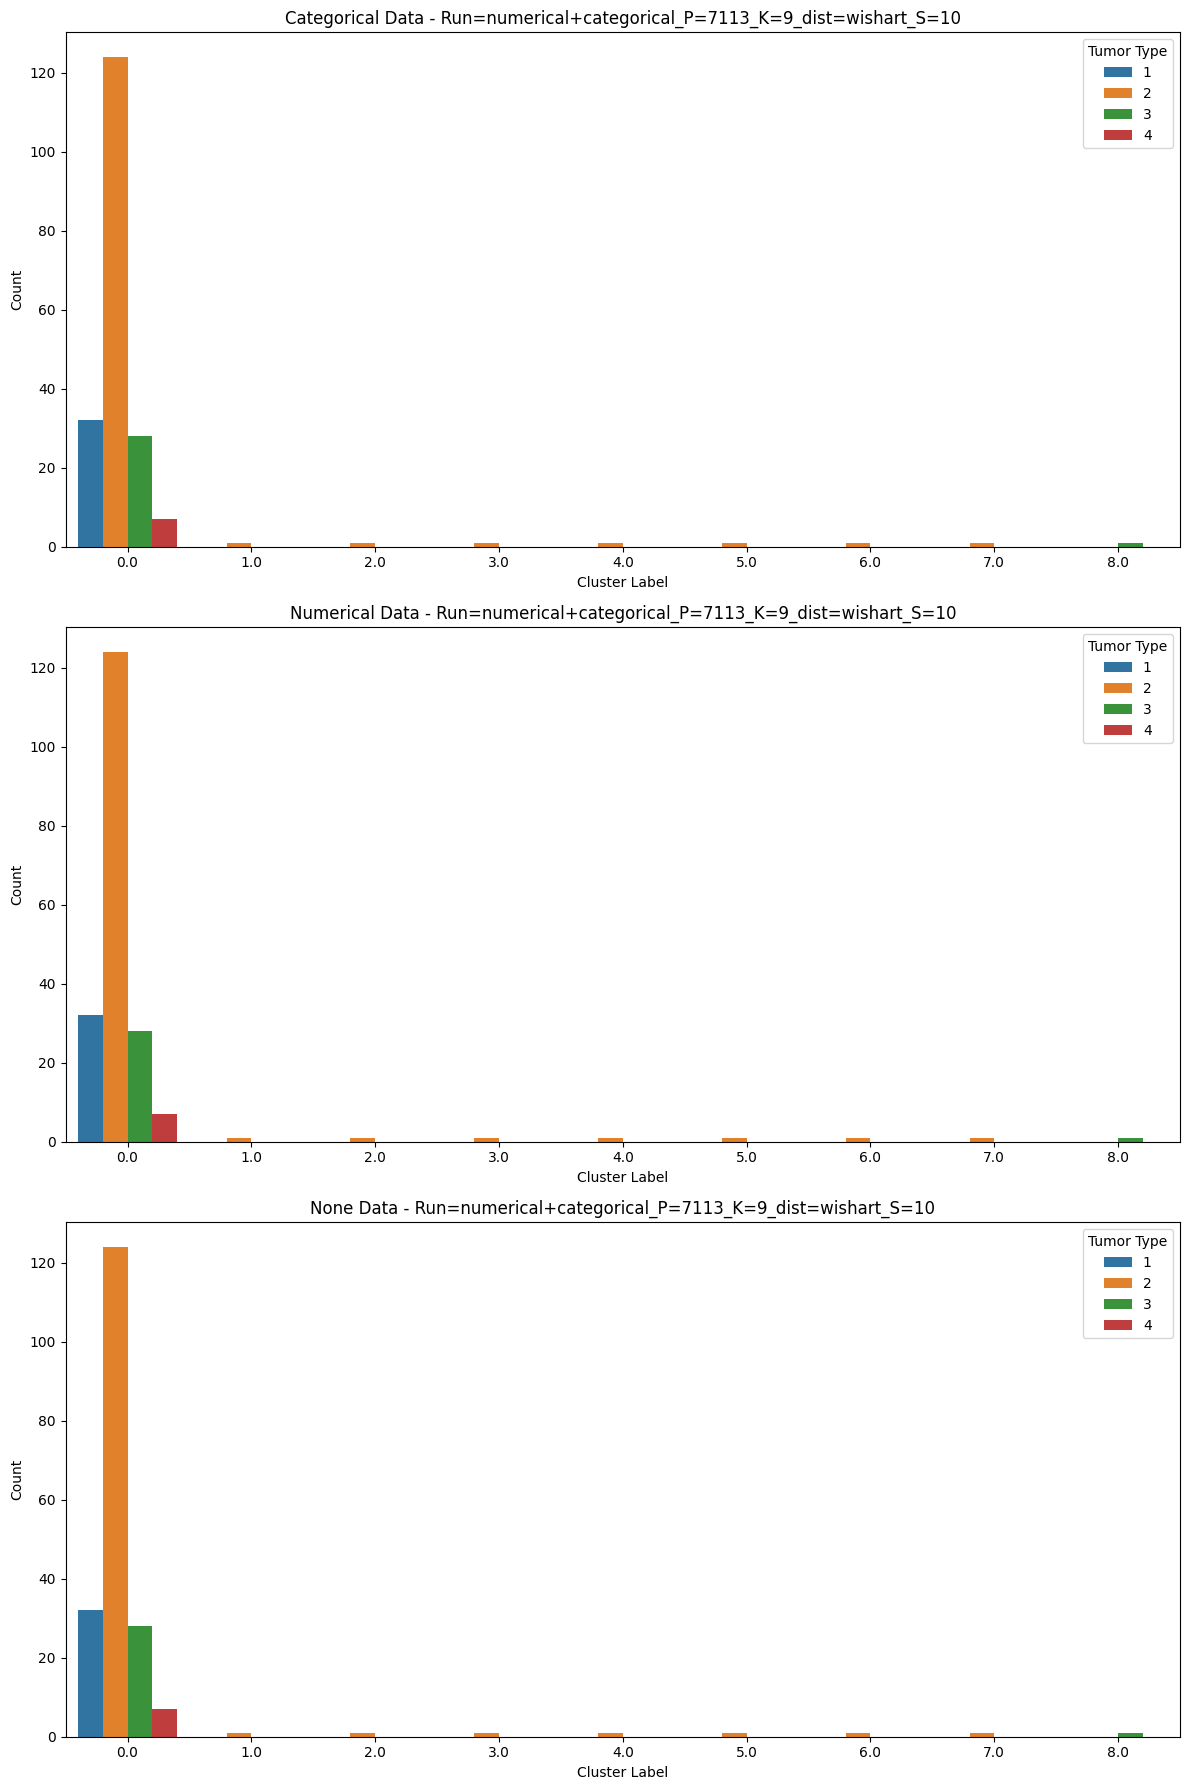

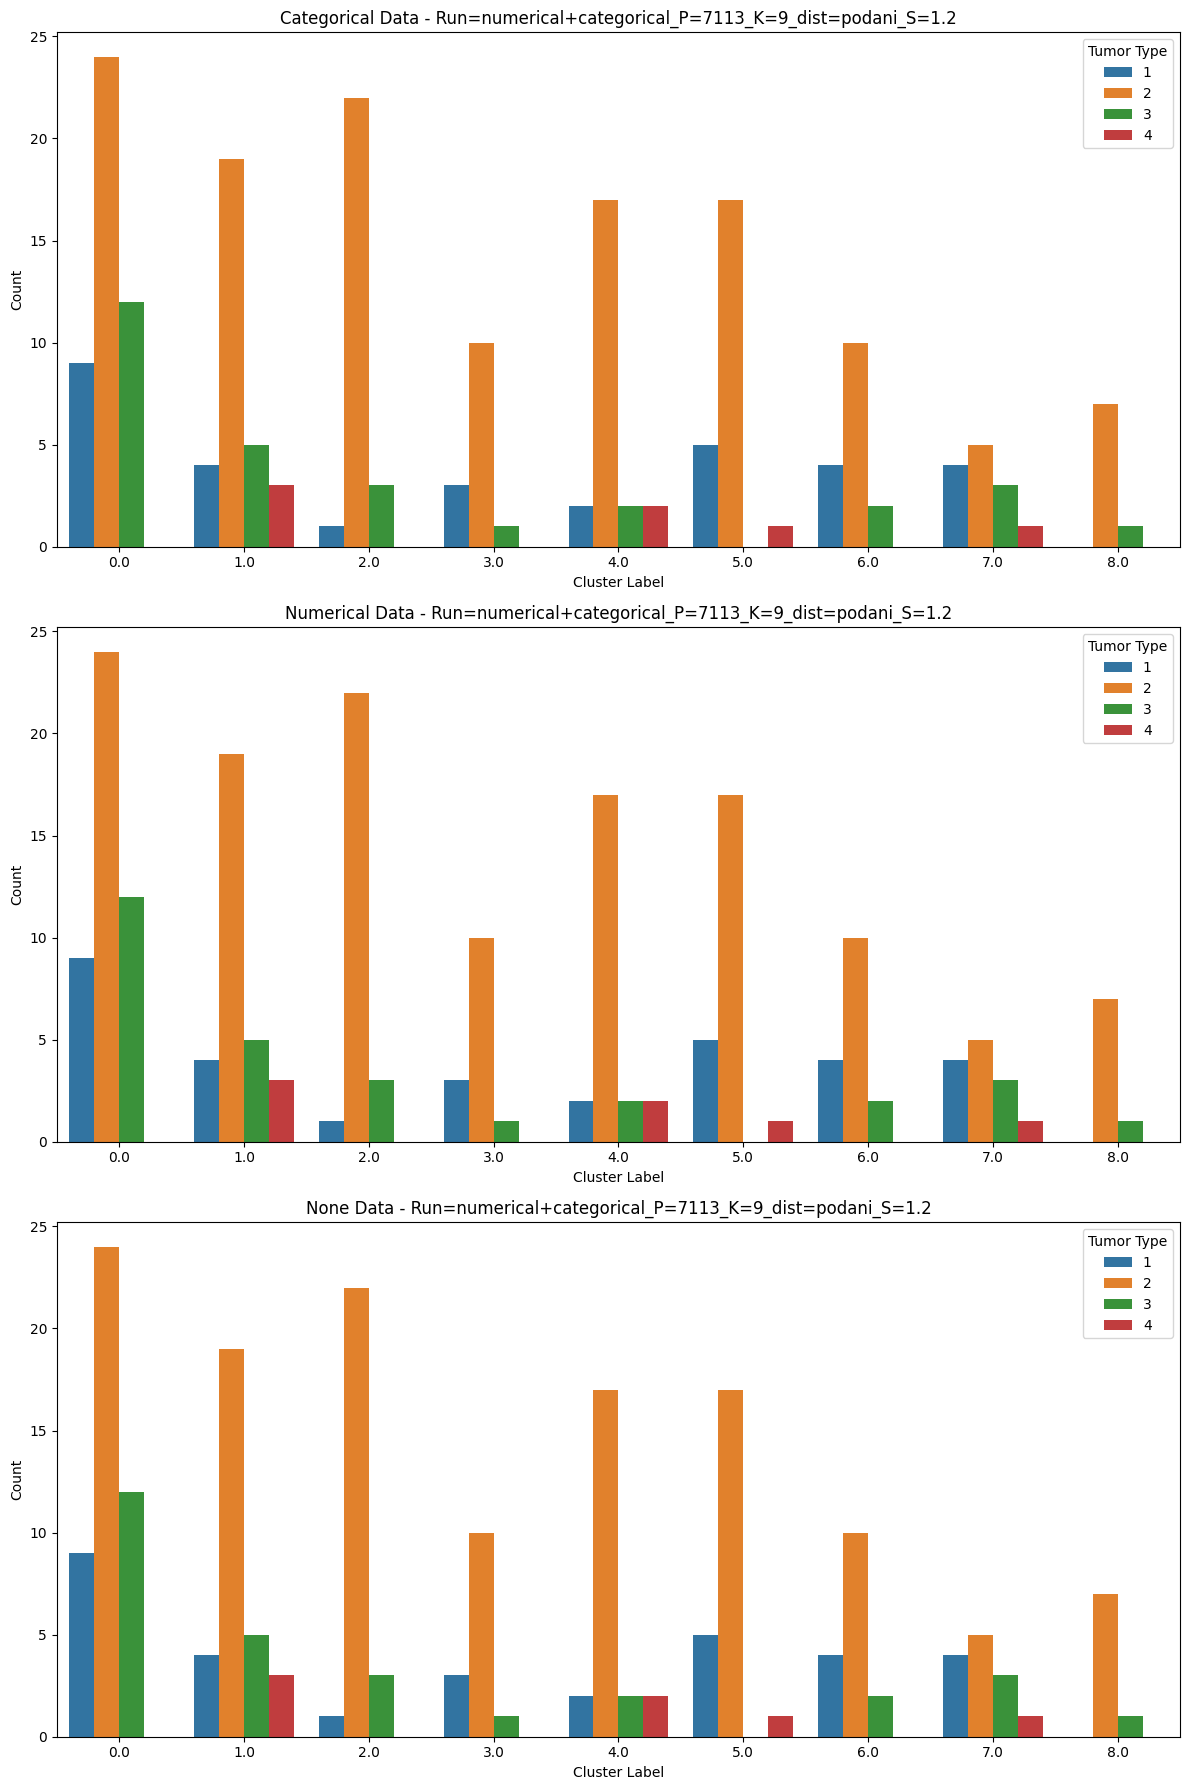

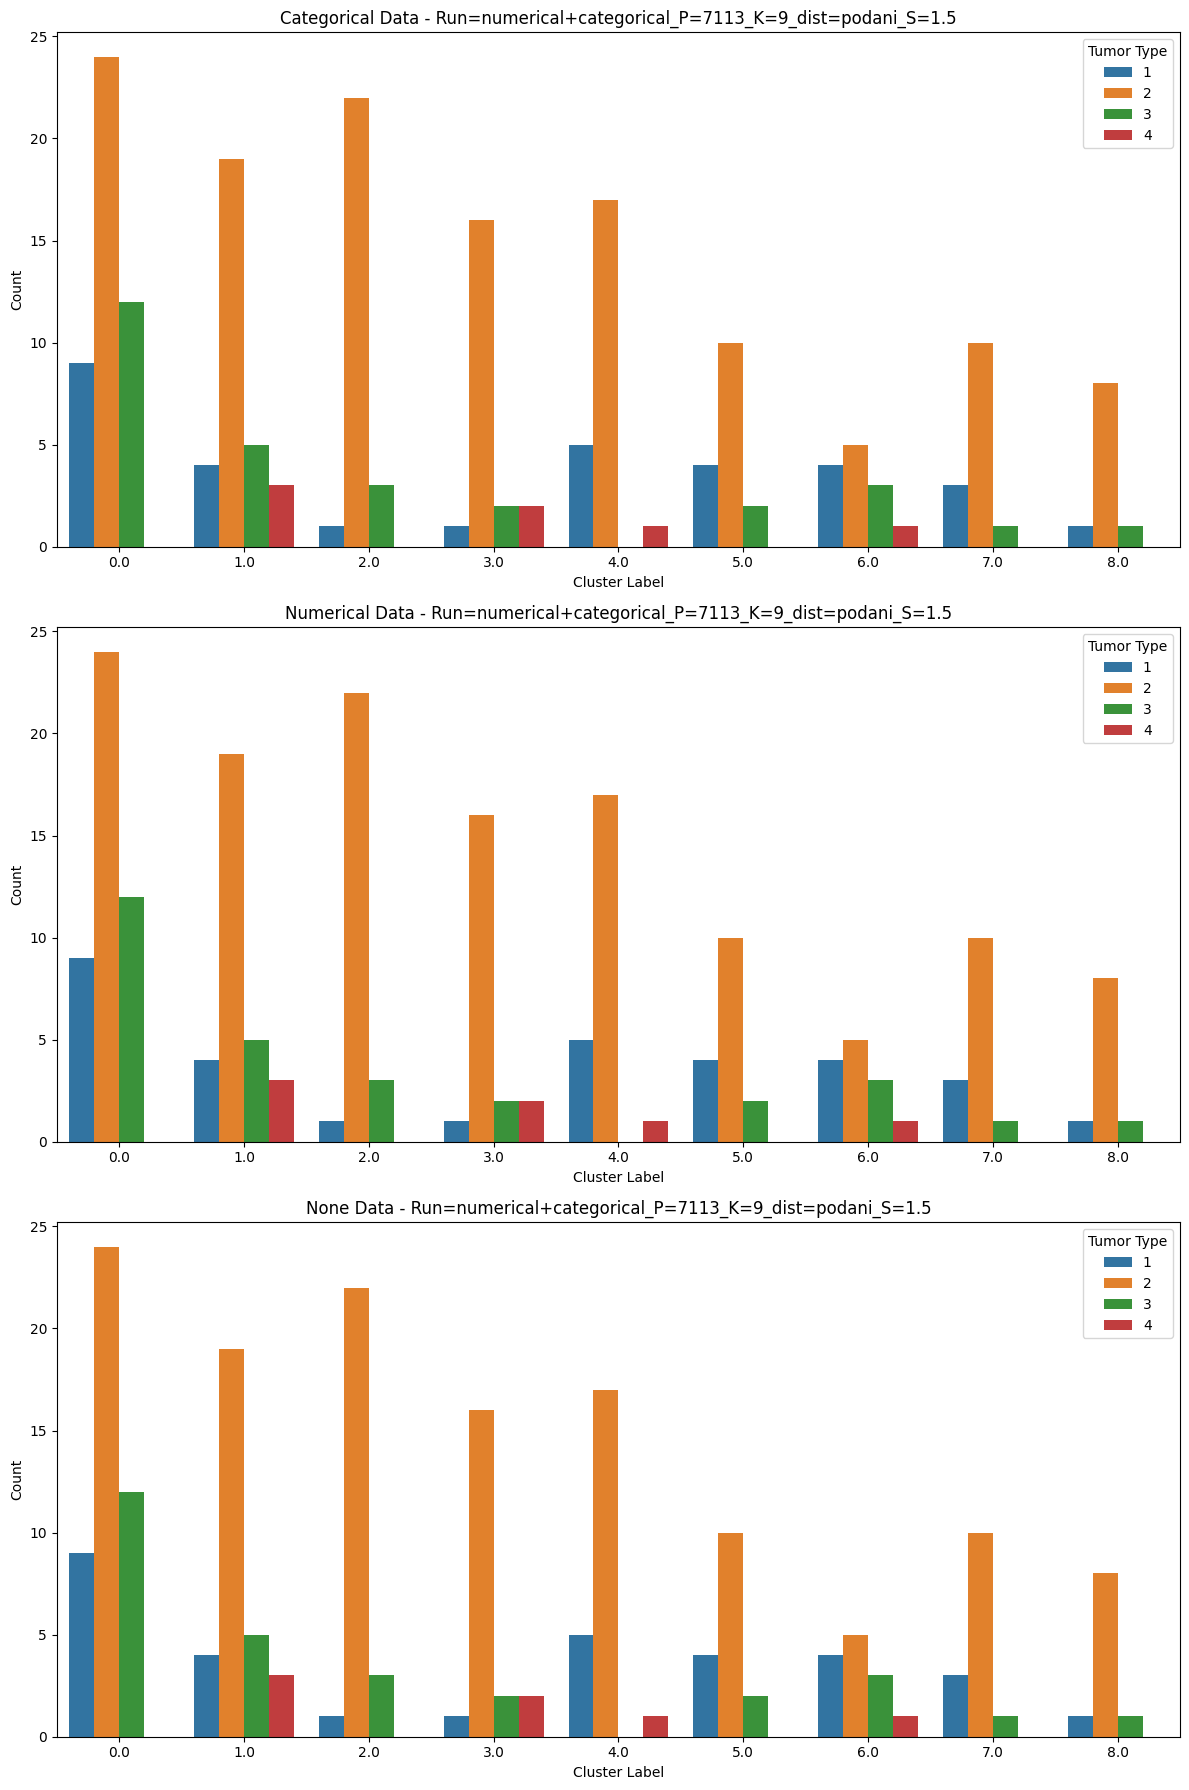

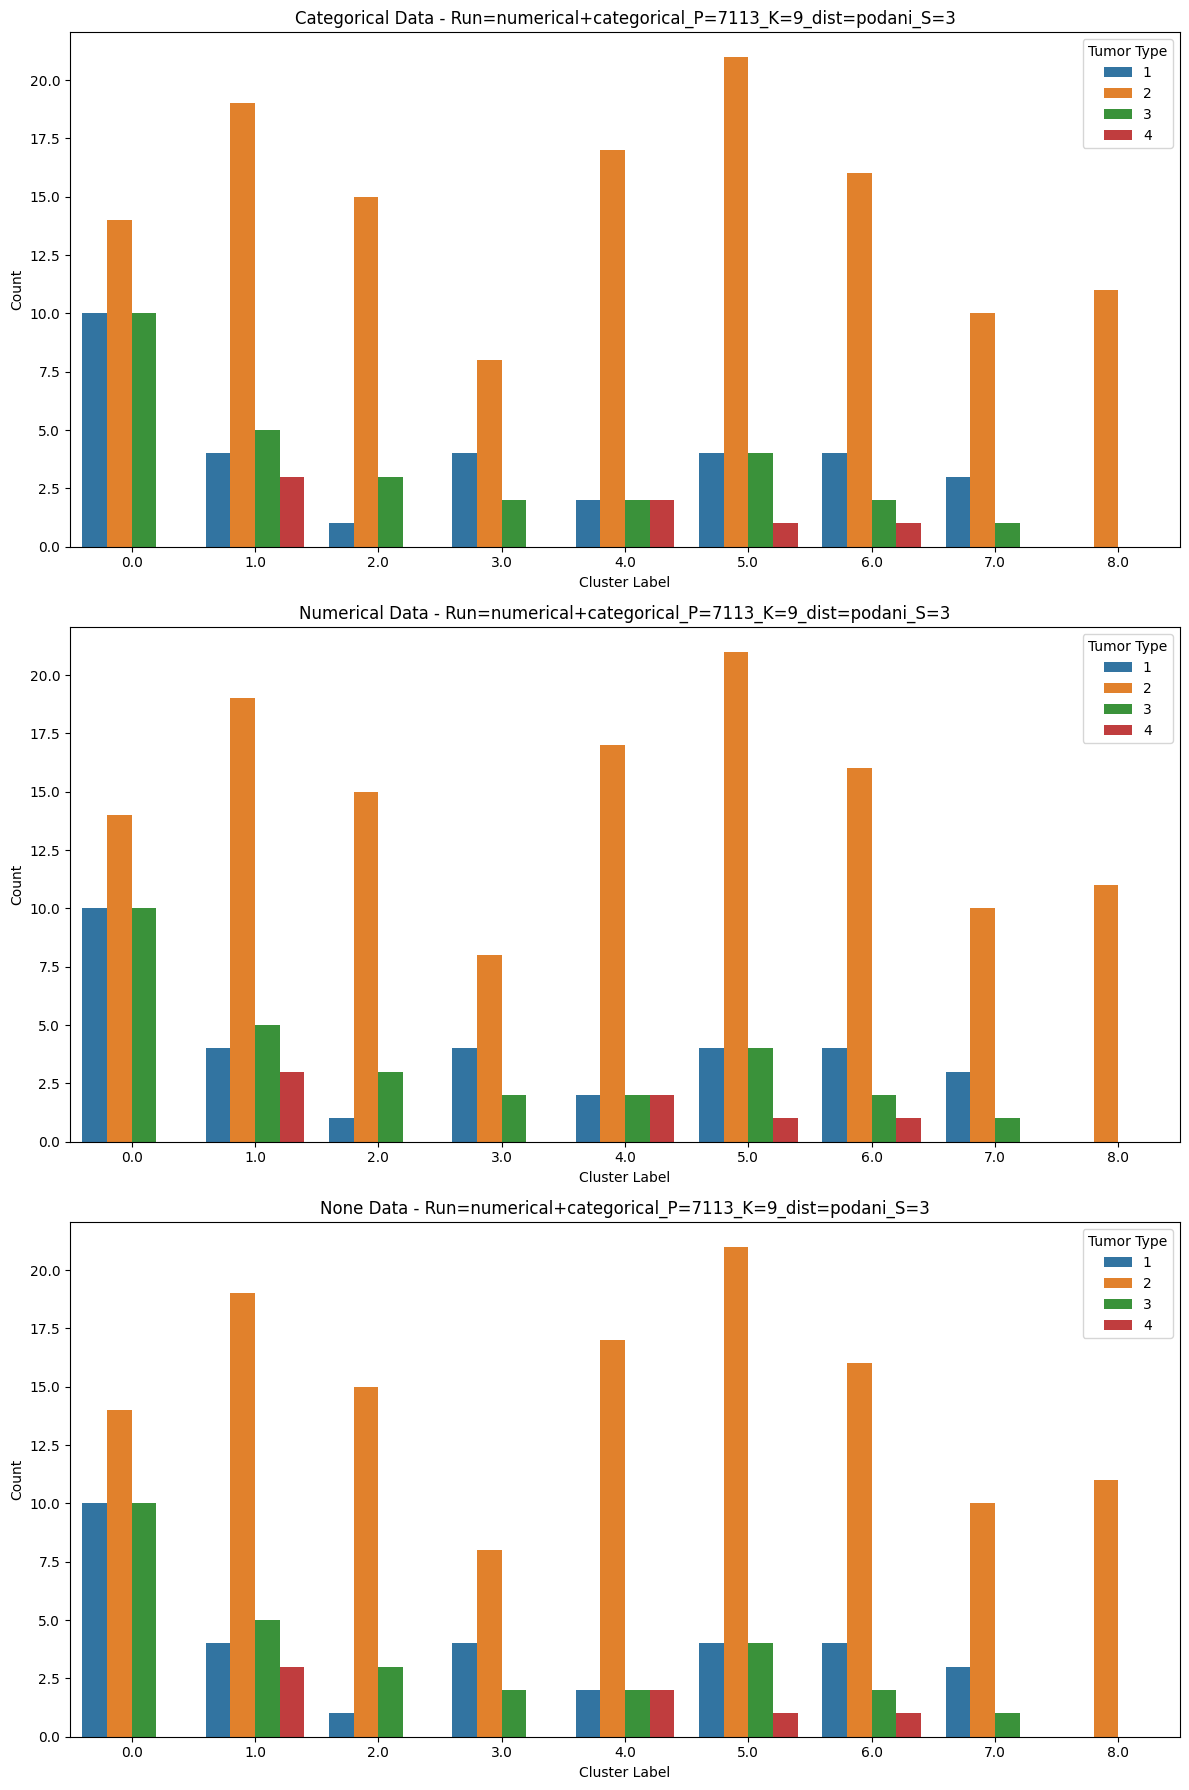

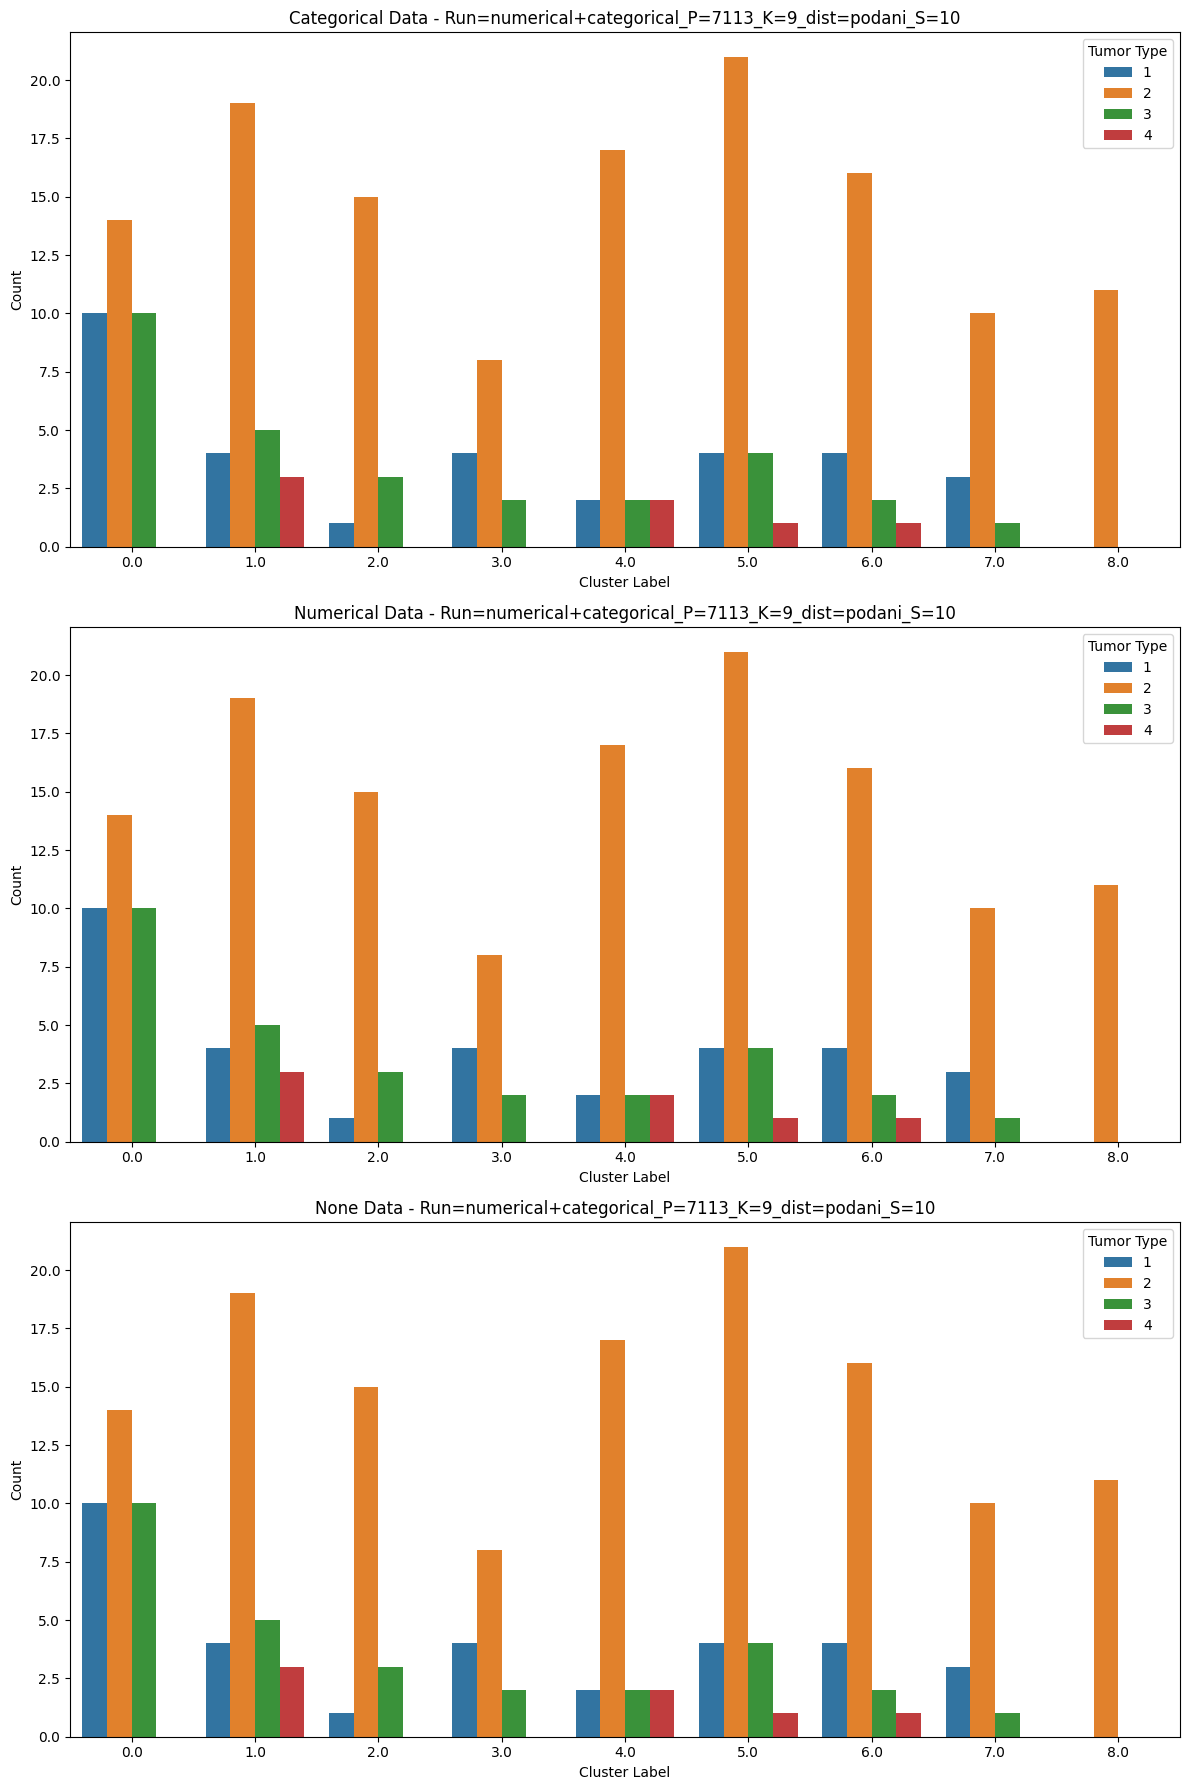

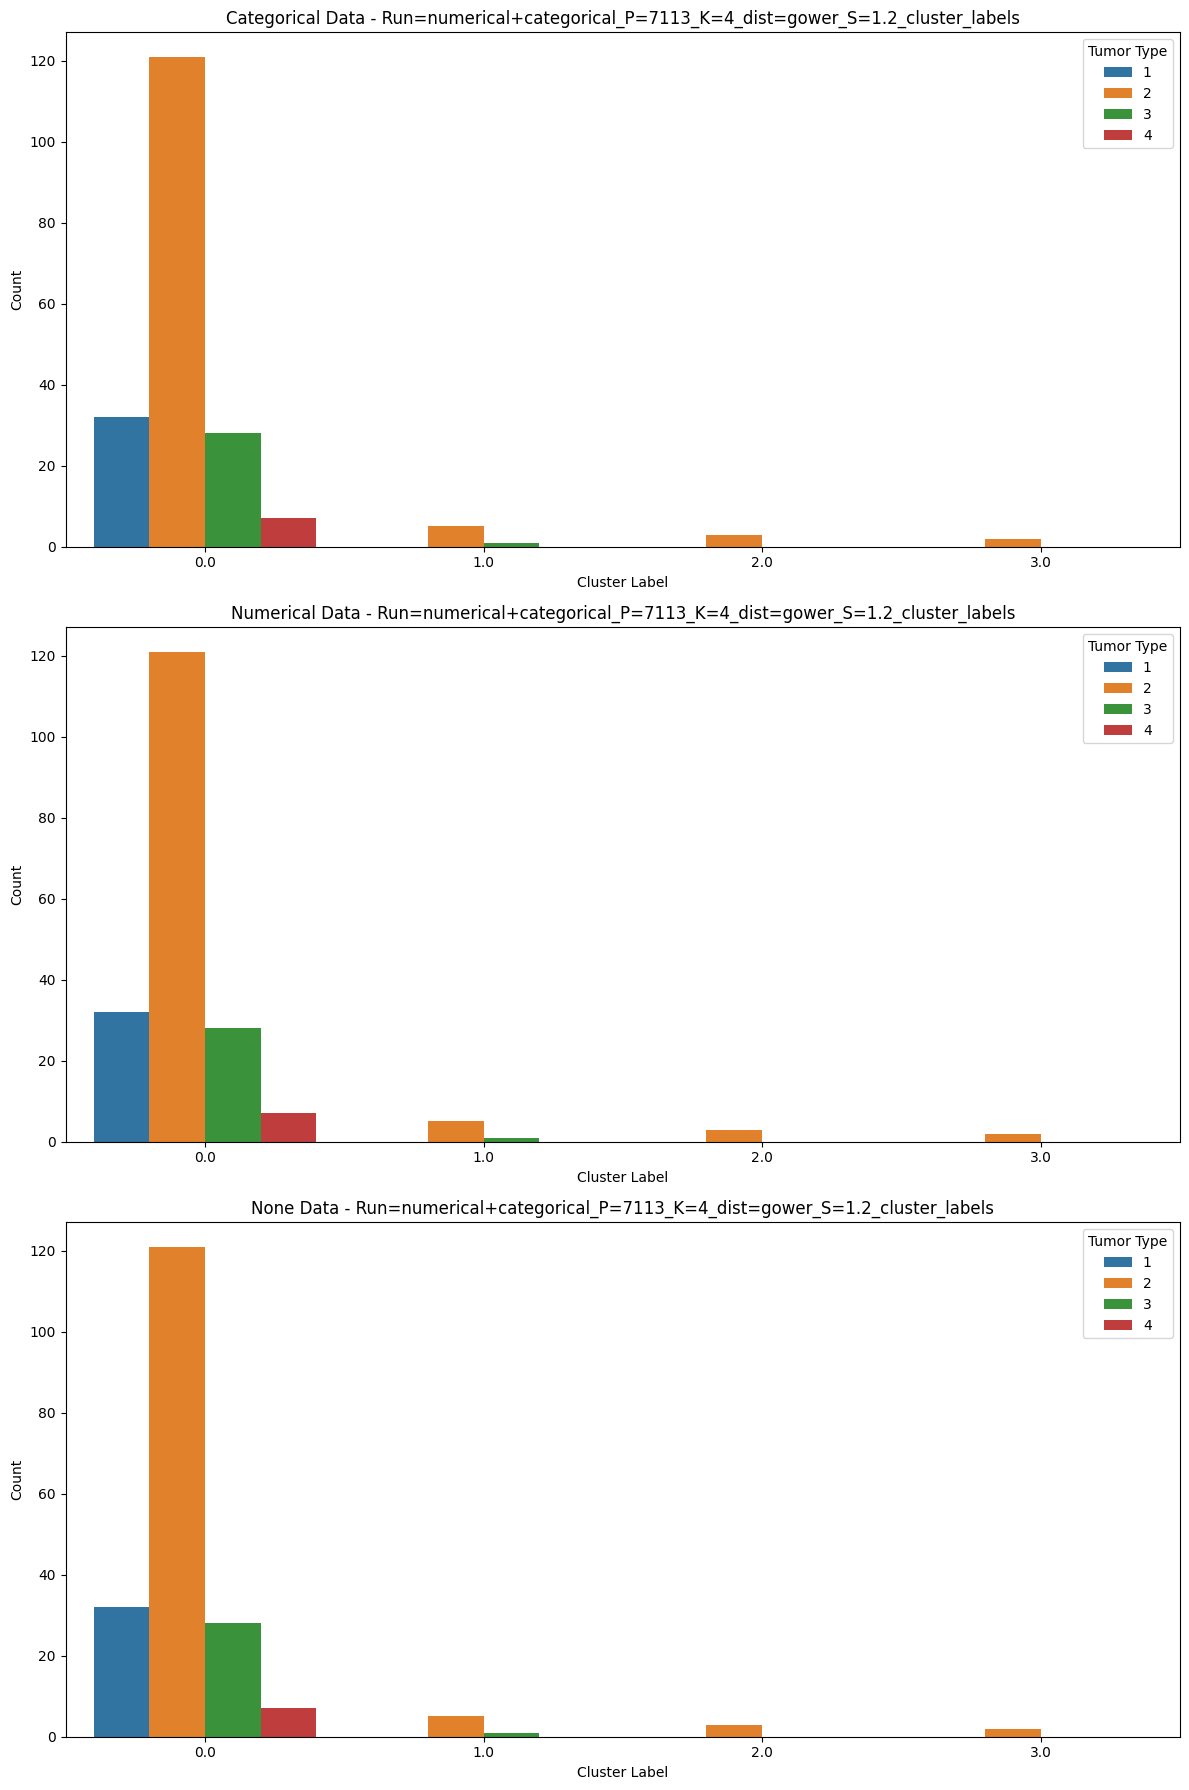

In [20]:
df_categorical = pd.read_csv("combined_results/combined_labels_None.csv")
df_numerical = pd.read_csv("combined_results/combined_labels_None.csv")
df_none = pd.read_csv("combined_results/combined_labels_None.csv")

# Function to create bar plots for all cluster columns in a DataFrame
def create_all_bar_plots(df_categorical, df_numerical, df_none, column_index):
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Categorical
    sns.countplot(data=df_categorical, 
                  x=df_categorical.columns[column_index], 
                  hue="ajcc_tumor_pathologic_pt_cleaned", 
                  ax=axs[0])
    axs[0].set_title(f'Categorical Data - {df_categorical.columns[column_index]}')
    axs[0].set_xlabel('Cluster Label')
    axs[0].set_ylabel('Count')
    axs[0].legend(title='Tumor Type')

    # Numerical
    sns.countplot(data=df_numerical, 
                  x=df_numerical.columns[column_index], 
                  hue="ajcc_tumor_pathologic_pt_cleaned", 
                  ax=axs[1])
    axs[1].set_title(f'Numerical Data - {df_numerical.columns[column_index]}')
    axs[1].set_xlabel('Cluster Label')
    axs[1].set_ylabel('Count')
    axs[1].legend(title='Tumor Type')

    # None
    sns.countplot(data=df_none, 
                  x=df_none.columns[column_index], 
                  hue="ajcc_tumor_pathologic_pt_cleaned", 
                  ax=axs[2])
    axs[2].set_title(f'None Data - {df_none.columns[column_index]}')
    axs[2].set_xlabel('Cluster Label')
    axs[2].set_ylabel('Count')
    axs[2].legend(title='Tumor Type')

    plt.tight_layout()
    plt.show()

# Create bar plots for all cluster columns
for i in range(1, len(df_none.columns) - 2):  # Exclude the last two columns, which are not cluster labels
    create_all_bar_plots(df_categorical, df_numerical, df_none,i)

In [10]:
# Load each CSV file into a DataFrame
df_categorical = pd.read_csv("combined_results/combined_labels_None.csv")
df_numerical = pd.read_csv("combined_results/combined_labels_None.csv")
df_none = pd.read_csv("combined_results/combined_labels_None.csv")

def reshape_dataframe(df, run_type):
    # Reshape the DataFrame from wide format to long format
    df = df.melt(var_name='configuration', value_name='score')

    # Extract details from the configuration
    df['run_type'] = run_type
    df['P'] = df['configuration'].str.extract(r'P=(\d+)').astype(int)
    df['K'] = df['configuration'].str.extract(r'K=(\d+)').astype(int)
    df['dist'] = df['configuration'].str.extract(r'dist=([a-z]+)')
    df['S'] = df['configuration'].str.extract(r'S=([0-9\.]+)').astype(float)

    return df

# Reshape each DataFrame
df_scores_categorical = reshape_dataframe(df_scores_categorical, 'categorical')
df_scores_numerical = reshape_dataframe(df_scores_numerical, 'numerical')
df_scores_none = reshape_dataframe(df_scores_none, 'none')

# Combine all the reshaped DataFrames
df_scores = pd.concat([df_scores_categorical, df_scores_numerical, df_scores_none], ignore_index=True)

# Function to create a plot for the distribution of scores
def create_score_distribution_plot(df, variable, title):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x=variable, y='score', hue='run_type')
    plt.title(title)
    plt.xlabel(variable.capitalize())
    plt.ylabel('Score')
    plt.legend(title='Run Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create a plot for each variable
create_score_distribution_plot(df_scores, 'S', 'Score Distribution Across Different S Values')
create_score_distribution_plot(df_scores, 'dist', 'Score Distribution Across Different Distance Metrics')
create_score_distribution_plot(df_scores, 'run_type', 'Score Distribution Across Different Run Types')

NameError: name 'df_scores_categorical' is not defined

In [11]:
# Let's get the feature names
categorical_cols = ["pr_status_by_ihc","her2_status_by_ihc","er_status_by_ihc"]
numerical_cols = maf_df.select_dtypes(include=np.number).columns.tolist()

In [13]:
# Load each CSV file into a DataFrame
df_weights_categorical = pd.read_csv("combined_results/combined_weights_None.csv")
df_weights_numerical = pd.read_csv("combined_results/combined_weights_None.csv")
df_weights_none = pd.read_csv("combined_results/combined_weights_None.csv")

In [14]:
df_weights_categorical["Features"] = categorical_cols
df_weights_numerical["Features"] = numerical_cols
df_weights_none["Features"] = numerical_cols + categorical_cols

ValueError: Length of values (3) does not match length of index (7113)

## What features is is paying attention to?

In [11]:
long_categorical = reshape_dataframe(df_weights_categorical, "categorical")
long_categorical["Feature"] = categorical_cols * 15

# Get the unique distance metrics
dist_metrics = long_categorical['dist'].unique()

# For each distance metric
for dist in dist_metrics:
    # Filter dataframe by distance metric
    df_dist = long_categorical[long_categorical['dist'] == dist]
    
    # Create a new figure
    plt.figure(figsize=(10,6))

    # Create boxplot
    sns.boxplot(x='Feature', y='score', data=df_dist)

    # Set title
    plt.title(f'Dist: {dist}')
    
    # Show the plot
    plt.show()

ValueError: cannot convert float NaN to integer

In [12]:
long_numerical = reshape_dataframe(df_weights_numerical, "numerical")
long_numerical["Feature"] = numerical_cols * 15

# Get the unique distance metrics
dist_metrics = long_numerical['dist'].unique()

# For each distance metric
for dist in dist_metrics:
    # Filter dataframe by distance metric
    df_dist = long_numerical[long_numerical['dist'] == dist]
    
    # Create a new figure
    plt.figure(figsize=(20,5))

    # Create boxplot
    sns.boxplot(x='Feature', y='score', data=df_dist)

    # Set title
    plt.title(f'Dist: {dist}')
    
    # Show the plot
    plt.show()

ValueError: cannot convert float NaN to integer

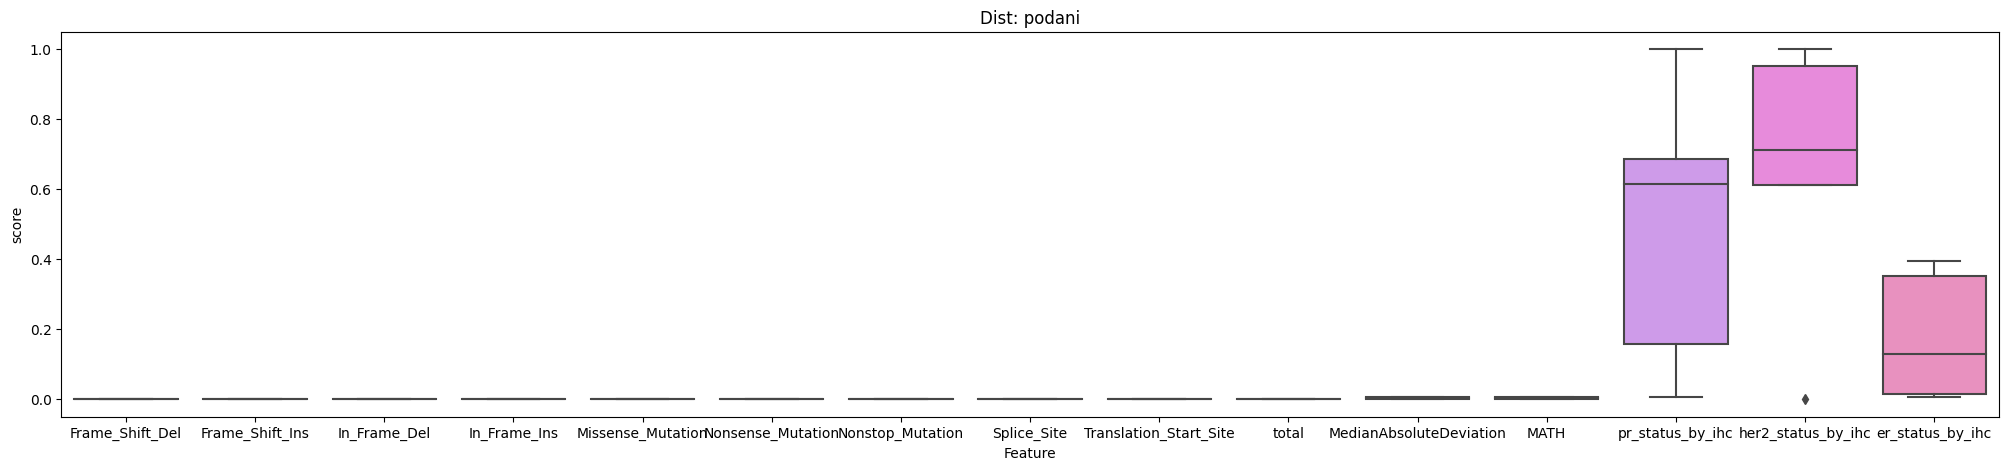

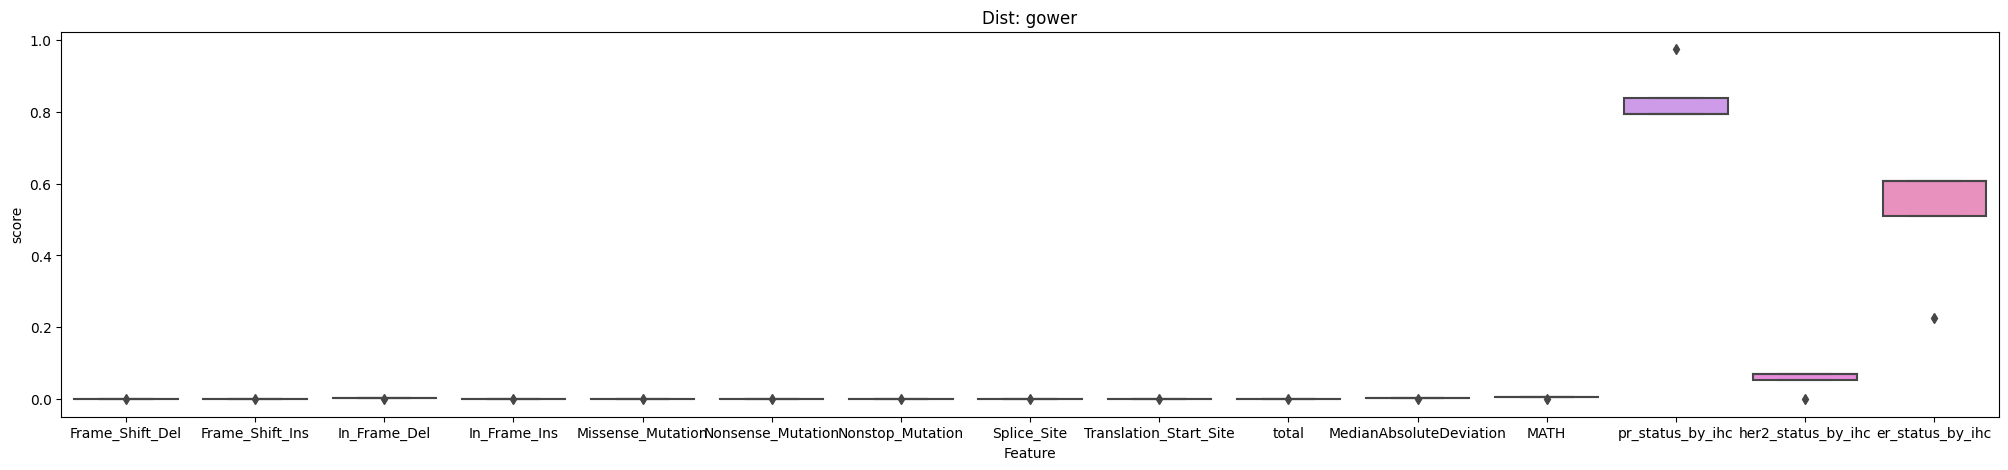

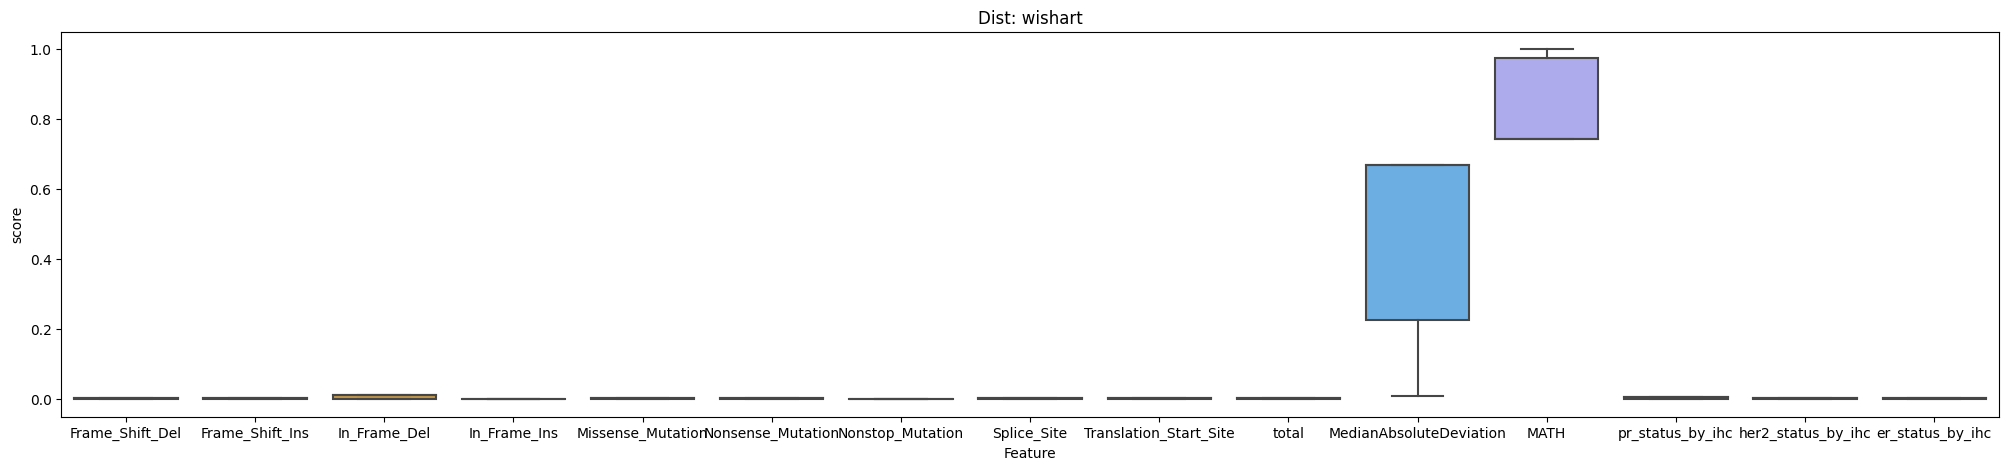

In [121]:
long_none = reshape_dataframe(df_weights_none, "numerical")
long_none["Feature"] = ( numerical_cols + categorical_cols ) * 15

# Get the unique distance metrics
dist_metrics = long_none['dist'].unique()

# For each distance metric
for dist in dist_metrics:
    # Filter dataframe by distance metric
    df_dist = long_none[long_none['dist'] == dist]
    
    # Create a new figure
    plt.figure(figsize=(25,5))

    # Create boxplot
    sns.boxplot(x='Feature', y='score', data=df_dist)

    # Set title
    plt.title(f'Dist: {dist}')
    
    # Show the plot
    plt.show()

## Trying the AAJC categories as hypothetical labels

'C'